# Modular Model Creation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

def analyze_uncensoring_methods(csv_file_path, metric_name, max_depth=4, test_size=0.2, random_state=42):
    """
    Complete analysis pipeline for uncensoring method selection using decision trees.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing the uncensoring data
    metric_name : str
        The metric to use for finding the best method (e.g., 'weighted_mae_0', 'accuracy', 'mse', etc.)
    max_depth : int, default=4
        Maximum depth of the decision tree
    test_size : float, default=0.2
        Proportion of dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'classifier': Trained DecisionTreeClassifier
        - 'X_train', 'X_test', 'y_train', 'y_test': Train/test splits
        - 'y_pred': Predictions on test set
        - 'df': Full dataframe with best_method column
        - 'results': Dictionary with all evaluation metrics
    """
    
    # Read the data
    df = pd.read_csv(csv_file_path)
    
    # Define the methods
    methods = ['Bayesian_POS', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad', 
               'Baseline', 'Agrawal']
    
    # Create the column names for the specified metric
    metric_cols = [f"{method}_{metric_name}" for method in methods]
    
    # Check if all metric columns exist in the dataframe
    missing_cols = [col for col in metric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Find the best method for each row based on the metric
    # For metrics like MAE, MSE (lower is better), use idxmin
    # For metrics like accuracy (higher is better), use idxmax
    if any(keyword in metric_name.lower() for keyword in ['mae', 'mse', 'error', 'loss']):
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmin(axis=1)
        optimization_direction = "minimize"
    else:
        # For accuracy and similar metrics where higher is better
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmax(axis=1)
        optimization_direction = "maximize"
    
    # Map the column names back to method names
    col_to_method_map = {f"{method}_{metric_name}": method for method in methods}
    df[f'best_method_{metric_name}'] = df[f'best_method_{metric_name}'].map(col_to_method_map)
    
    # Define feature columns
    feature_cols = [
        'data_sparsity', 'stockout_rate', 'verkauf_variance', 'verkauf_mean', 
        'coefficient_of_variation', 'unique_quantities', 'variance_to_mean_ratio', 
        'verkauf_autocorr', 'adi', 'Gesamtzeilen', 'KSR_Count', 'TSR_Count', 
        'KSR_TSR_Summe', 'KSR_Anteil', 'TSR_Anteil', 'KSR_TSR_Anteil'
    ]
    
    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in dataframe: {missing_features}")
    
    # Prepare X and y
    X = df[feature_cols]
    y = df[f'best_method_{metric_name}']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # ============================================================================
    # Evaluation and Analysis
    # ============================================================================
    
    print(f"UNCENSORING METHOD ANALYSIS - {metric_name.upper()}")
    print("="*80)
    print(f"Dataset: {csv_file_path}")
    print(f"Metric: {metric_name} ({optimization_direction})")
    print(f"Sample size: {len(df)} observations")
    print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\nCLASSIFICATION PERFORMANCE")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # MCC interpretation
    if mcc > 0.8:
        interpretation = "Very Strong"
    elif mcc > 0.6:
        interpretation = "Strong" 
    elif mcc > 0.4:
        interpretation = "Moderate"
    elif mcc > 0.2:
        interpretation = "Weak"
    elif mcc > 0:
        interpretation = "Very Weak"
    elif mcc == 0:
        interpretation = "No Correlation"
    else:
        interpretation = "Negative Correlation"
    
    print(f"Correlation Strength: {interpretation}")
    
    # ============================================================================
    # Metric-based Evaluation
    # ============================================================================
    
    print(f"\n{metric_name.upper()} COMPARISON RESULTS")
    print("="*80)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy
    most_common_method = y_train.mode()[0]  # Use training set to determine most common
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    # Calculate average metric for each method across all data
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Print results
    print(f"1. Perfect Strategy (Oracle):        {perfect_avg_metric:.6f}")
    print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
    print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
    print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")
    
    # ============================================================================
    # Performance Analysis
    # ============================================================================
    
    print(f"\nPERFORMACE ANALYSIS")
    print("="*80)
    
    if optimization_direction == "minimize":
        # For metrics where lower is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
        dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    else:
        # For metrics where higher is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (dt_avg_metric / common_avg_metric - 1) * 100
        dt_vs_best_overall = (dt_avg_metric / best_overall_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            {dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    
    # ============================================================================
    # Method Distribution Analysis
    # ============================================================================
    
    print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
    print("="*80)
    print("Decision Tree Predictions:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for method, count in pred_counts.items():
        print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")
    
    print(f"\nActual Best Methods:")
    actual_counts = y_test.value_counts().sort_index()
    for method, count in actual_counts.items():
        print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")
    
    print(f"\nOverall Method Performance (Average {metric_name} across all data):")
    print("="*80)
    if optimization_direction == "minimize":
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
    else:
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)
    
    for method, avg_metric in sorted_methods:
        print(f"  {method}: {avg_metric:.6f}")
    
    # Decision tree accuracy in terms of picking the exact best method
    exact_matches = sum(y_pred == y_test)
    accuracy = exact_matches / len(y_test)
    print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")
    
    # Prepare results dictionary
    results = {
        'perfect_avg_metric': perfect_avg_metric,
        'dt_avg_metric': dt_avg_metric,
        'common_avg_metric': common_avg_metric,
        'best_overall_avg_metric': best_overall_avg_metric,
        'most_common_method': most_common_method,
        'best_overall_method': best_overall_method,
        'mcc': mcc,
        'accuracy': accuracy,
        'method_avg_metrics': method_avg_metrics,
        'optimization_direction': optimization_direction
    }
    
    return {
        'classifier': clf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'df': df,
        'results': results
    }

# Model With Resampling

In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

def analyze_uncensoring_methods(csv_file_path, metric_name, max_depth=4, min_samples_split=2, 
                               min_samples_leaf=1, max_leaf_nodes=None, min_weight_fraction_leaf=0.0,
                               test_size=0.2, random_state=42, apply_resampling=False, resampling_params=None):
    """
    Complete analysis pipeline for uncensoring method selection using decision trees.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing the uncensoring data
    metric_name : str
        The metric to use for finding the best method (e.g., 'weighted_mae_0', 'accuracy', 'mse', etc.)
    max_depth : int, default=4
        Maximum depth of the decision tree
    min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node
    min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node
    max_leaf_nodes : int, default=None
        Grow a tree with max_leaf_nodes in best-first fashion
    min_weight_fraction_leaf : float, default=0.0
        The minimum weighted fraction of the sum total of weights required to be at a leaf node
    test_size : float, default=0.2
        Proportion of dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    apply_resampling : bool, default=False
        Whether to apply resampling techniques to balance the training data
    resampling_params : dict, optional
        Parameters for resampling. If None, uses default values:
        {
            'min_class_size': 6,
            'majority_class_limit': 4000,
            'use_smote': True
        }
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'classifier': Trained DecisionTreeClassifier
        - 'X_train', 'X_test', 'y_train', 'y_test': Train/test splits
        - 'y_pred': Predictions on test set
        - 'df': Full dataframe with best_method column
        - 'results': Dictionary with all evaluation metrics
        - 'resampling_info': Information about resampling if applied
    """
    
    # Set default resampling parameters
    if resampling_params is None:
        resampling_params = {
            'min_class_size': 6,
            'majority_class_limit': 4000,
            'use_smote': True
        }
    
    # Read the data
    df = pd.read_csv(csv_file_path)
    df = df[df['laenge'] >= 5]
    
    # Define the methods
    methods = ['Bayesian_POS', 'N1', 'N2', 'N3', 'EM', 'PD', 'Nahmias', 'Conrad', 
               'Baseline', 'Agrawal']
    
    # Create the column names for the specified metric
    metric_cols = [f"{method}_{metric_name}" for method in methods]
    
    # Check if all metric columns exist in the dataframe
    missing_cols = [col for col in metric_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")
    
    # Find the best method for each row based on the metric
    # For metrics like MAE, MSE (lower is better), use idxmin
    # For metrics like accuracy (higher is better), use idxmax
    if any(keyword in metric_name.lower() for keyword in ['mae', 'mse', 'error', 'loss']):
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmin(axis=1)
        optimization_direction = "minimize"
    else:
        # For accuracy and similar metrics where higher is better
        df[f'best_method_{metric_name}'] = df[metric_cols].idxmax(axis=1)
        optimization_direction = "maximize"
    
    # Map the column names back to method names
    col_to_method_map = {f"{method}_{metric_name}": method for method in methods}
    df[f'best_method_{metric_name}'] = df[f'best_method_{metric_name}'].map(col_to_method_map)
    
    # Define feature columns
    feature_cols = [
        'data_sparsity', 'stockout_rate', 'verkauf_variance', 'verkauf_mean', 
        'coefficient_of_variation', 'unique_quantities', 'variance_to_mean_ratio', 
        'verkauf_autocorr', 'adi', 'Gesamtzeilen', 'KSR_Count', 'TSR_Count', 
        'KSR_TSR_Summe', 'KSR_Anteil', 'TSR_Anteil', 'KSR_TSR_Anteil'
    ]
    
    # Check if all feature columns exist
    missing_features = [col for col in feature_cols if col not in df.columns]
    if missing_features:
        raise ValueError(f"Missing feature columns in dataframe: {missing_features}")
    
    # Prepare X and y
    X = df[feature_cols]
    y = df[f'best_method_{metric_name}']
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # ============================================================================
    # RESAMPLING SECTION
    # ============================================================================
    
    resampling_info = {'applied': False}
    
    if apply_resampling:
        print(f"\nRESAMPLING ANALYSIS")
        print("="*80)
        
        # Analyze class distribution before resampling
        y_counts = Counter(y_train)
        print('Class distribution before resampling:')
        sorted_counts = sorted(y_counts.items(), key=lambda item: -item[1])
        for class_name, count in sorted_counts:
            print(f"  {class_name}: {count} samples ({count/len(y_train)*100:.1f}%)")
        
        # Identify classes that need resampling
        small_classes = [cls for cls, count in y_counts.items() 
                        if count < resampling_params['min_class_size']]
        majority_class = max(y_counts, key=y_counts.get)
        
        print(f"\nResampling strategy:")
        print(f"  Small classes (< {resampling_params['min_class_size']} samples): {small_classes}")
        print(f"  Majority class: {majority_class} ({y_counts[majority_class]} samples)")
        
        # Create resampling strategies
        random_sampling_strategy = {cls: resampling_params['min_class_size'] for cls in small_classes}
        under_sampling_strategy = {majority_class: resampling_params['majority_class_limit']}
        
        # Build resampling pipeline
        pipeline_steps = []
        
        # Step 1: Under-sampling (if majority class is too large)
        if y_counts[majority_class] > resampling_params['majority_class_limit']:
            pipeline_steps.append(('under', RandomUnderSampler(
                sampling_strategy=under_sampling_strategy, 
                random_state=random_state
            )))
            print(f"  Under-sampling {majority_class} to {resampling_params['majority_class_limit']} samples")
        
        # Step 2: Random over-sampling (for very small classes)
        if small_classes:
            pipeline_steps.append(('random', RandomOverSampler(
                sampling_strategy=random_sampling_strategy, 
                random_state=random_state
            )))
            print(f"  Over-sampling small classes to {resampling_params['min_class_size']} samples each")
        
        # Step 3: SMOTE (for final balancing)
        if resampling_params['use_smote']:
            pipeline_steps.append(('smote', SMOTE(
                sampling_strategy='auto', 
                random_state=random_state
            )))
            print(f"  Applying SMOTE for synthetic sample generation")
        
        # Apply resampling if any steps are needed
        if pipeline_steps:
            sampler = Pipeline(steps=pipeline_steps)
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)
            
            # Analyze class distribution after resampling
            y_counts_after = Counter(y_train_resampled)
            print(f"\nClass distribution after resampling:")
            sorted_counts_after = sorted(y_counts_after.items(), key=lambda item: -item[1])
            for class_name, count in sorted_counts_after:
                print(f"  {class_name}: {count} samples ({count/len(y_train_resampled)*100:.1f}%)")
            
            # Update training data
            X_train, y_train = X_train_resampled, y_train_resampled
            
            # Store resampling information
            resampling_info = {
                'applied': True,
                'original_distribution': dict(y_counts),
                'resampled_distribution': dict(y_counts_after),
                'original_size': len(y_counts),
                'resampled_size': len(y_counts_after),
                'pipeline_steps': [step[0] for step in pipeline_steps],
                'parameters': resampling_params
            }
            
            print(f"\nResampling completed:")
            print(f"  Original training size: {len(y_counts)} → {len(y_counts_after)} samples")
            print(f"  Size change: {(len(y_counts_after)/len(y_counts)-1)*100:+.1f}%")
        else:
            print("  No resampling needed - class distribution is already balanced")
    
    # ============================================================================
    # MODEL TRAINING
    # ============================================================================
    
    # Initialize and train the classifier
    clf = DecisionTreeClassifier(
        random_state=random_state, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        min_weight_fraction_leaf=min_weight_fraction_leaf
    )
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # ============================================================================
    # Evaluation and Analysis
    # ============================================================================
    
    print(f"\nUNCENSORING METHOD ANALYSIS - {metric_name.upper()}")
    print("="*80)
    print(f"Dataset: {csv_file_path}")
    print(f"Metric: {metric_name} ({optimization_direction})")
    print(f"Sample size: {len(df)} observations")
    if apply_resampling and resampling_info['applied']:
        print(f"Train/Test split: {len(X_train)} (resampled)/{len(X_test)}")
        print(f"Original train size: {resampling_info['original_size']}")
    else:
        print(f"Train/Test split: {len(X_train)}/{len(X_test)}")
    
    print(f"\nCLASSIFICATION PERFORMANCE")
    print("="*80)
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    
    # MCC interpretation
    if mcc > 0.8:
        interpretation = "Very Strong"
    elif mcc > 0.6:
        interpretation = "Strong" 
    elif mcc > 0.4:
        interpretation = "Moderate"
    elif mcc > 0.2:
        interpretation = "Weak"
    elif mcc > 0:
        interpretation = "Very Weak"
    elif mcc == 0:
        interpretation = "No Correlation"
    else:
        interpretation = "Negative Correlation"
    
    print(f"Correlation Strength: {interpretation}")
    
    # ============================================================================
    # Metric-based Evaluation
    # ============================================================================
    
    print(f"\n{metric_name.upper()} COMPARISON RESULTS")
    print("="*80)
    
    # Get the test set indices to align with original dataframe
    test_indices = X_test.index
    
    # 1. Perfect Strategy (Oracle): Always pick the best method
    perfect_metric_values = []
    for idx in test_indices:
        best_method = df.loc[idx, f'best_method_{metric_name}']
        best_metric_value = df.loc[idx, best_method + f'_{metric_name}']
        perfect_metric_values.append(best_metric_value)
    perfect_avg_metric = np.mean(perfect_metric_values)
    
    # 2. Decision Tree Strategy: Use classifier predictions
    dt_metric_values = []
    for i, idx in enumerate(test_indices):
        predicted_method = y_pred[i]
        predicted_metric_value = df.loc[idx, predicted_method + f'_{metric_name}']
        dt_metric_values.append(predicted_metric_value)
    dt_avg_metric = np.mean(dt_metric_values)
    
    # 3. Most Common Method Strategy
    # Use original y_train to avoid bias from resampling
    original_y_train = df.loc[X_train.index, f'best_method_{metric_name}'] if resampling_info['applied'] else y_train
    most_common_method = original_y_train.mode()[0]
    common_metric_values = []
    for idx in test_indices:
        common_metric_value = df.loc[idx, most_common_method + f'_{metric_name}']
        common_metric_values.append(common_metric_value)
    common_avg_metric = np.mean(common_metric_values)
    
    # 4. Best Overall Method Strategy (best average metric across all data)
    # Calculate average metric for each method across all data
    method_avg_metrics = {}
    for method in methods:
        method_avg_metrics[method] = df[method + f'_{metric_name}'].mean()
    
    if optimization_direction == "minimize":
        best_overall_method = min(method_avg_metrics, key=method_avg_metrics.get)
    else:
        best_overall_method = max(method_avg_metrics, key=method_avg_metrics.get)
    
    best_overall_metric_values = []
    for idx in test_indices:
        best_overall_metric_value = df.loc[idx, best_overall_method + f'_{metric_name}']
        best_overall_metric_values.append(best_overall_metric_value)
    best_overall_avg_metric = np.mean(best_overall_metric_values)
    
    # Print results
    print(f"1. Perfect Strategy (Oracle):        {perfect_avg_metric:.6f}")
    print(f"2. Decision Tree Classifier:         {dt_avg_metric:.6f}")
    print(f"3. Most Common Method ({most_common_method}):  {common_avg_metric:.6f}")
    print(f"4. Best Overall Method ({best_overall_method}):      {best_overall_avg_metric:.6f}")
    
    # ============================================================================
    # Performance Analysis
    # ============================================================================
    
    print(f"\nPERFORMANCE ANALYSIS")
    print("="*80)
    
    if optimization_direction == "minimize":
        # For metrics where lower is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (common_avg_metric / dt_avg_metric - 1) * 100
        dt_vs_best_overall = (best_overall_avg_metric / dt_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            +{dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    else:
        # For metrics where higher is better
        dt_vs_perfect = (dt_avg_metric / perfect_avg_metric - 1) * 100
        dt_vs_common = (dt_avg_metric / common_avg_metric - 1) * 100
        dt_vs_best_overall = (dt_avg_metric / best_overall_avg_metric - 1) * 100
        
        print(f"Decision Tree vs Perfect:            {dt_vs_perfect:.2f}% worse")
        print(f"Decision Tree vs Most Common:        {dt_vs_common:+.2f}% better" if dt_vs_common > 0 else f"Decision Tree vs Most Common:        {dt_vs_common:.2f}% worse")
        print(f"Decision Tree vs Best Overall:       {dt_vs_best_overall:+.2f}% better" if dt_vs_best_overall > 0 else f"Decision Tree vs Best Overall:       {dt_vs_best_overall:.2f}% worse")
    
    # ============================================================================
    # Method Distribution Analysis
    # ============================================================================
    
    print(f"\nMETHOD SELECTION FREQUENCY (Test Set)")
    print("="*80)
    print("Decision Tree Predictions:")
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    for method, count in pred_counts.items():
        print(f"  {method}: {count} ({count/len(y_pred)*100:.1f}%)")
    
    print(f"\nActual Best Methods:")
    actual_counts = y_test.value_counts().sort_index()
    for method, count in actual_counts.items():
        print(f"  {method}: {count} ({count/len(y_test)*100:.1f}%)")
    
    print(f"\nOverall Method Performance (Average {metric_name} across all data):")
    print("="*80)
    if optimization_direction == "minimize":
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1])
    else:
        sorted_methods = sorted(method_avg_metrics.items(), key=lambda x: x[1], reverse=True)
    
    for method, avg_metric in sorted_methods:
        print(f"  {method}: {avg_metric:.6f}")
    
    # Decision tree accuracy in terms of picking the exact best method
    exact_matches = sum(y_pred == y_test)
    accuracy = exact_matches / len(y_test)
    print(f"\nDecision Tree Accuracy (Exact Best Method): {accuracy:.3f} ({exact_matches}/{len(y_test)})")
    
    # Prepare results dictionary
    results = {
        'perfect_avg_metric': perfect_avg_metric,
        'dt_avg_metric': dt_avg_metric,
        'common_avg_metric': common_avg_metric,
        'best_overall_avg_metric': best_overall_avg_metric,
        'most_common_method': most_common_method,
        'best_overall_method': best_overall_method,
        'mcc': mcc,
        'accuracy': accuracy,
        'method_avg_metrics': method_avg_metrics,
        'optimization_direction': optimization_direction
    }
    
    return {
        'classifier': clf,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'df': df,
        'results': results,
        'resampling_info': resampling_info
    }


# Example usage functions for different scenarios
def run_without_resampling(csv_file_path, metric_name, **dt_params):
    """Run analysis without resampling (original behavior)"""
    return analyze_uncensoring_methods(csv_file_path, metric_name, apply_resampling=False, **dt_params)

def run_with_basic_resampling(csv_file_path, metric_name, **dt_params):
    """Run analysis with basic resampling using default parameters"""
    return analyze_uncensoring_methods(csv_file_path, metric_name, apply_resampling=True, **dt_params)

def run_with_custom_resampling(csv_file_path, metric_name, min_class_size=10, majority_limit=3000, use_smote=True, **dt_params):
    """Run analysis with custom resampling parameters"""
    resampling_params = {
        'min_class_size': min_class_size,
        'majority_class_limit': majority_limit,
        'use_smote': use_smote
    }
    return analyze_uncensoring_methods(csv_file_path, metric_name, 
                                     apply_resampling=True, 
                                     resampling_params=resampling_params,
                                     **dt_params)

def compare_with_without_resampling(csv_file_path, metric_name, **dt_params):
    """Compare model performance with and without resampling"""
    print("COMPARISON: WITH vs WITHOUT RESAMPLING")
    print("="*80)
    
    print("\n1. RUNNING WITHOUT RESAMPLING:")
    print("-" * 40)
    results_without = run_without_resampling(csv_file_path, metric_name, **dt_params)
    
    print("\n2. RUNNING WITH RESAMPLING:")
    print("-" * 40)
    results_with = run_with_basic_resampling(csv_file_path, metric_name, **dt_params)
    
    print("\n3. COMPARISON SUMMARY:")
    print("-" * 40)
    
    # Extract key metrics
    without_accuracy = results_without['results']['accuracy']
    with_accuracy = results_with['results']['accuracy']
    without_mcc = results_without['results']['mcc']
    with_mcc = results_with['results']['mcc']
    
    print(f"Accuracy without resampling: {without_accuracy:.3f}")
    print(f"Accuracy with resampling:    {with_accuracy:.3f}")
    print(f"Accuracy change:             {(with_accuracy/without_accuracy-1)*100:+.1f}%")
    print()
    print(f"MCC without resampling:      {without_mcc:.4f}")
    print(f"MCC with resampling:         {with_mcc:.4f}")
    print(f"MCC change:                  {with_mcc-without_mcc:+.4f}")
    
    return {
        'without_resampling': results_without,
        'with_resampling': results_with
    }

# Overall Support

In [26]:
import pandas as pd

df = pd.read_csv('Best/Sales_DT_Input copy.csv')
df = df[df['laenge'] >= 5]

value_counts = df['best_method_pinball_loss'].value_counts()

print("Value counts for 'best_method_pinball_loss' column:")
print(value_counts)

Value counts for 'best_method_pinball_loss' column:
best_method_pinball_loss
Baseline    13057
Bayesian     2197
N1           2034
Conrad        895
Agrawal       536
EM            283
N2            124
Nahmias        49
N3              8
PD              7
Name: count, dtype: int64


# Execution

In [27]:
# Usage
analysis = run_with_basic_resampling(
    csv_file_path='Best/Sales_DT_Input copy.csv',
    metric_name='pinball_loss',
    max_depth=4  # Different hyperparameters
)

# Access results
mae_classifier = analysis['classifier']
mae_results = analysis['results']


RESAMPLING ANALYSIS
Class distribution before resampling:
  N1: 8562 samples (55.8%)
  Bayesian_POS: 5102 samples (33.2%)
  N3: 601 samples (3.9%)
  Agrawal: 420 samples (2.7%)
  EM: 255 samples (1.7%)
  Conrad: 245 samples (1.6%)
  N2: 106 samples (0.7%)
  Nahmias: 48 samples (0.3%)
  PD: 12 samples (0.1%)
  Baseline: 1 samples (0.0%)

Resampling strategy:
  Small classes (< 6 samples): ['Baseline']
  Majority class: N1 (8562 samples)
  Under-sampling N1 to 4000 samples
  Over-sampling small classes to 6 samples each
  Applying SMOTE for synthetic sample generation

Class distribution after resampling:
  Agrawal: 5102 samples (10.0%)
  Baseline: 5102 samples (10.0%)
  Bayesian_POS: 5102 samples (10.0%)
  Conrad: 5102 samples (10.0%)
  EM: 5102 samples (10.0%)
  N1: 5102 samples (10.0%)
  N2: 5102 samples (10.0%)
  N3: 5102 samples (10.0%)
  Nahmias: 5102 samples (10.0%)
  PD: 5102 samples (10.0%)

Resampling completed:
  Original training size: 10 → 10 samples
  Size change: +0.0%

U

/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/tum/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KeyError: '[131, 155, 178, 265, 457, 579, 793, 827, 848, 854, 872, 892, 923, 1067, 1116, 1190, 1376, 1402, 1419, 1488, 1872, 1982, 1999, 2016, 2126, 2137, 2146, 2157, 2301, 2475, 2518, 2623, 2633, 2635, 2765, 2794, 2820, 2842, 2867, 2918, 2974, 2995, 2997, 3007, 3022, 3078, 3097, 3154, 3155, 3199, 3214, 3291, 3308, 3340, 3379, 3446, 3465, 3471, 3499, 3515, 3589, 3595, 3655, 3657, 3660, 3663, 3678, 3679, 3684, 3691, 3719, 3846, 3904, 3909, 3915, 3928, 3936, 3967, 4009, 4024, 4031, 4033, 4049, 4052, 4221, 4304, 4328, 4365, 4381, 4389, 4478, 4492, 4504, 4530, 4538, 4596, 4606, 4613, 4627, 4638, 4675, 4730, 4756, 4762, 4943, 4973, 5005, 5066, 5072, 5091, 5140, 5173, 5178, 5199, 5222, 5251, 5258, 5342, 5347, 5361, 5368, 5416, 5431, 5447, 5479, 5480, 5483, 5488, 5675, 5705, 5758, 6158, 6218, 6268, 6273, 6275, 6830, 6994, 7011, 7038, 7184, 7340, 7354, 7439, 7473, 7856, 7883, 7898, 7907, 7962, 8062, 8069, 8074, 8084, 8125, 8204, 8209, 8220, 8231, 8249, 8308, 8313, 8316, 8349, 8355, 8374, 8391, 8403, 8427, 8433, 8444, 8462, 8463, 8464, 8556, 8561, 8566, 8568, 8574, 8586, 8591, 8599, 8601, 8606, 8614, 8626, 8636, 8639, 8684, 8694, 8696, 8710, 8729, 8739, 8779, 8815, 8920, 8940, 8967, 8968, 9014, 9040, 9043, 9083, 9092, 9099, 9102, 9122, 9123, 9130, 9156, 9172, 9191, 9193, 9243, 9254, 9272, 9309, 9342, 9345, 9387, 9392, 9425, 9459, 9478, 9484, 9489, 9495, 9524, 9532, 9547, 9549, 9563, 9581, 9583, 9590, 9598, 9646, 9662, 9671, 9705, 9710, 9718, 9725, 9732, 9885, 9929, 9935, 9938, 9946, 9949, 9967, 9986, 9995, 10024, 10025, 10053, 10057, 10098, 10099, 10102, 10111, 10139, 10177, 10186, 10195, 10218, 10225, 10251, 10254, 10259, 10260, 10266, 10291, 10329, 10331, 10337, 10339, 10349, 10393, 10411, 10416, 10420, 10425, 10460, 10468, 10472, 10474, 10507, 10600, 10615, 10674, 10713, 10731, 10754, 10768, 10848, 10892, 10895, 10897, 10951, 10962, 10995, 11046, 11072, 11085, 11087, 11154, 11155, 11176, 11229, 11241, 11265, 11283, 11323, 11358, 11367, 11406, 11470, 11472, 11516, 11536, 11621, 11671, 11711, 11762, 11766, 11780, 11801, 11822, 11905, 11995, 12068, 12163, 12180, 12214, 12253, 12255, 12256, 12285, 12286, 12322, 12328, 12348, 12374, 12377, 12439, 12457, 12479, 12518, 12525, 12530, 12638, 12641, 12659, 12671, 12674, 12676, 12677, 12704, 12722, 12731, 12817, 12835, 12842, 12860, 12876, 12922, 12948, 12964, 12974, 12975, 12988, 12996, 12998, 13082, 13118, 13131, 13141, 13202, 13251, 13281, 13300, 13319, 13344, 13371, 13409, 13470, 13481, 13482, 13495, 13505, 13529, 13563, 13580, 13585, 13604, 13605, 13618, 13626, 13641, 13649, 13669, 13672, 13674, 13695, 13701, 13733, 13744, 13748, 13758, 13777, 13794, 13818, 13853, 13862, 13884, 13901, 13920, 13929, 13935, 13955, 13998, 14002, 14006, 14014, 14019, 14030, 14034, 14038, 14045, 14064, 14070, 14087, 14100, 14125, 14127, 14164, 14177, 14207, 14208, 14209, 14217, 14220, 14227, 14243, 14259, 14269, 14273, 14277, 14295, 14297, 14312, 14321, 14351, 14383, 14401, 14430, 14447, 14464, 14466, 14468, 14492, 14513, 14528, 14541, 14549, 14559, 14577, 14598, 14609, 14612, 14615, 14649, 14651, 14656, 14658, 14661, 14685, 14706, 14708, 14718, 14739, 14770, 14786, 14802, 14806, 14808, 14814, 14827, 14831, 14846, 14856, 14866, 14879, 14899, 14901, 14925, 14942, 14952, 14967, 14977, 15046, 15061, 15108, 15114, 15143, 15154, 15159, 15169, 15172, 15187, 15206, 15255, 15282, 15287, 15294, 15317, 15319, 15331, 15342, 15351, 15352, 15357, 15361, 15363, 15403, 15410, 15416, 15417, 15418, 15438, 15444, 15445, 15467, 15511, 15513, 15518, 15529, 15534, 15540, 15555, 15556, 15576, 15585, 15590, 15592, 15615, 15622, 15654, 15670, 15672, 15701, 15703, 15712, 15724, 15728, 15764, 15766, 15771, 15772, 15787, 15794, 15798, 15809, 15832, 15848, 15859, 15880, 15913, 15914, 15918, 15919, 15921, 15931, 15935, 15944, 15956, 15961, 15979, 15989, 16000, 16002, 16003, 16006, 16020, 16046, 16053, 16055, 16097, 16120, 16127, 16134, 16142, 16147, 16171, 16173, 16175, 16191, 16202, 16220, 16226, 16232, 16236, 16248, 16271, 16293, 16300, 16303, 16305, 16306, 16311, 16316, 16323, 16335, 16341, 16361, 16378, 16383, 16389, 16395, 16396, 16428, 16433, 16453, 16457, 16458, 16465, 16468, 16483, 16484, 16488, 16498, 16500, 16503, 16522, 16531, 16557, 16592, 16596, 16627, 16633, 16638, 16640, 16643, 16657, 16667, 16681, 16708, 16711, 16720, 16734, 16752, 16757, 16762, 16767, 16781, 16797, 16800, 16810, 16815, 16822, 16835, 16839, 16847, 16850, 16855, 16859, 16864, 16871, 16879, 16889, 16905, 16906, 16912, 16913, 16921, 16924, 16925, 16935, 16939, 16945, 16948, 16949, 16956, 16958, 16959, 16960, 16963, 16965, 16969, 16975, 16980, 16988, 16989, 17003, 17010, 17015, 17020, 17026, 17031, 17045, 17054, 17057, 17070, 17073, 17074, 17076, 17077, 17079, 17087, 17090, 17096, 17104, 17105, 17109, 17114, 17115, 17118, 17125, 17140, 17144, 17146, 17161, 17167, 17172, 17176, 17178, 17194, 17198, 17203, 17210, 17213, 17218, 17221, 17222, 17224, 17227, 17228, 17236, 17237, 17245, 17250, 17268, 17271, 17272, 17297, 17298, 17300, 17304, 17307, 17309, 17311, 17318, 17323, 17328, 17334, 17343, 17350, 17352, 17363, 17368, 17369, 17382, 17383, 17384, 17387, 17407, 17432, 17448, 17450, 17461, 17462, 17465, 17475, 17476, 17485, 17487, 17491, 17497, 17504, 17526, 17530, 17568, 17572, 17575, 17577, 17578, 17592, 17595, 17602, 17605, 17608, 17617, 17619, 17622, 17626, 17634, 17636, 17641, 17643, 17644, 17646, 17649, 17651, 17659, 17673, 17680, 17687, 17690, 17693, 17699, 17700, 17701, 17708, 17709, 17723, 17730, 17735, 17746, 17763, 17765, 17766, 17767, 17771, 17776, 17779, 17785, 17787, 17793, 17799, 17812, 17816, 17820, 17825, 17828, 17839, 17841, 17847, 17848, 17849, 17851, 17860, 17866, 17883, 17885, 17891, 17896, 17897, 17901, 17906, 17910, 17911, 17915, 17917, 17919, 17922, 17923, 17934, 17938, 17939, 17949, 17957, 17959, 17962, 17965, 17968, 17974, 17975, 17977, 17981, 17986, 17987, 17989, 18000, 18002, 18010, 18026, 18050, 18053, 18055, 18060, 18061, 18063, 18064, 18070, 18071, 18074, 18079, 18087, 18090, 18091, 18097, 18098, 18107, 18109, 18114, 18131, 18132, 18133, 18136, 18140, 18142, 18146, 18174, 18178, 18183, 18184, 18193, 18196, 18201, 18217, 18218, 18220, 18223, 18226, 18231, 18233, 18236, 18239, 18242, 18244, 18250, 18251, 18266, 18280, 18285, 18288, 18301, 18303, 18308, 18310, 18314, 18316, 18335, 18336, 18338, 18344, 18354, 18355, 18363, 18369, 18374, 18376, 18381, 18385, 18387, 18388, 18397, 18398, 18406, 18408, 18417, 18423, 18424, 18441, 18442, 18446, 18454, 18467, 18477, 18487, 18504, 18507, 18514, 18519, 18524, 18530, 18542, 18544, 18549, 18551, 18552, 18558, 18564, 18567, 18579, 18580, 18582, 18585, 18587, 18596, 18610, 18612, 18614, 18616, 18624, 18632, 18640, 18641, 18649, 18653, 18655, 18671, 18680, 18689, 18691, 18694, 18698, 18701, 18703, 18705, 18709, 18711, 18714, 18720, 18734, 18736, 18737, 18749, 18755, 18757, 18758, 18770, 18780, 18788, 18838, 18854, 18858, 18863, 18867, 18868, 18875, 18879, 18881, 18893, 18894, 18902, 18905, 18938, 18939, 18958, 18961, 18976, 18984, 18992, 18994, 19002, 19006, 19008, 19015, 19027, 19028, 19029, 19033, 19036, 19040, 19042, 19058, 19060, 19061, 19067, 19071, 19079, 19114, 19122, 19127, 19151, 19154, 19169, 19174, 19186, 19190, 19193, 19196, 19206, 19207, 19218, 19236, 19268, 19275, 19278, 19285, 19287, 19293, 19294, 19295, 19297, 19311, 19347, 19350, 19372, 19376, 19381, 19385, 19393, 19395, 19403, 19408, 19414, 19430, 19438, 19442, 19443, 19445, 19450, 19451, 19459, 19460, 19462, 19475, 19477, 19488, 19497, 19503, 19511, 19512, 19526, 19527, 19529, 19542, 19546, 19553, 19560, 19567, 19583, 19605, 19615, 19620, 19625, 19654, 19658, 19665, 19666, 19681, 19682, 19690, 19697, 19699, 19704, 19740, 19742, 19750, 19759, 19762, 19773, 19787, 19788, 19795, 19796, 19800, 19804, 19805, 19812, 19813, 19822, 19846, 19849, 19852, 19877, 19878, 19880, 19882, 19895, 19909, 19911, 19924, 19934, 19936, 19940, 19941, 19946, 19955, 19959, 19965, 19974, 19976, 19989, 20004, 20007, 20010, 20027, 20028, 20036, 20042, 20043, 20050, 20057, 20066, 20080, 20091, 20092, 20103, 20118, 20128, 20136, 20149, 20161, 20165, 20167, 20180, 20188, 20194, 20198, 20204, 20213, 20222, 20227, 20237, 20255, 20267, 20270, 20277, 20289, 20295, 20302, 20304, 20319, 20328, 20330, 20338, 20348, 20353, 20360, 20373, 20390, 20400, 20405, 20406, 20409, 20410, 20411, 20412, 20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421, 20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430, 20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439, 20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448, 20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457, 20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466, 20467, 20468, 20469, 20470, 20471, 20472, 20473, 20474, 20475, 20476, 20477, 20478, 20479, 20480, 20481, 20482, 20483, 20484, 20485, 20486, 20487, 20488, 20489, 20490, 20491, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 20502, 20503, 20504, 20505, 20506, 20507, 20508, 20509, 20510, 20511, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20524, 20525, 20526, 20527, 20528, 20529, 20530, 20531, 20532, 20533, 20534, 20535, 20536, 20537, 20538, 20539, 20540, 20541, 20542, 20543, 20544, 20545, 20546, 20547, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20555, 20556, 20557, 20558, 20559, 20560, 20561, 20562, 20563, 20564, 20565, 20566, 20567, 20568, 20569, 20570, 20571, 20572, 20573, 20574, 20575, 20576, 20577, 20578, 20579, 20580, 20581, 20582, 20583, 20584, 20585, 20586, 20587, 20588, 20589, 20590, 20591, 20592, 20593, 20594, 20595, 20596, 20597, 20598, 20599, 20600, 20601, 20602, 20603, 20604, 20605, 20606, 20607, 20608, 20609, 20610, 20611, 20612, 20613, 20614, 20615, 20616, 20617, 20618, 20619, 20620, 20621, 20622, 20623, 20624, 20625, 20626, 20627, 20628, 20629, 20630, 20631, 20632, 20633, 20634, 20635, 20636, 20637, 20638, 20639, 20640, 20641, 20642, 20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651, 20652, 20653, 20654, 20655, 20656, 20657, 20658, 20659, 20660, 20661, 20662, 20663, 20664, 20665, 20666, 20667, 20668, 20669, 20670, 20671, 20672, 20673, 20674, 20675, 20676, 20677, 20678, 20679, 20680, 20681, 20682, 20683, 20684, 20685, 20686, 20687, 20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696, 20697, 20698, 20699, 20700, 20701, 20702, 20703, 20704, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20712, 20713, 20714, 20715, 20716, 20717, 20718, 20719, 20720, 20721, 20722, 20723, 20724, 20725, 20726, 20727, 20728, 20729, 20730, 20731, 20732, 20733, 20734, 20735, 20736, 20737, 20738, 20739, 20740, 20741, 20742, 20743, 20744, 20745, 20746, 20747, 20748, 20749, 20750, 20751, 20752, 20753, 20754, 20755, 20756, 20757, 20758, 20759, 20760, 20761, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20770, 20771, 20772, 20773, 20774, 20775, 20776, 20777, 20778, 20779, 20780, 20781, 20782, 20783, 20784, 20785, 20786, 20787, 20788, 20789, 20790, 20791, 20792, 20793, 20794, 20795, 20796, 20797, 20798, 20799, 20800, 20801, 20802, 20803, 20804, 20805, 20806, 20807, 20808, 20809, 20810, 20811, 20812, 20813, 20814, 20815, 20816, 20817, 20818, 20819, 20820, 20821, 20822, 20823, 20824, 20825, 20826, 20827, 20828, 20829, 20830, 20831, 20832, 20833, 20834, 20835, 20836, 20837, 20838, 20839, 20840, 20841, 20842, 20843, 20844, 20845, 20846, 20847, 20848, 20849, 20850, 20851, 20852, 20853, 20854, 20855, 20856, 20857, 20858, 20859, 20860, 20861, 20862, 20863, 20864, 20865, 20866, 20867, 20868, 20869, 20870, 20871, 20872, 20873, 20874, 20875, 20876, 20877, 20878, 20879, 20880, 20881, 20882, 20883, 20884, 20885, 20886, 20887, 20888, 20889, 20890, 20891, 20892, 20893, 20894, 20895, 20896, 20897, 20898, 20899, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 20910, 20911, 20912, 20913, 20914, 20915, 20916, 20917, 20918, 20919, 20920, 20921, 20922, 20923, 20924, 20925, 20926, 20927, 20928, 20929, 20930, 20931, 20932, 20933, 20934, 20935, 20936, 20937, 20938, 20939, 20940, 20941, 20942, 20943, 20944, 20945, 20946, 20947, 20948, 20949, 20950, 20951, 20952, 20953, 20954, 20955, 20956, 20957, 20958, 20959, 20960, 20961, 20962, 20963, 20964, 20965, 20966, 20967, 20968, 20969, 20970, 20971, 20972, 20973, 20974, 20975, 20976, 20977, 20978, 20979, 20980, 20981, 20982, 20983, 20984, 20985, 20986, 20987, 20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21008, 21009, 21010, 21011, 21012, 21013, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21021, 21022, 21023, 21024, 21025, 21026, 21027, 21028, 21029, 21030, 21031, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21039, 21040, 21041, 21042, 21043, 21044, 21045, 21046, 21047, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21056, 21057, 21058, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21067, 21068, 21069, 21070, 21071, 21072, 21073, 21074, 21075, 21076, 21077, 21078, 21079, 21080, 21081, 21082, 21083, 21084, 21085, 21086, 21087, 21088, 21089, 21090, 21091, 21092, 21093, 21094, 21095, 21096, 21097, 21098, 21099, 21100, 21101, 21102, 21103, 21104, 21105, 21106, 21107, 21108, 21109, 21110, 21111, 21112, 21113, 21114, 21115, 21116, 21117, 21118, 21119, 21120, 21121, 21122, 21123, 21124, 21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21133, 21134, 21135, 21136, 21137, 21138, 21139, 21140, 21141, 21142, 21143, 21144, 21145, 21146, 21147, 21148, 21149, 21150, 21151, 21152, 21153, 21154, 21155, 21156, 21157, 21158, 21159, 21160, 21161, 21162, 21163, 21164, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172, 21173, 21174, 21175, 21176, 21177, 21178, 21179, 21180, 21181, 21182, 21183, 21184, 21185, 21186, 21187, 21188, 21189, 21190, 21191, 21192, 21193, 21194, 21195, 21196, 21197, 21198, 21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207, 21208, 21209, 21210, 21211, 21212, 21213, 21214, 21215, 21216, 21217, 21218, 21219, 21220, 21221, 21222, 21223, 21224, 21225, 21226, 21227, 21228, 21229, 21230, 21231, 21232, 21233, 21234, 21235, 21236, 21237, 21238, 21239, 21240, 21241, 21242, 21243, 21244, 21245, 21246, 21247, 21248, 21249, 21250, 21251, 21252, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21264, 21265, 21266, 21267, 21268, 21269, 21270, 21271, 21272, 21273, 21274, 21275, 21276, 21277, 21278, 21279, 21280, 21281, 21282, 21283, 21284, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21302, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21310, 21311, 21312, 21313, 21314, 21315, 21316, 21317, 21318, 21319, 21320, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21335, 21336, 21337, 21338, 21339, 21340, 21341, 21342, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21350, 21351, 21352, 21353, 21354, 21355, 21356, 21357, 21358, 21359, 21360, 21361, 21362, 21363, 21364, 21365, 21366, 21367, 21368, 21369, 21370, 21371, 21372, 21373, 21374, 21375, 21376, 21377, 21378, 21379, 21380, 21381, 21382, 21383, 21384, 21385, 21386, 21387, 21388, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21397, 21398, 21399, 21400, 21401, 21402, 21403, 21404, 21405, 21406, 21407, 21408, 21409, 21410, 21411, 21412, 21413, 21414, 21415, 21416, 21417, 21418, 21419, 21420, 21421, 21422, 21423, 21424, 21425, 21426, 21427, 21428, 21429, 21430, 21431, 21432, 21433, 21434, 21435, 21436, 21437, 21438, 21439, 21440, 21441, 21442, 21443, 21444, 21445, 21446, 21447, 21448, 21449, 21450, 21451, 21452, 21453, 21454, 21455, 21456, 21457, 21458, 21459, 21460, 21461, 21462, 21463, 21464, 21465, 21466, 21467, 21468, 21469, 21470, 21471, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21479, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21488, 21489, 21490, 21491, 21492, 21493, 21494, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21531, 21532, 21533, 21534, 21535, 21536, 21537, 21538, 21539, 21540, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21574, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611, 21612, 21613, 21614, 21615, 21616, 21617, 21618, 21619, 21620, 21621, 21622, 21623, 21624, 21625, 21626, 21627, 21628, 21629, 21630, 21631, 21632, 21633, 21634, 21635, 21636, 21637, 21638, 21639, 21640, 21641, 21642, 21643, 21644, 21645, 21646, 21647, 21648, 21649, 21650, 21651, 21652, 21653, 21654, 21655, 21656, 21657, 21658, 21659, 21660, 21661, 21662, 21663, 21664, 21665, 21666, 21667, 21668, 21669, 21670, 21671, 21672, 21673, 21674, 21675, 21676, 21677, 21678, 21679, 21680, 21681, 21682, 21683, 21684, 21685, 21686, 21687, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21696, 21697, 21698, 21699, 21700, 21701, 21702, 21703, 21704, 21705, 21706, 21707, 21708, 21709, 21710, 21711, 21712, 21713, 21714, 21715, 21716, 21717, 21718, 21719, 21720, 21721, 21722, 21723, 21724, 21725, 21726, 21727, 21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736, 21737, 21738, 21739, 21740, 21741, 21742, 21743, 21744, 21745, 21746, 21747, 21748, 21749, 21750, 21751, 21752, 21753, 21754, 21755, 21756, 21757, 21758, 21759, 21760, 21761, 21762, 21763, 21764, 21765, 21766, 21767, 21768, 21769, 21770, 21771, 21772, 21773, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 21783, 21784, 21785, 21786, 21787, 21788, 21789, 21790, 21791, 21792, 21793, 21794, 21795, 21796, 21797, 21798, 21799, 21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21810, 21811, 21812, 21813, 21814, 21815, 21816, 21817, 21818, 21819, 21820, 21821, 21822, 21823, 21824, 21825, 21826, 21827, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836, 21837, 21838, 21839, 21840, 21841, 21842, 21843, 21844, 21845, 21846, 21847, 21848, 21849, 21850, 21851, 21852, 21853, 21854, 21855, 21856, 21857, 21858, 21859, 21860, 21861, 21862, 21863, 21864, 21865, 21866, 21867, 21868, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21876, 21877, 21878, 21879, 21880, 21881, 21882, 21883, 21884, 21885, 21886, 21887, 21888, 21889, 21890, 21891, 21892, 21893, 21894, 21895, 21896, 21897, 21898, 21899, 21900, 21901, 21902, 21903, 21904, 21905, 21906, 21907, 21908, 21909, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21917, 21918, 21919, 21920, 21921, 21922, 21923, 21924, 21925, 21926, 21927, 21928, 21929, 21930, 21931, 21932, 21933, 21934, 21935, 21936, 21937, 21938, 21939, 21940, 21941, 21942, 21943, 21944, 21945, 21946, 21947, 21948, 21949, 21950, 21951, 21952, 21953, 21954, 21955, 21956, 21957, 21958, 21959, 21960, 21961, 21962, 21963, 21964, 21965, 21966, 21967, 21968, 21969, 21970, 21971, 21972, 21973, 21974, 21975, 21976, 21977, 21978, 21979, 21980, 21981, 21982, 21983, 21984, 21985, 21986, 21987, 21988, 21989, 21990, 21991, 21992, 21993, 21994, 21995, 21996, 21997, 21998, 21999, 22000, 22001, 22002, 22003, 22004, 22005, 22006, 22007, 22008, 22009, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019, 22020, 22021, 22022, 22023, 22024, 22025, 22026, 22027, 22028, 22029, 22030, 22031, 22032, 22033, 22034, 22035, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043, 22044, 22045, 22046, 22047, 22048, 22049, 22050, 22051, 22052, 22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22061, 22062, 22063, 22064, 22065, 22066, 22067, 22068, 22069, 22070, 22071, 22072, 22073, 22074, 22075, 22076, 22077, 22078, 22079, 22080, 22081, 22082, 22083, 22084, 22085, 22086, 22087, 22088, 22089, 22090, 22091, 22092, 22093, 22094, 22095, 22096, 22097, 22098, 22099, 22100, 22101, 22102, 22103, 22104, 22105, 22106, 22107, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22115, 22116, 22117, 22118, 22119, 22120, 22121, 22122, 22123, 22124, 22125, 22126, 22127, 22128, 22129, 22130, 22131, 22132, 22133, 22134, 22135, 22136, 22137, 22138, 22139, 22140, 22141, 22142, 22143, 22144, 22145, 22146, 22147, 22148, 22149, 22150, 22151, 22152, 22153, 22154, 22155, 22156, 22157, 22158, 22159, 22160, 22161, 22162, 22163, 22164, 22165, 22166, 22167, 22168, 22169, 22170, 22171, 22172, 22173, 22174, 22175, 22176, 22177, 22178, 22179, 22180, 22181, 22182, 22183, 22184, 22185, 22186, 22187, 22188, 22189, 22190, 22191, 22192, 22193, 22194, 22195, 22196, 22197, 22198, 22199, 22200, 22201, 22202, 22203, 22204, 22205, 22206, 22207, 22208, 22209, 22210, 22211, 22212, 22213, 22214, 22215, 22216, 22217, 22218, 22219, 22220, 22221, 22222, 22223, 22224, 22225, 22226, 22227, 22228, 22229, 22230, 22231, 22232, 22233, 22234, 22235, 22236, 22237, 22238, 22239, 22240, 22241, 22242, 22243, 22244, 22245, 22246, 22247, 22248, 22249, 22250, 22251, 22252, 22253, 22254, 22255, 22256, 22257, 22258, 22259, 22260, 22261, 22262, 22263, 22264, 22265, 22266, 22267, 22268, 22269, 22270, 22271, 22272, 22273, 22274, 22275, 22276, 22277, 22278, 22279, 22280, 22281, 22282, 22283, 22284, 22285, 22286, 22287, 22288, 22289, 22290, 22291, 22292, 22293, 22294, 22295, 22296, 22297, 22298, 22299, 22300, 22301, 22302, 22303, 22304, 22305, 22306, 22307, 22308, 22309, 22310, 22311, 22312, 22313, 22314, 22315, 22316, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22324, 22325, 22326, 22327, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22336, 22337, 22338, 22339, 22340, 22341, 22342, 22343, 22344, 22345, 22346, 22347, 22348, 22349, 22350, 22351, 22352, 22353, 22354, 22355, 22356, 22357, 22358, 22359, 22360, 22361, 22362, 22363, 22364, 22365, 22366, 22367, 22368, 22369, 22370, 22371, 22372, 22373, 22374, 22375, 22376, 22377, 22378, 22379, 22380, 22381, 22382, 22383, 22384, 22385, 22386, 22387, 22388, 22389, 22390, 22391, 22392, 22393, 22394, 22395, 22396, 22397, 22398, 22399, 22400, 22401, 22402, 22403, 22404, 22405, 22406, 22407, 22408, 22409, 22410, 22411, 22412, 22413, 22414, 22415, 22416, 22417, 22418, 22419, 22420, 22421, 22422, 22423, 22424, 22425, 22426, 22427, 22428, 22429, 22430, 22431, 22432, 22433, 22434, 22435, 22436, 22437, 22438, 22439, 22440, 22441, 22442, 22443, 22444, 22445, 22446, 22447, 22448, 22449, 22450, 22451, 22452, 22453, 22454, 22455, 22456, 22457, 22458, 22459, 22460, 22461, 22462, 22463, 22464, 22465, 22466, 22467, 22468, 22469, 22470, 22471, 22472, 22473, 22474, 22475, 22476, 22477, 22478, 22479, 22480, 22481, 22482, 22483, 22484, 22485, 22486, 22487, 22488, 22489, 22490, 22491, 22492, 22493, 22494, 22495, 22496, 22497, 22498, 22499, 22500, 22501, 22502, 22503, 22504, 22505, 22506, 22507, 22508, 22509, 22510, 22511, 22512, 22513, 22514, 22515, 22516, 22517, 22518, 22519, 22520, 22521, 22522, 22523, 22524, 22525, 22526, 22527, 22528, 22529, 22530, 22531, 22532, 22533, 22534, 22535, 22536, 22537, 22538, 22539, 22540, 22541, 22542, 22543, 22544, 22545, 22546, 22547, 22548, 22549, 22550, 22551, 22552, 22553, 22554, 22555, 22556, 22557, 22558, 22559, 22560, 22561, 22562, 22563, 22564, 22565, 22566, 22567, 22568, 22569, 22570, 22571, 22572, 22573, 22574, 22575, 22576, 22577, 22578, 22579, 22580, 22581, 22582, 22583, 22584, 22585, 22586, 22587, 22588, 22589, 22590, 22591, 22592, 22593, 22594, 22595, 22596, 22597, 22598, 22599, 22600, 22601, 22602, 22603, 22604, 22605, 22606, 22607, 22608, 22609, 22610, 22611, 22612, 22613, 22614, 22615, 22616, 22617, 22618, 22619, 22620, 22621, 22622, 22623, 22624, 22625, 22626, 22627, 22628, 22629, 22630, 22631, 22632, 22633, 22634, 22635, 22636, 22637, 22638, 22639, 22640, 22641, 22642, 22643, 22644, 22645, 22646, 22647, 22648, 22649, 22650, 22651, 22652, 22653, 22654, 22655, 22656, 22657, 22658, 22659, 22660, 22661, 22662, 22663, 22664, 22665, 22666, 22667, 22668, 22669, 22670, 22671, 22672, 22673, 22674, 22675, 22676, 22677, 22678, 22679, 22680, 22681, 22682, 22683, 22684, 22685, 22686, 22687, 22688, 22689, 22690, 22691, 22692, 22693, 22694, 22695, 22696, 22697, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22708, 22709, 22710, 22711, 22712, 22713, 22714, 22715, 22716, 22717, 22718, 22719, 22720, 22721, 22722, 22723, 22724, 22725, 22726, 22727, 22728, 22729, 22730, 22731, 22732, 22733, 22734, 22735, 22736, 22737, 22738, 22739, 22740, 22741, 22742, 22743, 22744, 22745, 22746, 22747, 22748, 22749, 22750, 22751, 22752, 22753, 22754, 22755, 22756, 22757, 22758, 22759, 22760, 22761, 22762, 22763, 22764, 22765, 22766, 22767, 22768, 22769, 22770, 22771, 22772, 22773, 22774, 22775, 22776, 22777, 22778, 22779, 22780, 22781, 22782, 22783, 22784, 22785, 22786, 22787, 22788, 22789, 22790, 22791, 22792, 22793, 22794, 22795, 22796, 22797, 22798, 22799, 22800, 22801, 22802, 22803, 22804, 22805, 22806, 22807, 22808, 22809, 22810, 22811, 22812, 22813, 22814, 22815, 22816, 22817, 22818, 22819, 22820, 22821, 22822, 22823, 22824, 22825, 22826, 22827, 22828, 22829, 22830, 22831, 22832, 22833, 22834, 22835, 22836, 22837, 22838, 22839, 22840, 22841, 22842, 22843, 22844, 22845, 22846, 22847, 22848, 22849, 22850, 22851, 22852, 22853, 22854, 22855, 22856, 22857, 22858, 22859, 22860, 22861, 22862, 22863, 22864, 22865, 22866, 22867, 22868, 22869, 22870, 22871, 22872, 22873, 22874, 22875, 22876, 22877, 22878, 22879, 22880, 22881, 22882, 22883, 22884, 22885, 22886, 22887, 22888, 22889, 22890, 22891, 22892, 22893, 22894, 22895, 22896, 22897, 22898, 22899, 22900, 22901, 22902, 22903, 22904, 22905, 22906, 22907, 22908, 22909, 22910, 22911, 22912, 22913, 22914, 22915, 22916, 22917, 22918, 22919, 22920, 22921, 22922, 22923, 22924, 22925, 22926, 22927, 22928, 22929, 22930, 22931, 22932, 22933, 22934, 22935, 22936, 22937, 22938, 22939, 22940, 22941, 22942, 22943, 22944, 22945, 22946, 22947, 22948, 22949, 22950, 22951, 22952, 22953, 22954, 22955, 22956, 22957, 22958, 22959, 22960, 22961, 22962, 22963, 22964, 22965, 22966, 22967, 22968, 22969, 22970, 22971, 22972, 22973, 22974, 22975, 22976, 22977, 22978, 22979, 22980, 22981, 22982, 22983, 22984, 22985, 22986, 22987, 22988, 22989, 22990, 22991, 22992, 22993, 22994, 22995, 22996, 22997, 22998, 22999, 23000, 23001, 23002, 23003, 23004, 23005, 23006, 23007, 23008, 23009, 23010, 23011, 23012, 23013, 23014, 23015, 23016, 23017, 23018, 23019, 23020, 23021, 23022, 23023, 23024, 23025, 23026, 23027, 23028, 23029, 23030, 23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038, 23039, 23040, 23041, 23042, 23043, 23044, 23045, 23046, 23047, 23048, 23049, 23050, 23051, 23052, 23053, 23054, 23055, 23056, 23057, 23058, 23059, 23060, 23061, 23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070, 23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23079, 23080, 23081, 23082, 23083, 23084, 23085, 23086, 23087, 23088, 23089, 23090, 23091, 23092, 23093, 23094, 23095, 23096, 23097, 23098, 23099, 23100, 23101, 23102, 23103, 23104, 23105, 23106, 23107, 23108, 23109, 23110, 23111, 23112, 23113, 23114, 23115, 23116, 23117, 23118, 23119, 23120, 23121, 23122, 23123, 23124, 23125, 23126, 23127, 23128, 23129, 23130, 23131, 23132, 23133, 23134, 23135, 23136, 23137, 23138, 23139, 23140, 23141, 23142, 23143, 23144, 23145, 23146, 23147, 23148, 23149, 23150, 23151, 23152, 23153, 23154, 23155, 23156, 23157, 23158, 23159, 23160, 23161, 23162, 23163, 23164, 23165, 23166, 23167, 23168, 23169, 23170, 23171, 23172, 23173, 23174, 23175, 23176, 23177, 23178, 23179, 23180, 23181, 23182, 23183, 23184, 23185, 23186, 23187, 23188, 23189, 23190, 23191, 23192, 23193, 23194, 23195, 23196, 23197, 23198, 23199, 23200, 23201, 23202, 23203, 23204, 23205, 23206, 23207, 23208, 23209, 23210, 23211, 23212, 23213, 23214, 23215, 23216, 23217, 23218, 23219, 23220, 23221, 23222, 23223, 23224, 23225, 23226, 23227, 23228, 23229, 23230, 23231, 23232, 23233, 23234, 23235, 23236, 23237, 23238, 23239, 23240, 23241, 23242, 23243, 23244, 23245, 23246, 23247, 23248, 23249, 23250, 23251, 23252, 23253, 23254, 23255, 23256, 23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265, 23266, 23267, 23268, 23269, 23270, 23271, 23272, 23273, 23274, 23275, 23276, 23277, 23278, 23279, 23280, 23281, 23282, 23283, 23284, 23285, 23286, 23287, 23288, 23289, 23290, 23291, 23292, 23293, 23294, 23295, 23296, 23297, 23298, 23299, 23300, 23301, 23302, 23303, 23304, 23305, 23306, 23307, 23308, 23309, 23310, 23311, 23312, 23313, 23314, 23315, 23316, 23317, 23318, 23319, 23320, 23321, 23322, 23323, 23324, 23325, 23326, 23327, 23328, 23329, 23330, 23331, 23332, 23333, 23334, 23335, 23336, 23337, 23338, 23339, 23340, 23341, 23342, 23343, 23344, 23345, 23346, 23347, 23348, 23349, 23350, 23351, 23352, 23353, 23354, 23355, 23356, 23357, 23358, 23359, 23360, 23361, 23362, 23363, 23364, 23365, 23366, 23367, 23368, 23369, 23370, 23371, 23372, 23373, 23374, 23375, 23376, 23377, 23378, 23379, 23380, 23381, 23382, 23383, 23384, 23385, 23386, 23387, 23388, 23389, 23390, 23391, 23392, 23393, 23394, 23395, 23396, 23397, 23398, 23399, 23400, 23401, 23402, 23403, 23404, 23405, 23406, 23407, 23408, 23409, 23410, 23411, 23412, 23413, 23414, 23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 23423, 23424, 23425, 23426, 23427, 23428, 23429, 23430, 23431, 23432, 23433, 23434, 23435, 23436, 23437, 23438, 23439, 23440, 23441, 23442, 23443, 23444, 23445, 23446, 23447, 23448, 23449, 23450, 23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458, 23459, 23460, 23461, 23462, 23463, 23464, 23465, 23466, 23467, 23468, 23469, 23470, 23471, 23472, 23473, 23474, 23475, 23476, 23477, 23478, 23479, 23480, 23481, 23482, 23483, 23484, 23485, 23486, 23487, 23488, 23489, 23490, 23491, 23492, 23493, 23494, 23495, 23496, 23497, 23498, 23499, 23500, 23501, 23502, 23503, 23504, 23505, 23506, 23507, 23508, 23509, 23510, 23511, 23512, 23513, 23514, 23515, 23516, 23517, 23518, 23519, 23520, 23521, 23522, 23523, 23524, 23525, 23526, 23527, 23528, 23529, 23530, 23531, 23532, 23533, 23534, 23535, 23536, 23537, 23538, 23539, 23540, 23541, 23542, 23543, 23544, 23545, 23546, 23547, 23548, 23549, 23550, 23551, 23552, 23553, 23554, 23555, 23556, 23557, 23558, 23559, 23560, 23561, 23562, 23563, 23564, 23565, 23566, 23567, 23568, 23569, 23570, 23571, 23572, 23573, 23574, 23575, 23576, 23577, 23578, 23579, 23580, 23581, 23582, 23583, 23584, 23585, 23586, 23587, 23588, 23589, 23590, 23591, 23592, 23593, 23594, 23595, 23596, 23597, 23598, 23599, 23600, 23601, 23602, 23603, 23604, 23605, 23606, 23607, 23608, 23609, 23610, 23611, 23612, 23613, 23614, 23615, 23616, 23617, 23618, 23619, 23620, 23621, 23622, 23623, 23624, 23625, 23626, 23627, 23628, 23629, 23630, 23631, 23632, 23633, 23634, 23635, 23636, 23637, 23638, 23639, 23640, 23641, 23642, 23643, 23644, 23645, 23646, 23647, 23648, 23649, 23650, 23651, 23652, 23653, 23654, 23655, 23656, 23657, 23658, 23659, 23660, 23661, 23662, 23663, 23664, 23665, 23666, 23667, 23668, 23669, 23670, 23671, 23672, 23673, 23674, 23675, 23676, 23677, 23678, 23679, 23680, 23681, 23682, 23683, 23684, 23685, 23686, 23687, 23688, 23689, 23690, 23691, 23692, 23693, 23694, 23695, 23696, 23697, 23698, 23699, 23700, 23701, 23702, 23703, 23704, 23705, 23706, 23707, 23708, 23709, 23710, 23711, 23712, 23713, 23714, 23715, 23716, 23717, 23718, 23719, 23720, 23721, 23722, 23723, 23724, 23725, 23726, 23727, 23728, 23729, 23730, 23731, 23732, 23733, 23734, 23735, 23736, 23737, 23738, 23739, 23740, 23741, 23742, 23743, 23744, 23745, 23746, 23747, 23748, 23749, 23750, 23751, 23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759, 23760, 23761, 23762, 23763, 23764, 23765, 23766, 23767, 23768, 23769, 23770, 23771, 23772, 23773, 23774, 23775, 23776, 23777, 23778, 23779, 23780, 23781, 23782, 23783, 23784, 23785, 23786, 23787, 23788, 23789, 23790, 23791, 23792, 23793, 23794, 23795, 23796, 23797, 23798, 23799, 23800, 23801, 23802, 23803, 23804, 23805, 23806, 23807, 23808, 23809, 23810, 23811, 23812, 23813, 23814, 23815, 23816, 23817, 23818, 23819, 23820, 23821, 23822, 23823, 23824, 23825, 23826, 23827, 23828, 23829, 23830, 23831, 23832, 23833, 23834, 23835, 23836, 23837, 23838, 23839, 23840, 23841, 23842, 23843, 23844, 23845, 23846, 23847, 23848, 23849, 23850, 23851, 23852, 23853, 23854, 23855, 23856, 23857, 23858, 23859, 23860, 23861, 23862, 23863, 23864, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23873, 23874, 23875, 23876, 23877, 23878, 23879, 23880, 23881, 23882, 23883, 23884, 23885, 23886, 23887, 23888, 23889, 23890, 23891, 23892, 23893, 23894, 23895, 23896, 23897, 23898, 23899, 23900, 23901, 23902, 23903, 23904, 23905, 23906, 23907, 23908, 23909, 23910, 23911, 23912, 23913, 23914, 23915, 23916, 23917, 23918, 23919, 23920, 23921, 23922, 23923, 23924, 23925, 23926, 23927, 23928, 23929, 23930, 23931, 23932, 23933, 23934, 23935, 23936, 23937, 23938, 23939, 23940, 23941, 23942, 23943, 23944, 23945, 23946, 23947, 23948, 23949, 23950, 23951, 23952, 23953, 23954, 23955, 23956, 23957, 23958, 23959, 23960, 23961, 23962, 23963, 23964, 23965, 23966, 23967, 23968, 23969, 23970, 23971, 23972, 23973, 23974, 23975, 23976, 23977, 23978, 23979, 23980, 23981, 23982, 23983, 23984, 23985, 23986, 23987, 23988, 23989, 23990, 23991, 23992, 23993, 23994, 23995, 23996, 23997, 23998, 23999, 24000, 24001, 24002, 24003, 24004, 24005, 24006, 24007, 24008, 24009, 24010, 24011, 24012, 24013, 24014, 24015, 24016, 24017, 24018, 24019, 24020, 24021, 24022, 24023, 24024, 24025, 24026, 24027, 24028, 24029, 24030, 24031, 24032, 24033, 24034, 24035, 24036, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054, 24055, 24056, 24057, 24058, 24059, 24060, 24061, 24062, 24063, 24064, 24065, 24066, 24067, 24068, 24069, 24070, 24071, 24072, 24073, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081, 24082, 24083, 24084, 24085, 24086, 24087, 24088, 24089, 24090, 24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098, 24099, 24100, 24101, 24102, 24103, 24104, 24105, 24106, 24107, 24108, 24109, 24110, 24111, 24112, 24113, 24114, 24115, 24116, 24117, 24118, 24119, 24120, 24121, 24122, 24123, 24124, 24125, 24126, 24127, 24128, 24129, 24130, 24131, 24132, 24133, 24134, 24135, 24136, 24137, 24138, 24139, 24140, 24141, 24142, 24143, 24144, 24145, 24146, 24147, 24148, 24149, 24150, 24151, 24152, 24153, 24154, 24155, 24156, 24157, 24158, 24159, 24160, 24161, 24162, 24163, 24164, 24165, 24166, 24167, 24168, 24169, 24170, 24171, 24172, 24173, 24174, 24175, 24176, 24177, 24178, 24179, 24180, 24181, 24182, 24183, 24184, 24185, 24186, 24187, 24188, 24189, 24190, 24191, 24192, 24193, 24194, 24195, 24196, 24197, 24198, 24199, 24200, 24201, 24202, 24203, 24204, 24205, 24206, 24207, 24208, 24209, 24210, 24211, 24212, 24213, 24214, 24215, 24216, 24217, 24218, 24219, 24220, 24221, 24222, 24223, 24224, 24225, 24226, 24227, 24228, 24229, 24230, 24231, 24232, 24233, 24234, 24235, 24236, 24237, 24238, 24239, 24240, 24241, 24242, 24243, 24244, 24245, 24246, 24247, 24248, 24249, 24250, 24251, 24252, 24253, 24254, 24255, 24256, 24257, 24258, 24259, 24260, 24261, 24262, 24263, 24264, 24265, 24266, 24267, 24268, 24269, 24270, 24271, 24272, 24273, 24274, 24275, 24276, 24277, 24278, 24279, 24280, 24281, 24282, 24283, 24284, 24285, 24286, 24287, 24288, 24289, 24290, 24291, 24292, 24293, 24294, 24295, 24296, 24297, 24298, 24299, 24300, 24301, 24302, 24303, 24304, 24305, 24306, 24307, 24308, 24309, 24310, 24311, 24312, 24313, 24314, 24315, 24316, 24317, 24318, 24319, 24320, 24321, 24322, 24323, 24324, 24325, 24326, 24327, 24328, 24329, 24330, 24331, 24332, 24333, 24334, 24335, 24336, 24337, 24338, 24339, 24340, 24341, 24342, 24343, 24344, 24345, 24346, 24347, 24348, 24349, 24350, 24351, 24352, 24353, 24354, 24355, 24356, 24357, 24358, 24359, 24360, 24361, 24362, 24363, 24364, 24365, 24366, 24367, 24368, 24369, 24370, 24371, 24372, 24373, 24374, 24375, 24376, 24377, 24378, 24379, 24380, 24381, 24382, 24383, 24384, 24385, 24386, 24387, 24388, 24389, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434, 24435, 24436, 24437, 24438, 24439, 24440, 24441, 24442, 24443, 24444, 24445, 24446, 24447, 24448, 24449, 24450, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24464, 24465, 24466, 24467, 24468, 24469, 24470, 24471, 24472, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24485, 24486, 24487, 24488, 24489, 24490, 24491, 24492, 24493, 24494, 24495, 24496, 24497, 24498, 24499, 24500, 24501, 24502, 24503, 24504, 24505, 24506, 24507, 24508, 24509, 24510, 24511, 24512, 24513, 24514, 24515, 24516, 24517, 24518, 24519, 24520, 24521, 24522, 24523, 24524, 24525, 24526, 24527, 24528, 24529, 24530, 24531, 24532, 24533, 24534, 24535, 24536, 24537, 24538, 24539, 24540, 24541, 24542, 24543, 24544, 24545, 24546, 24547, 24548, 24549, 24550, 24551, 24552, 24553, 24554, 24555, 24556, 24557, 24558, 24559, 24560, 24561, 24562, 24563, 24564, 24565, 24566, 24567, 24568, 24569, 24570, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579, 24580, 24581, 24582, 24583, 24584, 24585, 24586, 24587, 24588, 24589, 24590, 24591, 24592, 24593, 24594, 24595, 24596, 24597, 24598, 24599, 24600, 24601, 24602, 24603, 24604, 24605, 24606, 24607, 24608, 24609, 24610, 24611, 24612, 24613, 24614, 24615, 24616, 24617, 24618, 24619, 24620, 24621, 24622, 24623, 24624, 24625, 24626, 24627, 24628, 24629, 24630, 24631, 24632, 24633, 24634, 24635, 24636, 24637, 24638, 24639, 24640, 24641, 24642, 24643, 24644, 24645, 24646, 24647, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 24657, 24658, 24659, 24660, 24661, 24662, 24663, 24664, 24665, 24666, 24667, 24668, 24669, 24670, 24671, 24672, 24673, 24674, 24675, 24676, 24677, 24678, 24679, 24680, 24681, 24682, 24683, 24684, 24685, 24686, 24687, 24688, 24689, 24690, 24691, 24692, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24700, 24701, 24702, 24703, 24704, 24705, 24706, 24707, 24708, 24709, 24710, 24711, 24712, 24713, 24714, 24715, 24716, 24717, 24718, 24719, 24720, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24738, 24739, 24740, 24741, 24742, 24743, 24744, 24745, 24746, 24747, 24748, 24749, 24750, 24751, 24752, 24753, 24754, 24755, 24756, 24757, 24758, 24759, 24760, 24761, 24762, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24770, 24771, 24772, 24773, 24774, 24775, 24776, 24777, 24778, 24779, 24780, 24781, 24782, 24783, 24784, 24785, 24786, 24787, 24788, 24789, 24790, 24791, 24792, 24793, 24794, 24795, 24796, 24797, 24798, 24799, 24800, 24801, 24802, 24803, 24804, 24805, 24806, 24807, 24808, 24809, 24810, 24811, 24812, 24813, 24814, 24815, 24816, 24817, 24818, 24819, 24820, 24821, 24822, 24823, 24824, 24825, 24826, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 24834, 24835, 24836, 24837, 24838, 24839, 24840, 24841, 24842, 24843, 24844, 24845, 24846, 24847, 24848, 24849, 24850, 24851, 24852, 24853, 24854, 24855, 24856, 24857, 24858, 24859, 24860, 24861, 24862, 24863, 24864, 24865, 24866, 24867, 24868, 24869, 24870, 24871, 24872, 24873, 24874, 24875, 24876, 24877, 24878, 24879, 24880, 24881, 24882, 24883, 24884, 24885, 24886, 24887, 24888, 24889, 24890, 24891, 24892, 24893, 24894, 24895, 24896, 24897, 24898, 24899, 24900, 24901, 24902, 24903, 24904, 24905, 24906, 24907, 24908, 24909, 24910, 24911, 24912, 24913, 24914, 24915, 24916, 24917, 24918, 24919, 24920, 24921, 24922, 24923, 24924, 24925, 24926, 24927, 24928, 24929, 24930, 24931, 24932, 24933, 24934, 24935, 24936, 24937, 24938, 24939, 24940, 24941, 24942, 24943, 24944, 24945, 24946, 24947, 24948, 24949, 24950, 24951, 24952, 24953, 24954, 24955, 24956, 24957, 24958, 24959, 24960, 24961, 24962, 24963, 24964, 24965, 24966, 24967, 24968, 24969, 24970, 24971, 24972, 24973, 24974, 24975, 24976, 24977, 24978, 24979, 24980, 24981, 24982, 24983, 24984, 24985, 24986, 24987, 24988, 24989, 24990, 24991, 24992, 24993, 24994, 24995, 24996, 24997, 24998, 24999, 25000, 25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020, 25021, 25022, 25023, 25024, 25025, 25026, 25027, 25028, 25029, 25030, 25031, 25032, 25033, 25034, 25035, 25036, 25037, 25038, 25039, 25040, 25041, 25042, 25043, 25044, 25045, 25046, 25047, 25048, 25049, 25050, 25051, 25052, 25053, 25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062, 25063, 25064, 25065, 25066, 25067, 25068, 25069, 25070, 25071, 25072, 25073, 25074, 25075, 25076, 25077, 25078, 25079, 25080, 25081, 25082, 25083, 25084, 25085, 25086, 25087, 25088, 25089, 25090, 25091, 25092, 25093, 25094, 25095, 25096, 25097, 25098, 25099, 25100, 25101, 25102, 25103, 25104, 25105, 25106, 25107, 25108, 25109, 25110, 25111, 25112, 25113, 25114, 25115, 25116, 25117, 25118, 25119, 25120, 25121, 25122, 25123, 25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132, 25133, 25134, 25135, 25136, 25137, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25155, 25156, 25157, 25158, 25159, 25160, 25161, 25162, 25163, 25164, 25165, 25166, 25167, 25168, 25169, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25178, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25190, 25191, 25192, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25201, 25202, 25203, 25204, 25205, 25206, 25207, 25208, 25209, 25210, 25211, 25212, 25213, 25214, 25215, 25216, 25217, 25218, 25219, 25220, 25221, 25222, 25223, 25224, 25225, 25226, 25227, 25228, 25229, 25230, 25231, 25232, 25233, 25234, 25235, 25236, 25237, 25238, 25239, 25240, 25241, 25242, 25243, 25244, 25245, 25246, 25247, 25248, 25249, 25250, 25251, 25252, 25253, 25254, 25255, 25256, 25257, 25258, 25259, 25260, 25261, 25262, 25263, 25264, 25265, 25266, 25267, 25268, 25269, 25270, 25271, 25272, 25273, 25274, 25275, 25276, 25277, 25278, 25279, 25280, 25281, 25282, 25283, 25284, 25285, 25286, 25287, 25288, 25289, 25290, 25291, 25292, 25293, 25294, 25295, 25296, 25297, 25298, 25299, 25300, 25301, 25302, 25303, 25304, 25305, 25306, 25307, 25308, 25309, 25310, 25311, 25312, 25313, 25314, 25315, 25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324, 25325, 25326, 25327, 25328, 25329, 25330, 25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339, 25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25350, 25351, 25352, 25353, 25354, 25355, 25356, 25357, 25358, 25359, 25360, 25361, 25362, 25363, 25364, 25365, 25366, 25367, 25368, 25369, 25370, 25371, 25372, 25373, 25374, 25375, 25376, 25377, 25378, 25379, 25380, 25381, 25382, 25383, 25384, 25385, 25386, 25387, 25388, 25389, 25390, 25391, 25392, 25393, 25394, 25395, 25396, 25397, 25398, 25399, 25400, 25401, 25402, 25403, 25404, 25405, 25406, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25414, 25415, 25416, 25417, 25418, 25419, 25420, 25421, 25422, 25423, 25424, 25425, 25426, 25427, 25428, 25429, 25430, 25431, 25432, 25433, 25434, 25435, 25436, 25437, 25438, 25439, 25440, 25441, 25442, 25443, 25444, 25445, 25446, 25447, 25448, 25449, 25450, 25451, 25452, 25453, 25454, 25455, 25456, 25457, 25458, 25459, 25460, 25461, 25462, 25463, 25464, 25465, 25466, 25467, 25468, 25469, 25470, 25471, 25472, 25473, 25474, 25475, 25476, 25477, 25478, 25479, 25480, 25481, 25482, 25483, 25484, 25485, 25486, 25487, 25488, 25489, 25490, 25491, 25492, 25493, 25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509, 25510, 25511, 25512, 25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521, 25522, 25523, 25524, 25525, 25526, 25527, 25528, 25529, 25530, 25531, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25564, 25565, 25566, 25567, 25568, 25569, 25570, 25571, 25572, 25573, 25574, 25575, 25576, 25577, 25578, 25579, 25580, 25581, 25582, 25583, 25584, 25585, 25586, 25587, 25588, 25589, 25590, 25591, 25592, 25593, 25594, 25595, 25596, 25597, 25598, 25599, 25600, 25601, 25602, 25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25616, 25617, 25618, 25619, 25620, 25621, 25622, 25623, 25624, 25625, 25626, 25627, 25628, 25629, 25630, 25631, 25632, 25633, 25634, 25635, 25636, 25637, 25638, 25639, 25640, 25641, 25642, 25643, 25644, 25645, 25646, 25647, 25648, 25649, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25687, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25697, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25765, 25766, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25778, 25779, 25780, 25781, 25782, 25783, 25784, 25785, 25786, 25787, 25788, 25789, 25790, 25791, 25792, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25800, 25801, 25802, 25803, 25804, 25805, 25806, 25807, 25808, 25809, 25810, 25811, 25812, 25813, 25814, 25815, 25816, 25817, 25818, 25819, 25820, 25821, 25822, 25823, 25824, 25825, 25826, 25827, 25828, 25829, 25830, 25831, 25832, 25833, 25834, 25835, 25836, 25837, 25838, 25839, 25840, 25841, 25842, 25843, 25844, 25845, 25846, 25847, 25848, 25849, 25850, 25851, 25852, 25853, 25854, 25855, 25856, 25857, 25858, 25859, 25860, 25861, 25862, 25863, 25864, 25865, 25866, 25867, 25868, 25869, 25870, 25871, 25872, 25873, 25874, 25875, 25876, 25877, 25878, 25879, 25880, 25881, 25882, 25883, 25884, 25885, 25886, 25887, 25888, 25889, 25890, 25891, 25892, 25893, 25894, 25895, 25896, 25897, 25898, 25899, 25900, 25901, 25902, 25903, 25904, 25905, 25906, 25907, 25908, 25909, 25910, 25911, 25912, 25913, 25914, 25915, 25916, 25917, 25918, 25919, 25920, 25921, 25922, 25923, 25924, 25925, 25926, 25927, 25928, 25929, 25930, 25931, 25932, 25933, 25934, 25935, 25936, 25937, 25938, 25939, 25940, 25941, 25942, 25943, 25944, 25945, 25946, 25947, 25948, 25949, 25950, 25951, 25952, 25953, 25954, 25955, 25956, 25957, 25958, 25959, 25960, 25961, 25962, 25963, 25964, 25965, 25966, 25967, 25968, 25969, 25970, 25971, 25972, 25973, 25974, 25975, 25976, 25977, 25978, 25979, 25980, 25981, 25982, 25983, 25984, 25985, 25986, 25987, 25988, 25989, 25990, 25991, 25992, 25993, 25994, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002, 26003, 26004, 26005, 26006, 26007, 26008, 26009, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022, 26023, 26024, 26025, 26026, 26027, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26041, 26042, 26043, 26044, 26045, 26046, 26047, 26048, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26056, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26067, 26068, 26069, 26070, 26071, 26072, 26073, 26074, 26075, 26076, 26077, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26086, 26087, 26088, 26089, 26090, 26091, 26092, 26093, 26094, 26095, 26096, 26097, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26117, 26118, 26119, 26120, 26121, 26122, 26123, 26124, 26125, 26126, 26127, 26128, 26129, 26130, 26131, 26132, 26133, 26134, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26152, 26153, 26154, 26155, 26156, 26157, 26158, 26159, 26160, 26161, 26162, 26163, 26164, 26165, 26166, 26167, 26168, 26169, 26170, 26171, 26172, 26173, 26174, 26175, 26176, 26177, 26178, 26179, 26180, 26181, 26182, 26183, 26184, 26185, 26186, 26187, 26188, 26189, 26190, 26191, 26192, 26193, 26194, 26195, 26196, 26197, 26198, 26199, 26200, 26201, 26202, 26203, 26204, 26205, 26206, 26207, 26208, 26209, 26210, 26211, 26212, 26213, 26214, 26215, 26216, 26217, 26218, 26219, 26220, 26221, 26222, 26223, 26224, 26225, 26226, 26227, 26228, 26229, 26230, 26231, 26232, 26233, 26234, 26235, 26236, 26237, 26238, 26239, 26240, 26241, 26242, 26243, 26244, 26245, 26246, 26247, 26248, 26249, 26250, 26251, 26252, 26253, 26254, 26255, 26256, 26257, 26258, 26259, 26260, 26261, 26262, 26263, 26264, 26265, 26266, 26267, 26268, 26269, 26270, 26271, 26272, 26273, 26274, 26275, 26276, 26277, 26278, 26279, 26280, 26281, 26282, 26283, 26284, 26285, 26286, 26287, 26288, 26289, 26290, 26291, 26292, 26293, 26294, 26295, 26296, 26297, 26298, 26299, 26300, 26301, 26302, 26303, 26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313, 26314, 26315, 26316, 26317, 26318, 26319, 26320, 26321, 26322, 26323, 26324, 26325, 26326, 26327, 26328, 26329, 26330, 26331, 26332, 26333, 26334, 26335, 26336, 26337, 26338, 26339, 26340, 26341, 26342, 26343, 26344, 26345, 26346, 26347, 26348, 26349, 26350, 26351, 26352, 26353, 26354, 26355, 26356, 26357, 26358, 26359, 26360, 26361, 26362, 26363, 26364, 26365, 26366, 26367, 26368, 26369, 26370, 26371, 26372, 26373, 26374, 26375, 26376, 26377, 26378, 26379, 26380, 26381, 26382, 26383, 26384, 26385, 26386, 26387, 26388, 26389, 26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398, 26399, 26400, 26401, 26402, 26403, 26404, 26405, 26406, 26407, 26408, 26409, 26410, 26411, 26412, 26413, 26414, 26415, 26416, 26417, 26418, 26419, 26420, 26421, 26422, 26423, 26424, 26425, 26426, 26427, 26428, 26429, 26430, 26431, 26432, 26433, 26434, 26435, 26436, 26437, 26438, 26439, 26440, 26441, 26442, 26443, 26444, 26445, 26446, 26447, 26448, 26449, 26450, 26451, 26452, 26453, 26454, 26455, 26456, 26457, 26458, 26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468, 26469, 26470, 26471, 26472, 26473, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26484, 26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493, 26494, 26495, 26496, 26497, 26498, 26499, 26500, 26501, 26502, 26503, 26504, 26505, 26506, 26507, 26508, 26509, 26510, 26511, 26512, 26513, 26514, 26515, 26516, 26517, 26518, 26519, 26520, 26521, 26522, 26523, 26524, 26525, 26526, 26527, 26528, 26529, 26530, 26531, 26532, 26533, 26534, 26535, 26536, 26537, 26538, 26539, 26540, 26541, 26542, 26543, 26544, 26545, 26546, 26547, 26548, 26549, 26550, 26551, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26559, 26560, 26561, 26562, 26563, 26564, 26565, 26566, 26567, 26568, 26569, 26570, 26571, 26572, 26573, 26574, 26575, 26576, 26577, 26578, 26579, 26580, 26581, 26582, 26583, 26584, 26585, 26586, 26587, 26588, 26589, 26590, 26591, 26592, 26593, 26594, 26595, 26596, 26597, 26598, 26599, 26600, 26601, 26602, 26603, 26604, 26605, 26606, 26607, 26608, 26609, 26610, 26611, 26612, 26613, 26614, 26615, 26616, 26617, 26618, 26619, 26620, 26621, 26622, 26623, 26624, 26625, 26626, 26627, 26628, 26629, 26630, 26631, 26632, 26633, 26634, 26635, 26636, 26637, 26638, 26639, 26640, 26641, 26642, 26643, 26644, 26645, 26646, 26647, 26648, 26649, 26650, 26651, 26652, 26653, 26654, 26655, 26656, 26657, 26658, 26659, 26660, 26661, 26662, 26663, 26664, 26665, 26666, 26667, 26668, 26669, 26670, 26671, 26672, 26673, 26674, 26675, 26676, 26677, 26678, 26679, 26680, 26681, 26682, 26683, 26684, 26685, 26686, 26687, 26688, 26689, 26690, 26691, 26692, 26693, 26694, 26695, 26696, 26697, 26698, 26699, 26700, 26701, 26702, 26703, 26704, 26705, 26706, 26707, 26708, 26709, 26710, 26711, 26712, 26713, 26714, 26715, 26716, 26717, 26718, 26719, 26720, 26721, 26722, 26723, 26724, 26725, 26726, 26727, 26728, 26729, 26730, 26731, 26732, 26733, 26734, 26735, 26736, 26737, 26738, 26739, 26740, 26741, 26742, 26743, 26744, 26745, 26746, 26747, 26748, 26749, 26750, 26751, 26752, 26753, 26754, 26755, 26756, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 26769, 26770, 26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778, 26779, 26780, 26781, 26782, 26783, 26784, 26785, 26786, 26787, 26788, 26789, 26790, 26791, 26792, 26793, 26794, 26795, 26796, 26797, 26798, 26799, 26800, 26801, 26802, 26803, 26804, 26805, 26806, 26807, 26808, 26809, 26810, 26811, 26812, 26813, 26814, 26815, 26816, 26817, 26818, 26819, 26820, 26821, 26822, 26823, 26824, 26825, 26826, 26827, 26828, 26829, 26830, 26831, 26832, 26833, 26834, 26835, 26836, 26837, 26838, 26839, 26840, 26841, 26842, 26843, 26844, 26845, 26846, 26847, 26848, 26849, 26850, 26851, 26852, 26853, 26854, 26855, 26856, 26857, 26858, 26859, 26860, 26861, 26862, 26863, 26864, 26865, 26866, 26867, 26868, 26869, 26870, 26871, 26872, 26873, 26874, 26875, 26876, 26877, 26878, 26879, 26880, 26881, 26882, 26883, 26884, 26885, 26886, 26887, 26888, 26889, 26890, 26891, 26892, 26893, 26894, 26895, 26896, 26897, 26898, 26899, 26900, 26901, 26902, 26903, 26904, 26905, 26906, 26907, 26908, 26909, 26910, 26911, 26912, 26913, 26914, 26915, 26916, 26917, 26918, 26919, 26920, 26921, 26922, 26923, 26924, 26925, 26926, 26927, 26928, 26929, 26930, 26931, 26932, 26933, 26934, 26935, 26936, 26937, 26938, 26939, 26940, 26941, 26942, 26943, 26944, 26945, 26946, 26947, 26948, 26949, 26950, 26951, 26952, 26953, 26954, 26955, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26964, 26965, 26966, 26967, 26968, 26969, 26970, 26971, 26972, 26973, 26974, 26975, 26976, 26977, 26978, 26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 26987, 26988, 26989, 26990, 26991, 26992, 26993, 26994, 26995, 26996, 26997, 26998, 26999, 27000, 27001, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27012, 27013, 27014, 27015, 27016, 27017, 27018, 27019, 27020, 27021, 27022, 27023, 27024, 27025, 27026, 27027, 27028, 27029, 27030, 27031, 27032, 27033, 27034, 27035, 27036, 27037, 27038, 27039, 27040, 27041, 27042, 27043, 27044, 27045, 27046, 27047, 27048, 27049, 27050, 27051, 27052, 27053, 27054, 27055, 27056, 27057, 27058, 27059, 27060, 27061, 27062, 27063, 27064, 27065, 27066, 27067, 27068, 27069, 27070, 27071, 27072, 27073, 27074, 27075, 27076, 27077, 27078, 27079, 27080, 27081, 27082, 27083, 27084, 27085, 27086, 27087, 27088, 27089, 27090, 27091, 27092, 27093, 27094, 27095, 27096, 27097, 27098, 27099, 27100, 27101, 27102, 27103, 27104, 27105, 27106, 27107, 27108, 27109, 27110, 27111, 27112, 27113, 27114, 27115, 27116, 27117, 27118, 27119, 27120, 27121, 27122, 27123, 27124, 27125, 27126, 27127, 27128, 27129, 27130, 27131, 27132, 27133, 27134, 27135, 27136, 27137, 27138, 27139, 27140, 27141, 27142, 27143, 27144, 27145, 27146, 27147, 27148, 27149, 27150, 27151, 27152, 27153, 27154, 27155, 27156, 27157, 27158, 27159, 27160, 27161, 27162, 27163, 27164, 27165, 27166, 27167, 27168, 27169, 27170, 27171, 27172, 27173, 27174, 27175, 27176, 27177, 27178, 27179, 27180, 27181, 27182, 27183, 27184, 27185, 27186, 27187, 27188, 27189, 27190, 27191, 27192, 27193, 27194, 27195, 27196, 27197, 27198, 27199, 27200, 27201, 27202, 27203, 27204, 27205, 27206, 27207, 27208, 27209, 27210, 27211, 27212, 27213, 27214, 27215, 27216, 27217, 27218, 27219, 27220, 27221, 27222, 27223, 27224, 27225, 27226, 27227, 27228, 27229, 27230, 27231, 27232, 27233, 27234, 27235, 27236, 27237, 27238, 27239, 27240, 27241, 27242, 27243, 27244, 27245, 27246, 27247, 27248, 27249, 27250, 27251, 27252, 27253, 27254, 27255, 27256, 27257, 27258, 27259, 27260, 27261, 27262, 27263, 27264, 27265, 27266, 27267, 27268, 27269, 27270, 27271, 27272, 27273, 27274, 27275, 27276, 27277, 27278, 27279, 27280, 27281, 27282, 27283, 27284, 27285, 27286, 27287, 27288, 27289, 27290, 27291, 27292, 27293, 27294, 27295, 27296, 27297, 27298, 27299, 27300, 27301, 27302, 27303, 27304, 27305, 27306, 27307, 27308, 27309, 27310, 27311, 27312, 27313, 27314, 27315, 27316, 27317, 27318, 27319, 27320, 27321, 27322, 27323, 27324, 27325, 27326, 27327, 27328, 27329, 27330, 27331, 27332, 27333, 27334, 27335, 27336, 27337, 27338, 27339, 27340, 27341, 27342, 27343, 27344, 27345, 27346, 27347, 27348, 27349, 27350, 27351, 27352, 27353, 27354, 27355, 27356, 27357, 27358, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27373, 27374, 27375, 27376, 27377, 27378, 27379, 27380, 27381, 27382, 27383, 27384, 27385, 27386, 27387, 27388, 27389, 27390, 27391, 27392, 27393, 27394, 27395, 27396, 27397, 27398, 27399, 27400, 27401, 27402, 27403, 27404, 27405, 27406, 27407, 27408, 27409, 27410, 27411, 27412, 27413, 27414, 27415, 27416, 27417, 27418, 27419, 27420, 27421, 27422, 27423, 27424, 27425, 27426, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27434, 27435, 27436, 27437, 27438, 27439, 27440, 27441, 27442, 27443, 27444, 27445, 27446, 27447, 27448, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 27458, 27459, 27460, 27461, 27462, 27463, 27464, 27465, 27466, 27467, 27468, 27469, 27470, 27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27479, 27480, 27481, 27482, 27483, 27484, 27485, 27486, 27487, 27488, 27489, 27490, 27491, 27492, 27493, 27494, 27495, 27496, 27497, 27498, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506, 27507, 27508, 27509, 27510, 27511, 27512, 27513, 27514, 27515, 27516, 27517, 27518, 27519, 27520, 27521, 27522, 27523, 27524, 27525, 27526, 27527, 27528, 27529, 27530, 27531, 27532, 27533, 27534, 27535, 27536, 27537, 27538, 27539, 27540, 27541, 27542, 27543, 27544, 27545, 27546, 27547, 27548, 27549, 27550, 27551, 27552, 27553, 27554, 27555, 27556, 27557, 27558, 27559, 27560, 27561, 27562, 27563, 27564, 27565, 27566, 27567, 27568, 27569, 27570, 27571, 27572, 27573, 27574, 27575, 27576, 27577, 27578, 27579, 27580, 27581, 27582, 27583, 27584, 27585, 27586, 27587, 27588, 27589, 27590, 27591, 27592, 27593, 27594, 27595, 27596, 27597, 27598, 27599, 27600, 27601, 27602, 27603, 27604, 27605, 27606, 27607, 27608, 27609, 27610, 27611, 27612, 27613, 27614, 27615, 27616, 27617, 27618, 27619, 27620, 27621, 27622, 27623, 27624, 27625, 27626, 27627, 27628, 27629, 27630, 27631, 27632, 27633, 27634, 27635, 27636, 27637, 27638, 27639, 27640, 27641, 27642, 27643, 27644, 27645, 27646, 27647, 27648, 27649, 27650, 27651, 27652, 27653, 27654, 27655, 27656, 27657, 27658, 27659, 27660, 27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669, 27670, 27671, 27672, 27673, 27674, 27675, 27676, 27677, 27678, 27679, 27680, 27681, 27682, 27683, 27684, 27685, 27686, 27687, 27688, 27689, 27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27698, 27699, 27700, 27701, 27702, 27703, 27704, 27705, 27706, 27707, 27708, 27709, 27710, 27711, 27712, 27713, 27714, 27715, 27716, 27717, 27718, 27719, 27720, 27721, 27722, 27723, 27724, 27725, 27726, 27727, 27728, 27729, 27730, 27731, 27732, 27733, 27734, 27735, 27736, 27737, 27738, 27739, 27740, 27741, 27742, 27743, 27744, 27745, 27746, 27747, 27748, 27749, 27750, 27751, 27752, 27753, 27754, 27755, 27756, 27757, 27758, 27759, 27760, 27761, 27762, 27763, 27764, 27765, 27766, 27767, 27768, 27769, 27770, 27771, 27772, 27773, 27774, 27775, 27776, 27777, 27778, 27779, 27780, 27781, 27782, 27783, 27784, 27785, 27786, 27787, 27788, 27789, 27790, 27791, 27792, 27793, 27794, 27795, 27796, 27797, 27798, 27799, 27800, 27801, 27802, 27803, 27804, 27805, 27806, 27807, 27808, 27809, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27817, 27818, 27819, 27820, 27821, 27822, 27823, 27824, 27825, 27826, 27827, 27828, 27829, 27830, 27831, 27832, 27833, 27834, 27835, 27836, 27837, 27838, 27839, 27840, 27841, 27842, 27843, 27844, 27845, 27846, 27847, 27848, 27849, 27850, 27851, 27852, 27853, 27854, 27855, 27856, 27857, 27858, 27859, 27860, 27861, 27862, 27863, 27864, 27865, 27866, 27867, 27868, 27869, 27870, 27871, 27872, 27873, 27874, 27875, 27876, 27877, 27878, 27879, 27880, 27881, 27882, 27883, 27884, 27885, 27886, 27887, 27888, 27889, 27890, 27891, 27892, 27893, 27894, 27895, 27896, 27897, 27898, 27899, 27900, 27901, 27902, 27903, 27904, 27905, 27906, 27907, 27908, 27909, 27910, 27911, 27912, 27913, 27914, 27915, 27916, 27917, 27918, 27919, 27920, 27921, 27922, 27923, 27924, 27925, 27926, 27927, 27928, 27929, 27930, 27931, 27932, 27933, 27934, 27935, 27936, 27937, 27938, 27939, 27940, 27941, 27942, 27943, 27944, 27945, 27946, 27947, 27948, 27949, 27950, 27951, 27952, 27953, 27954, 27955, 27956, 27957, 27958, 27959, 27960, 27961, 27962, 27963, 27964, 27965, 27966, 27967, 27968, 27969, 27970, 27971, 27972, 27973, 27974, 27975, 27976, 27977, 27978, 27979, 27980, 27981, 27982, 27983, 27984, 27985, 27986, 27987, 27988, 27989, 27990, 27991, 27992, 27993, 27994, 27995, 27996, 27997, 27998, 27999, 28000, 28001, 28002, 28003, 28004, 28005, 28006, 28007, 28008, 28009, 28010, 28011, 28012, 28013, 28014, 28015, 28016, 28017, 28018, 28019, 28020, 28021, 28022, 28023, 28024, 28025, 28026, 28027, 28028, 28029, 28030, 28031, 28032, 28033, 28034, 28035, 28036, 28037, 28038, 28039, 28040, 28041, 28042, 28043, 28044, 28045, 28046, 28047, 28048, 28049, 28050, 28051, 28052, 28053, 28054, 28055, 28056, 28057, 28058, 28059, 28060, 28061, 28062, 28063, 28064, 28065, 28066, 28067, 28068, 28069, 28070, 28071, 28072, 28073, 28074, 28075, 28076, 28077, 28078, 28079, 28080, 28081, 28082, 28083, 28084, 28085, 28086, 28087, 28088, 28089, 28090, 28091, 28092, 28093, 28094, 28095, 28096, 28097, 28098, 28099, 28100, 28101, 28102, 28103, 28104, 28105, 28106, 28107, 28108, 28109, 28110, 28111, 28112, 28113, 28114, 28115, 28116, 28117, 28118, 28119, 28120, 28121, 28122, 28123, 28124, 28125, 28126, 28127, 28128, 28129, 28130, 28131, 28132, 28133, 28134, 28135, 28136, 28137, 28138, 28139, 28140, 28141, 28142, 28143, 28144, 28145, 28146, 28147, 28148, 28149, 28150, 28151, 28152, 28153, 28154, 28155, 28156, 28157, 28158, 28159, 28160, 28161, 28162, 28163, 28164, 28165, 28166, 28167, 28168, 28169, 28170, 28171, 28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180, 28181, 28182, 28183, 28184, 28185, 28186, 28187, 28188, 28189, 28190, 28191, 28192, 28193, 28194, 28195, 28196, 28197, 28198, 28199, 28200, 28201, 28202, 28203, 28204, 28205, 28206, 28207, 28208, 28209, 28210, 28211, 28212, 28213, 28214, 28215, 28216, 28217, 28218, 28219, 28220, 28221, 28222, 28223, 28224, 28225, 28226, 28227, 28228, 28229, 28230, 28231, 28232, 28233, 28234, 28235, 28236, 28237, 28238, 28239, 28240, 28241, 28242, 28243, 28244, 28245, 28246, 28247, 28248, 28249, 28250, 28251, 28252, 28253, 28254, 28255, 28256, 28257, 28258, 28259, 28260, 28261, 28262, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270, 28271, 28272, 28273, 28274, 28275, 28276, 28277, 28278, 28279, 28280, 28281, 28282, 28283, 28284, 28285, 28286, 28287, 28288, 28289, 28290, 28291, 28292, 28293, 28294, 28295, 28296, 28297, 28298, 28299, 28300, 28301, 28302, 28303, 28304, 28305, 28306, 28307, 28308, 28309, 28310, 28311, 28312, 28313, 28314, 28315, 28316, 28317, 28318, 28319, 28320, 28321, 28322, 28323, 28324, 28325, 28326, 28327, 28328, 28329, 28330, 28331, 28332, 28333, 28334, 28335, 28336, 28337, 28338, 28339, 28340, 28341, 28342, 28343, 28344, 28345, 28346, 28347, 28348, 28349, 28350, 28351, 28352, 28353, 28354, 28355, 28356, 28357, 28358, 28359, 28360, 28361, 28362, 28363, 28364, 28365, 28366, 28367, 28368, 28369, 28370, 28371, 28372, 28373, 28374, 28375, 28376, 28377, 28378, 28379, 28380, 28381, 28382, 28383, 28384, 28385, 28386, 28387, 28388, 28389, 28390, 28391, 28392, 28393, 28394, 28395, 28396, 28397, 28398, 28399, 28400, 28401, 28402, 28403, 28404, 28405, 28406, 28407, 28408, 28409, 28410, 28411, 28412, 28413, 28414, 28415, 28416, 28417, 28418, 28419, 28420, 28421, 28422, 28423, 28424, 28425, 28426, 28427, 28428, 28429, 28430, 28431, 28432, 28433, 28434, 28435, 28436, 28437, 28438, 28439, 28440, 28441, 28442, 28443, 28444, 28445, 28446, 28447, 28448, 28449, 28450, 28451, 28452, 28453, 28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462, 28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471, 28472, 28473, 28474, 28475, 28476, 28477, 28478, 28479, 28480, 28481, 28482, 28483, 28484, 28485, 28486, 28487, 28488, 28489, 28490, 28491, 28492, 28493, 28494, 28495, 28496, 28497, 28498, 28499, 28500, 28501, 28502, 28503, 28504, 28505, 28506, 28507, 28508, 28509, 28510, 28511, 28512, 28513, 28514, 28515, 28516, 28517, 28518, 28519, 28520, 28521, 28522, 28523, 28524, 28525, 28526, 28527, 28528, 28529, 28530, 28531, 28532, 28533, 28534, 28535, 28536, 28537, 28538, 28539, 28540, 28541, 28542, 28543, 28544, 28545, 28546, 28547, 28548, 28549, 28550, 28551, 28552, 28553, 28554, 28555, 28556, 28557, 28558, 28559, 28560, 28561, 28562, 28563, 28564, 28565, 28566, 28567, 28568, 28569, 28570, 28571, 28572, 28573, 28574, 28575, 28576, 28577, 28578, 28579, 28580, 28581, 28582, 28583, 28584, 28585, 28586, 28587, 28588, 28589, 28590, 28591, 28592, 28593, 28594, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28602, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 28617, 28618, 28619, 28620, 28621, 28622, 28623, 28624, 28625, 28626, 28627, 28628, 28629, 28630, 28631, 28632, 28633, 28634, 28635, 28636, 28637, 28638, 28639, 28640, 28641, 28642, 28643, 28644, 28645, 28646, 28647, 28648, 28649, 28650, 28651, 28652, 28653, 28654, 28655, 28656, 28657, 28658, 28659, 28660, 28661, 28662, 28663, 28664, 28665, 28666, 28667, 28668, 28669, 28670, 28671, 28672, 28673, 28674, 28675, 28676, 28677, 28678, 28679, 28680, 28681, 28682, 28683, 28684, 28685, 28686, 28687, 28688, 28689, 28690, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28703, 28704, 28705, 28706, 28707, 28708, 28709, 28710, 28711, 28712, 28713, 28714, 28715, 28716, 28717, 28718, 28719, 28720, 28721, 28722, 28723, 28724, 28725, 28726, 28727, 28728, 28729, 28730, 28731, 28732, 28733, 28734, 28735, 28736, 28737, 28738, 28739, 28740, 28741, 28742, 28743, 28744, 28745, 28746, 28747, 28748, 28749, 28750, 28751, 28752, 28753, 28754, 28755, 28756, 28757, 28758, 28759, 28760, 28761, 28762, 28763, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773, 28774, 28775, 28776, 28777, 28778, 28779, 28780, 28781, 28782, 28783, 28784, 28785, 28786, 28787, 28788, 28789, 28790, 28791, 28792, 28793, 28794, 28795, 28796, 28797, 28798, 28799, 28800, 28801, 28802, 28803, 28804, 28805, 28806, 28807, 28808, 28809, 28810, 28811, 28812, 28813, 28814, 28815, 28816, 28817, 28818, 28819, 28820, 28821, 28822, 28823, 28824, 28825, 28826, 28827, 28828, 28829, 28830, 28831, 28832, 28833, 28834, 28835, 28836, 28837, 28838, 28839, 28840, 28841, 28842, 28843, 28844, 28845, 28846, 28847, 28848, 28849, 28850, 28851, 28852, 28853, 28854, 28855, 28856, 28857, 28858, 28859, 28860, 28861, 28862, 28863, 28864, 28865, 28866, 28867, 28868, 28869, 28870, 28871, 28872, 28873, 28874, 28875, 28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28884, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28892, 28893, 28894, 28895, 28896, 28897, 28898, 28899, 28900, 28901, 28902, 28903, 28904, 28905, 28906, 28907, 28908, 28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922, 28923, 28924, 28925, 28926, 28927, 28928, 28929, 28930, 28931, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28939, 28940, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28950, 28951, 28952, 28953, 28954, 28955, 28956, 28957, 28958, 28959, 28960, 28961, 28962, 28963, 28964, 28965, 28966, 28967, 28968, 28969, 28970, 28971, 28972, 28973, 28974, 28975, 28976, 28977, 28978, 28979, 28980, 28981, 28982, 28983, 28984, 28985, 28986, 28987, 28988, 28989, 28990, 28991, 28992, 28993, 28994, 28995, 28996, 28997, 28998, 28999, 29000, 29001, 29002, 29003, 29004, 29005, 29006, 29007, 29008, 29009, 29010, 29011, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29020, 29021, 29022, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29052, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29073, 29074, 29075, 29076, 29077, 29078, 29079, 29080, 29081, 29082, 29083, 29084, 29085, 29086, 29087, 29088, 29089, 29090, 29091, 29092, 29093, 29094, 29095, 29096, 29097, 29098, 29099, 29100, 29101, 29102, 29103, 29104, 29105, 29106, 29107, 29108, 29109, 29110, 29111, 29112, 29113, 29114, 29115, 29116, 29117, 29118, 29119, 29120, 29121, 29122, 29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132, 29133, 29134, 29135, 29136, 29137, 29138, 29139, 29140, 29141, 29142, 29143, 29144, 29145, 29146, 29147, 29148, 29149, 29150, 29151, 29152, 29153, 29154, 29155, 29156, 29157, 29158, 29159, 29160, 29161, 29162, 29163, 29164, 29165, 29166, 29167, 29168, 29169, 29170, 29171, 29172, 29173, 29174, 29175, 29176, 29177, 29178, 29179, 29180, 29181, 29182, 29183, 29184, 29185, 29186, 29187, 29188, 29189, 29190, 29191, 29192, 29193, 29194, 29195, 29196, 29197, 29198, 29199, 29200, 29201, 29202, 29203, 29204, 29205, 29206, 29207, 29208, 29209, 29210, 29211, 29212, 29213, 29214, 29215, 29216, 29217, 29218, 29219, 29220, 29221, 29222, 29223, 29224, 29225, 29226, 29227, 29228, 29229, 29230, 29231, 29232, 29233, 29234, 29235, 29236, 29237, 29238, 29239, 29240, 29241, 29242, 29243, 29244, 29245, 29246, 29247, 29248, 29249, 29250, 29251, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29259, 29260, 29261, 29262, 29263, 29264, 29265, 29266, 29267, 29268, 29269, 29270, 29271, 29272, 29273, 29274, 29275, 29276, 29277, 29278, 29279, 29280, 29281, 29282, 29283, 29284, 29285, 29286, 29287, 29288, 29289, 29290, 29291, 29292, 29293, 29294, 29295, 29296, 29297, 29298, 29299, 29300, 29301, 29302, 29303, 29304, 29305, 29306, 29307, 29308, 29309, 29310, 29311, 29312, 29313, 29314, 29315, 29316, 29317, 29318, 29319, 29320, 29321, 29322, 29323, 29324, 29325, 29326, 29327, 29328, 29329, 29330, 29331, 29332, 29333, 29334, 29335, 29336, 29337, 29338, 29339, 29340, 29341, 29342, 29343, 29344, 29345, 29346, 29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29360, 29361, 29362, 29363, 29364, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372, 29373, 29374, 29375, 29376, 29377, 29378, 29379, 29380, 29381, 29382, 29383, 29384, 29385, 29386, 29387, 29388, 29389, 29390, 29391, 29392, 29393, 29394, 29395, 29396, 29397, 29398, 29399, 29400, 29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29437, 29438, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29468, 29469, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29488, 29489, 29490, 29491, 29492, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29505, 29506, 29507, 29508, 29509, 29510, 29511, 29512, 29513, 29514, 29515, 29516, 29517, 29518, 29519, 29520, 29521, 29522, 29523, 29524, 29525, 29526, 29527, 29528, 29529, 29530, 29531, 29532, 29533, 29534, 29535, 29536, 29537, 29538, 29539, 29540, 29541, 29542, 29543, 29544, 29545, 29546, 29547, 29548, 29549, 29550, 29551, 29552, 29553, 29554, 29555, 29556, 29557, 29558, 29559, 29560, 29561, 29562, 29563, 29564, 29565, 29566, 29567, 29568, 29569, 29570, 29571, 29572, 29573, 29574, 29575, 29576, 29577, 29578, 29579, 29580, 29581, 29582, 29583, 29584, 29585, 29586, 29587, 29588, 29589, 29590, 29591, 29592, 29593, 29594, 29595, 29596, 29597, 29598, 29599, 29600, 29601, 29602, 29603, 29604, 29605, 29606, 29607, 29608, 29609, 29610, 29611, 29612, 29613, 29614, 29615, 29616, 29617, 29618, 29619, 29620, 29621, 29622, 29623, 29624, 29625, 29626, 29627, 29628, 29629, 29630, 29631, 29632, 29633, 29634, 29635, 29636, 29637, 29638, 29639, 29640, 29641, 29642, 29643, 29644, 29645, 29646, 29647, 29648, 29649, 29650, 29651, 29652, 29653, 29654, 29655, 29656, 29657, 29658, 29659, 29660, 29661, 29662, 29663, 29664, 29665, 29666, 29667, 29668, 29669, 29670, 29671, 29672, 29673, 29674, 29675, 29676, 29677, 29678, 29679, 29680, 29681, 29682, 29683, 29684, 29685, 29686, 29687, 29688, 29689, 29690, 29691, 29692, 29693, 29694, 29695, 29696, 29697, 29698, 29699, 29700, 29701, 29702, 29703, 29704, 29705, 29706, 29707, 29708, 29709, 29710, 29711, 29712, 29713, 29714, 29715, 29716, 29717, 29718, 29719, 29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29732, 29733, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 29741, 29742, 29743, 29744, 29745, 29746, 29747, 29748, 29749, 29750, 29751, 29752, 29753, 29754, 29755, 29756, 29757, 29758, 29759, 29760, 29761, 29762, 29763, 29764, 29765, 29766, 29767, 29768, 29769, 29770, 29771, 29772, 29773, 29774, 29775, 29776, 29777, 29778, 29779, 29780, 29781, 29782, 29783, 29784, 29785, 29786, 29787, 29788, 29789, 29790, 29791, 29792, 29793, 29794, 29795, 29796, 29797, 29798, 29799, 29800, 29801, 29802, 29803, 29804, 29805, 29806, 29807, 29808, 29809, 29810, 29811, 29812, 29813, 29814, 29815, 29816, 29817, 29818, 29819, 29820, 29821, 29822, 29823, 29824, 29825, 29826, 29827, 29828, 29829, 29830, 29831, 29832, 29833, 29834, 29835, 29836, 29837, 29838, 29839, 29840, 29841, 29842, 29843, 29844, 29845, 29846, 29847, 29848, 29849, 29850, 29851, 29852, 29853, 29854, 29855, 29856, 29857, 29858, 29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868, 29869, 29870, 29871, 29872, 29873, 29874, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29884, 29885, 29886, 29887, 29888, 29889, 29890, 29891, 29892, 29893, 29894, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29916, 29917, 29918, 29919, 29920, 29921, 29922, 29923, 29924, 29925, 29926, 29927, 29928, 29929, 29930, 29931, 29932, 29933, 29934, 29935, 29936, 29937, 29938, 29939, 29940, 29941, 29942, 29943, 29944, 29945, 29946, 29947, 29948, 29949, 29950, 29951, 29952, 29953, 29954, 29955, 29956, 29957, 29958, 29959, 29960, 29961, 29962, 29963, 29964, 29965, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973, 29974, 29975, 29976, 29977, 29978, 29979, 29980, 29981, 29982, 29983, 29984, 29985, 29986, 29987, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999, 30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30014, 30015, 30016, 30017, 30018, 30019, 30020, 30021, 30022, 30023, 30024, 30025, 30026, 30027, 30028, 30029, 30030, 30031, 30032, 30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30042, 30043, 30044, 30045, 30046, 30047, 30048, 30049, 30050, 30051, 30052, 30053, 30054, 30055, 30056, 30057, 30058, 30059, 30060, 30061, 30062, 30063, 30064, 30065, 30066, 30067, 30068, 30069, 30070, 30071, 30072, 30073, 30074, 30075, 30076, 30077, 30078, 30079, 30080, 30081, 30082, 30083, 30084, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30092, 30093, 30094, 30095, 30096, 30097, 30098, 30099, 30100, 30101, 30102, 30103, 30104, 30105, 30106, 30107, 30108, 30109, 30110, 30111, 30112, 30113, 30114, 30115, 30116, 30117, 30118, 30119, 30120, 30121, 30122, 30123, 30124, 30125, 30126, 30127, 30128, 30129, 30130, 30131, 30132, 30133, 30134, 30135, 30136, 30137, 30138, 30139, 30140, 30141, 30142, 30143, 30144, 30145, 30146, 30147, 30148, 30149, 30150, 30151, 30152, 30153, 30154, 30155, 30156, 30157, 30158, 30159, 30160, 30161, 30162, 30163, 30164, 30165, 30166, 30167, 30168, 30169, 30170, 30171, 30172, 30173, 30174, 30175, 30176, 30177, 30178, 30179, 30180, 30181, 30182, 30183, 30184, 30185, 30186, 30187, 30188, 30189, 30190, 30191, 30192, 30193, 30194, 30195, 30196, 30197, 30198, 30199, 30200, 30201, 30202, 30203, 30204, 30205, 30206, 30207, 30208, 30209, 30210, 30211, 30212, 30213, 30214, 30215, 30216, 30217, 30218, 30219, 30220, 30221, 30222, 30223, 30224, 30225, 30226, 30227, 30228, 30229, 30230, 30231, 30232, 30233, 30234, 30235, 30236, 30237, 30238, 30239, 30240, 30241, 30242, 30243, 30244, 30245, 30246, 30247, 30248, 30249, 30250, 30251, 30252, 30253, 30254, 30255, 30256, 30257, 30258, 30259, 30260, 30261, 30262, 30263, 30264, 30265, 30266, 30267, 30268, 30269, 30270, 30271, 30272, 30273, 30274, 30275, 30276, 30277, 30278, 30279, 30280, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30290, 30291, 30292, 30293, 30294, 30295, 30296, 30297, 30298, 30299, 30300, 30301, 30302, 30303, 30304, 30305, 30306, 30307, 30308, 30309, 30310, 30311, 30312, 30313, 30314, 30315, 30316, 30317, 30318, 30319, 30320, 30321, 30322, 30323, 30324, 30325, 30326, 30327, 30328, 30329, 30330, 30331, 30332, 30333, 30334, 30335, 30336, 30337, 30338, 30339, 30340, 30341, 30342, 30343, 30344, 30345, 30346, 30347, 30348, 30349, 30350, 30351, 30352, 30353, 30354, 30355, 30356, 30357, 30358, 30359, 30360, 30361, 30362, 30363, 30364, 30365, 30366, 30367, 30368, 30369, 30370, 30371, 30372, 30373, 30374, 30375, 30376, 30377, 30378, 30379, 30380, 30381, 30382, 30383, 30384, 30385, 30386, 30387, 30388, 30389, 30390, 30391, 30392, 30393, 30394, 30395, 30396, 30397, 30398, 30399, 30400, 30401, 30402, 30403, 30404, 30405, 30406, 30407, 30408, 30409, 30410, 30411, 30412, 30413, 30414, 30415, 30416, 30417, 30418, 30419, 30420, 30421, 30422, 30423, 30424, 30425, 30426, 30427, 30428, 30429, 30430, 30431, 30432, 30433, 30434, 30435, 30436, 30437, 30438, 30439, 30440, 30441, 30442, 30443, 30444, 30445, 30446, 30447, 30448, 30449, 30450, 30451, 30452, 30453, 30454, 30455, 30456, 30457, 30458, 30459, 30460, 30461, 30462, 30463, 30464, 30465, 30466, 30467, 30468, 30469, 30470, 30471, 30472, 30473, 30474, 30475, 30476, 30477, 30478, 30479, 30480, 30481, 30482, 30483, 30484, 30485, 30486, 30487, 30488, 30489, 30490, 30491, 30492, 30493, 30494, 30495, 30496, 30497, 30498, 30499, 30500, 30501, 30502, 30503, 30504, 30505, 30506, 30507, 30508, 30509, 30510, 30511, 30512, 30513, 30514, 30515, 30516, 30517, 30518, 30519, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527, 30528, 30529, 30530, 30531, 30532, 30533, 30534, 30535, 30536, 30537, 30538, 30539, 30540, 30541, 30542, 30543, 30544, 30545, 30546, 30547, 30548, 30549, 30550, 30551, 30552, 30553, 30554, 30555, 30556, 30557, 30558, 30559, 30560, 30561, 30562, 30563, 30564, 30565, 30566, 30567, 30568, 30569, 30570, 30571, 30572, 30573, 30574, 30575, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30588, 30589, 30590, 30591, 30592, 30593, 30594, 30595, 30596, 30597, 30598, 30599, 30600, 30601, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30612, 30613, 30614, 30615, 30616, 30617, 30618, 30619, 30620, 30621, 30622, 30623, 30624, 30625, 30626, 30627, 30628, 30629, 30630, 30631, 30632, 30633, 30634, 30635, 30636, 30637, 30638, 30639, 30640, 30641, 30642, 30643, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30651, 30652, 30653, 30654, 30655, 30656, 30657, 30658, 30659, 30660, 30661, 30662, 30663, 30664, 30665, 30666, 30667, 30668, 30669, 30670, 30671, 30672, 30673, 30674, 30675, 30676, 30677, 30678, 30679, 30680, 30681, 30682, 30683, 30684, 30685, 30686, 30687, 30688, 30689, 30690, 30691, 30692, 30693, 30694, 30695, 30696, 30697, 30698, 30699, 30700, 30701, 30702, 30703, 30704, 30705, 30706, 30707, 30708, 30709, 30710, 30711, 30712, 30713, 30714, 30715, 30716, 30717, 30718, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30726, 30727, 30728, 30729, 30730, 30731, 30732, 30733, 30734, 30735, 30736, 30737, 30738, 30739, 30740, 30741, 30742, 30743, 30744, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30752, 30753, 30754, 30755, 30756, 30757, 30758, 30759, 30760, 30761, 30762, 30763, 30764, 30765, 30766, 30767, 30768, 30769, 30770, 30771, 30772, 30773, 30774, 30775, 30776, 30777, 30778, 30779, 30780, 30781, 30782, 30783, 30784, 30785, 30786, 30787, 30788, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801, 30802, 30803, 30804, 30805, 30806, 30807, 30808, 30809, 30810, 30811, 30812, 30813, 30814, 30815, 30816, 30817, 30818, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30832, 30833, 30834, 30835, 30836, 30837, 30838, 30839, 30840, 30841, 30842, 30843, 30844, 30845, 30846, 30847, 30848, 30849, 30850, 30851, 30852, 30853, 30854, 30855, 30856, 30857, 30858, 30859, 30860, 30861, 30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30870, 30871, 30872, 30873, 30874, 30875, 30876, 30877, 30878, 30879, 30880, 30881, 30882, 30883, 30884, 30885, 30886, 30887, 30888, 30889, 30890, 30891, 30892, 30893, 30894, 30895, 30896, 30897, 30898, 30899, 30900, 30901, 30902, 30903, 30904, 30905, 30906, 30907, 30908, 30909, 30910, 30911, 30912, 30913, 30914, 30915, 30916, 30917, 30918, 30919, 30920, 30921, 30922, 30923, 30924, 30925, 30926, 30927, 30928, 30929, 30930, 30931, 30932, 30933, 30934, 30935, 30936, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30945, 30946, 30947, 30948, 30949, 30950, 30951, 30952, 30953, 30954, 30955, 30956, 30957, 30958, 30959, 30960, 30961, 30962, 30963, 30964, 30965, 30966, 30967, 30968, 30969, 30970, 30971, 30972, 30973, 30974, 30975, 30976, 30977, 30978, 30979, 30980, 30981, 30982, 30983, 30984, 30985, 30986, 30987, 30988, 30989, 30990, 30991, 30992, 30993, 30994, 30995, 30996, 30997, 30998, 30999, 31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31008, 31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017, 31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026, 31027, 31028, 31029, 31030, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31040, 31041, 31042, 31043, 31044, 31045, 31046, 31047, 31048, 31049, 31050, 31051, 31052, 31053, 31054, 31055, 31056, 31057, 31058, 31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31085, 31086, 31087, 31088, 31089, 31090, 31091, 31092, 31093, 31094, 31095, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31108, 31109, 31110, 31111, 31112, 31113, 31114, 31115, 31116, 31117, 31118, 31119, 31120, 31121, 31122, 31123, 31124, 31125, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31133, 31134, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31142, 31143, 31144, 31145, 31146, 31147, 31148, 31149, 31150, 31151, 31152, 31153, 31154, 31155, 31156, 31157, 31158, 31159, 31160, 31161, 31162, 31163, 31164, 31165, 31166, 31167, 31168, 31169, 31170, 31171, 31172, 31173, 31174, 31175, 31176, 31177, 31178, 31179, 31180, 31181, 31182, 31183, 31184, 31185, 31186, 31187, 31188, 31189, 31190, 31191, 31192, 31193, 31194, 31195, 31196, 31197, 31198, 31199, 31200, 31201, 31202, 31203, 31204, 31205, 31206, 31207, 31208, 31209, 31210, 31211, 31212, 31213, 31214, 31215, 31216, 31217, 31218, 31219, 31220, 31221, 31222, 31223, 31224, 31225, 31226, 31227, 31228, 31229, 31230, 31231, 31232, 31233, 31234, 31235, 31236, 31237, 31238, 31239, 31240, 31241, 31242, 31243, 31244, 31245, 31246, 31247, 31248, 31249, 31250, 31251, 31252, 31253, 31254, 31255, 31256, 31257, 31258, 31259, 31260, 31261, 31262, 31263, 31264, 31265, 31266, 31267, 31268, 31269, 31270, 31271, 31272, 31273, 31274, 31275, 31276, 31277, 31278, 31279, 31280, 31281, 31282, 31283, 31284, 31285, 31286, 31287, 31288, 31289, 31290, 31291, 31292, 31293, 31294, 31295, 31296, 31297, 31298, 31299, 31300, 31301, 31302, 31303, 31304, 31305, 31306, 31307, 31308, 31309, 31310, 31311, 31312, 31313, 31314, 31315, 31316, 31317, 31318, 31319, 31320, 31321, 31322, 31323, 31324, 31325, 31326, 31327, 31328, 31329, 31330, 31331, 31332, 31333, 31334, 31335, 31336, 31337, 31338, 31339, 31340, 31341, 31342, 31343, 31344, 31345, 31346, 31347, 31348, 31349, 31350, 31351, 31352, 31353, 31354, 31355, 31356, 31357, 31358, 31359, 31360, 31361, 31362, 31363, 31364, 31365, 31366, 31367, 31368, 31369, 31370, 31371, 31372, 31373, 31374, 31375, 31376, 31377, 31378, 31379, 31380, 31381, 31382, 31383, 31384, 31385, 31386, 31387, 31388, 31389, 31390, 31391, 31392, 31393, 31394, 31395, 31396, 31397, 31398, 31399, 31400, 31401, 31402, 31403, 31404, 31405, 31406, 31407, 31408, 31409, 31410, 31411, 31412, 31413, 31414, 31415, 31416, 31417, 31418, 31419, 31420, 31421, 31422, 31423, 31424, 31425, 31426, 31427, 31428, 31429, 31430, 31431, 31432, 31433, 31434, 31435, 31436, 31437, 31438, 31439, 31440, 31441, 31442, 31443, 31444, 31445, 31446, 31447, 31448, 31449, 31450, 31451, 31452, 31453, 31454, 31455, 31456, 31457, 31458, 31459, 31460, 31461, 31462, 31463, 31464, 31465, 31466, 31467, 31468, 31469, 31470, 31471, 31472, 31473, 31474, 31475, 31476, 31477, 31478, 31479, 31480, 31481, 31482, 31483, 31484, 31485, 31486, 31487, 31488, 31489, 31490, 31491, 31492, 31493, 31494, 31495, 31496, 31497, 31498, 31499, 31500, 31501, 31502, 31503, 31504, 31505, 31506, 31507, 31508, 31509, 31510, 31511, 31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521, 31522, 31523, 31524, 31525, 31526, 31527, 31528, 31529, 31530, 31531, 31532, 31533, 31534, 31535, 31536, 31537, 31538, 31539, 31540, 31541, 31542, 31543, 31544, 31545, 31546, 31547, 31548, 31549, 31550, 31551, 31552, 31553, 31554, 31555, 31556, 31557, 31558, 31559, 31560, 31561, 31562, 31563, 31564, 31565, 31566, 31567, 31568, 31569, 31570, 31571, 31572, 31573, 31574, 31575, 31576, 31577, 31578, 31579, 31580, 31581, 31582, 31583, 31584, 31585, 31586, 31587, 31588, 31589, 31590, 31591, 31592, 31593, 31594, 31595, 31596, 31597, 31598, 31599, 31600, 31601, 31602, 31603, 31604, 31605, 31606, 31607, 31608, 31609, 31610, 31611, 31612, 31613, 31614, 31615, 31616, 31617, 31618, 31619, 31620, 31621, 31622, 31623, 31624, 31625, 31626, 31627, 31628, 31629, 31630, 31631, 31632, 31633, 31634, 31635, 31636, 31637, 31638, 31639, 31640, 31641, 31642, 31643, 31644, 31645, 31646, 31647, 31648, 31649, 31650, 31651, 31652, 31653, 31654, 31655, 31656, 31657, 31658, 31659, 31660, 31661, 31662, 31663, 31664, 31665, 31666, 31667, 31668, 31669, 31670, 31671, 31672, 31673, 31674, 31675, 31676, 31677, 31678, 31679, 31680, 31681, 31682, 31683, 31684, 31685, 31686, 31687, 31688, 31689, 31690, 31691, 31692, 31693, 31694, 31695, 31696, 31697, 31698, 31699, 31700, 31701, 31702, 31703, 31704, 31705, 31706, 31707, 31708, 31709, 31710, 31711, 31712, 31713, 31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721, 31722, 31723, 31724, 31725, 31726, 31727, 31728, 31729, 31730, 31731, 31732, 31733, 31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741, 31742, 31743, 31744, 31745, 31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754, 31755, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31763, 31764, 31765, 31766, 31767, 31768, 31769, 31770, 31771, 31772, 31773, 31774, 31775, 31776, 31777, 31778, 31779, 31780, 31781, 31782, 31783, 31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793, 31794, 31795, 31796, 31797, 31798, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806, 31807, 31808, 31809, 31810, 31811, 31812, 31813, 31814, 31815, 31816, 31817, 31818, 31819, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31828, 31829, 31830, 31831, 31832, 31833, 31834, 31835, 31836, 31837, 31838, 31839, 31840, 31841, 31842, 31843, 31844, 31845, 31846, 31847, 31848, 31849, 31850, 31851, 31852, 31853, 31854, 31855, 31856, 31857, 31858, 31859, 31860, 31861, 31862, 31863, 31864, 31865, 31866, 31867, 31868, 31869, 31870, 31871, 31872, 31873, 31874, 31875, 31876, 31877, 31878, 31879, 31880, 31881, 31882, 31883, 31884, 31885, 31886, 31887, 31888, 31889, 31890, 31891, 31892, 31893, 31894, 31895, 31896, 31897, 31898, 31899, 31900, 31901, 31902, 31903, 31904, 31905, 31906, 31907, 31908, 31909, 31910, 31911, 31912, 31913, 31914, 31915, 31916, 31917, 31918, 31919, 31920, 31921, 31922, 31923, 31924, 31925, 31926, 31927, 31928, 31929, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31942, 31943, 31944, 31945, 31946, 31947, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31958, 31959, 31960, 31961, 31962, 31963, 31964, 31965, 31966, 31967, 31968, 31969, 31970, 31971, 31972, 31973, 31974, 31975, 31976, 31977, 31978, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31986, 31987, 31988, 31989, 31990, 31991, 31992, 31993, 31994, 31995, 31996, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32010, 32011, 32012, 32013, 32014, 32015, 32016, 32017, 32018, 32019, 32020, 32021, 32022, 32023, 32024, 32025, 32026, 32027, 32028, 32029, 32030, 32031, 32032, 32033, 32034, 32035, 32036, 32037, 32038, 32039, 32040, 32041, 32042, 32043, 32044, 32045, 32046, 32047, 32048, 32049, 32050, 32051, 32052, 32053, 32054, 32055, 32056, 32057, 32058, 32059, 32060, 32061, 32062, 32063, 32064, 32065, 32066, 32067, 32068, 32069, 32070, 32071, 32072, 32073, 32074, 32075, 32076, 32077, 32078, 32079, 32080, 32081, 32082, 32083, 32084, 32085, 32086, 32087, 32088, 32089, 32090, 32091, 32092, 32093, 32094, 32095, 32096, 32097, 32098, 32099, 32100, 32101, 32102, 32103, 32104, 32105, 32106, 32107, 32108, 32109, 32110, 32111, 32112, 32113, 32114, 32115, 32116, 32117, 32118, 32119, 32120, 32121, 32122, 32123, 32124, 32125, 32126, 32127, 32128, 32129, 32130, 32131, 32132, 32133, 32134, 32135, 32136, 32137, 32138, 32139, 32140, 32141, 32142, 32143, 32144, 32145, 32146, 32147, 32148, 32149, 32150, 32151, 32152, 32153, 32154, 32155, 32156, 32157, 32158, 32159, 32160, 32161, 32162, 32163, 32164, 32165, 32166, 32167, 32168, 32169, 32170, 32171, 32172, 32173, 32174, 32175, 32176, 32177, 32178, 32179, 32180, 32181, 32182, 32183, 32184, 32185, 32186, 32187, 32188, 32189, 32190, 32191, 32192, 32193, 32194, 32195, 32196, 32197, 32198, 32199, 32200, 32201, 32202, 32203, 32204, 32205, 32206, 32207, 32208, 32209, 32210, 32211, 32212, 32213, 32214, 32215, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32223, 32224, 32225, 32226, 32227, 32228, 32229, 32230, 32231, 32232, 32233, 32234, 32235, 32236, 32237, 32238, 32239, 32240, 32241, 32242, 32243, 32244, 32245, 32246, 32247, 32248, 32249, 32250, 32251, 32252, 32253, 32254, 32255, 32256, 32257, 32258, 32259, 32260, 32261, 32262, 32263, 32264, 32265, 32266, 32267, 32268, 32269, 32270, 32271, 32272, 32273, 32274, 32275, 32276, 32277, 32278, 32279, 32280, 32281, 32282, 32283, 32284, 32285, 32286, 32287, 32288, 32289, 32290, 32291, 32292, 32293, 32294, 32295, 32296, 32297, 32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306, 32307, 32308, 32309, 32310, 32311, 32312, 32313, 32314, 32315, 32316, 32317, 32318, 32319, 32320, 32321, 32322, 32323, 32324, 32325, 32326, 32327, 32328, 32329, 32330, 32331, 32332, 32333, 32334, 32335, 32336, 32337, 32338, 32339, 32340, 32341, 32342, 32343, 32344, 32345, 32346, 32347, 32348, 32349, 32350, 32351, 32352, 32353, 32354, 32355, 32356, 32357, 32358, 32359, 32360, 32361, 32362, 32363, 32364, 32365, 32366, 32367, 32368, 32369, 32370, 32371, 32372, 32373, 32374, 32375, 32376, 32377, 32378, 32379, 32380, 32381, 32382, 32383, 32384, 32385, 32386, 32387, 32388, 32389, 32390, 32391, 32392, 32393, 32394, 32395, 32396, 32397, 32398, 32399, 32400, 32401, 32402, 32403, 32404, 32405, 32406, 32407, 32408, 32409, 32410, 32411, 32412, 32413, 32414, 32415, 32416, 32417, 32418, 32419, 32420, 32421, 32422, 32423, 32424, 32425, 32426, 32427, 32428, 32429, 32430, 32431, 32432, 32433, 32434, 32435, 32436, 32437, 32438, 32439, 32440, 32441, 32442, 32443, 32444, 32445, 32446, 32447, 32448, 32449, 32450, 32451, 32452, 32453, 32454, 32455, 32456, 32457, 32458, 32459, 32460, 32461, 32462, 32463, 32464, 32465, 32466, 32467, 32468, 32469, 32470, 32471, 32472, 32473, 32474, 32475, 32476, 32477, 32478, 32479, 32480, 32481, 32482, 32483, 32484, 32485, 32486, 32487, 32488, 32489, 32490, 32491, 32492, 32493, 32494, 32495, 32496, 32497, 32498, 32499, 32500, 32501, 32502, 32503, 32504, 32505, 32506, 32507, 32508, 32509, 32510, 32511, 32512, 32513, 32514, 32515, 32516, 32517, 32518, 32519, 32520, 32521, 32522, 32523, 32524, 32525, 32526, 32527, 32528, 32529, 32530, 32531, 32532, 32533, 32534, 32535, 32536, 32537, 32538, 32539, 32540, 32541, 32542, 32543, 32544, 32545, 32546, 32547, 32548, 32549, 32550, 32551, 32552, 32553, 32554, 32555, 32556, 32557, 32558, 32559, 32560, 32561, 32562, 32563, 32564, 32565, 32566, 32567, 32568, 32569, 32570, 32571, 32572, 32573, 32574, 32575, 32576, 32577, 32578, 32579, 32580, 32581, 32582, 32583, 32584, 32585, 32586, 32587, 32588, 32589, 32590, 32591, 32592, 32593, 32594, 32595, 32596, 32597, 32598, 32599, 32600, 32601, 32602, 32603, 32604, 32605, 32606, 32607, 32608, 32609, 32610, 32611, 32612, 32613, 32614, 32615, 32616, 32617, 32618, 32619, 32620, 32621, 32622, 32623, 32624, 32625, 32626, 32627, 32628, 32629, 32630, 32631, 32632, 32633, 32634, 32635, 32636, 32637, 32638, 32639, 32640, 32641, 32642, 32643, 32644, 32645, 32646, 32647, 32648, 32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666, 32667, 32668, 32669, 32670, 32671, 32672, 32673, 32674, 32675, 32676, 32677, 32678, 32679, 32680, 32681, 32682, 32683, 32684, 32685, 32686, 32687, 32688, 32689, 32690, 32691, 32692, 32693, 32694, 32695, 32696, 32697, 32698, 32699, 32700, 32701, 32702, 32703, 32704, 32705, 32706, 32707, 32708, 32709, 32710, 32711, 32712, 32713, 32714, 32715, 32716, 32717, 32718, 32719, 32720, 32721, 32722, 32723, 32724, 32725, 32726, 32727, 32728, 32729, 32730, 32731, 32732, 32733, 32734, 32735, 32736, 32737, 32738, 32739, 32740, 32741, 32742, 32743, 32744, 32745, 32746, 32747, 32748, 32749, 32750, 32751, 32752, 32753, 32754, 32755, 32756, 32757, 32758, 32759, 32760, 32761, 32762, 32763, 32764, 32765, 32766, 32767, 32768, 32769, 32770, 32771, 32772, 32773, 32774, 32775, 32776, 32777, 32778, 32779, 32780, 32781, 32782, 32783, 32784, 32785, 32786, 32787, 32788, 32789, 32790, 32791, 32792, 32793, 32794, 32795, 32796, 32797, 32798, 32799, 32800, 32801, 32802, 32803, 32804, 32805, 32806, 32807, 32808, 32809, 32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 32819, 32820, 32821, 32822, 32823, 32824, 32825, 32826, 32827, 32828, 32829, 32830, 32831, 32832, 32833, 32834, 32835, 32836, 32837, 32838, 32839, 32840, 32841, 32842, 32843, 32844, 32845, 32846, 32847, 32848, 32849, 32850, 32851, 32852, 32853, 32854, 32855, 32856, 32857, 32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866, 32867, 32868, 32869, 32870, 32871, 32872, 32873, 32874, 32875, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32883, 32884, 32885, 32886, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32898, 32899, 32900, 32901, 32902, 32903, 32904, 32905, 32906, 32907, 32908, 32909, 32910, 32911, 32912, 32913, 32914, 32915, 32916, 32917, 32918, 32919, 32920, 32921, 32922, 32923, 32924, 32925, 32926, 32927, 32928, 32929, 32930, 32931, 32932, 32933, 32934, 32935, 32936, 32937, 32938, 32939, 32940, 32941, 32942, 32943, 32944, 32945, 32946, 32947, 32948, 32949, 32950, 32951, 32952, 32953, 32954, 32955, 32956, 32957, 32958, 32959, 32960, 32961, 32962, 32963, 32964, 32965, 32966, 32967, 32968, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976, 32977, 32978, 32979, 32980, 32981, 32982, 32983, 32984, 32985, 32986, 32987, 32988, 32989, 32990, 32991, 32992, 32993, 32994, 32995, 32996, 32997, 32998, 32999, 33000, 33001, 33002, 33003, 33004, 33005, 33006, 33007, 33008, 33009, 33010, 33011, 33012, 33013, 33014, 33015, 33016, 33017, 33018, 33019, 33020, 33021, 33022, 33023, 33024, 33025, 33026, 33027, 33028, 33029, 33030, 33031, 33032, 33033, 33034, 33035, 33036, 33037, 33038, 33039, 33040, 33041, 33042, 33043, 33044, 33045, 33046, 33047, 33048, 33049, 33050, 33051, 33052, 33053, 33054, 33055, 33056, 33057, 33058, 33059, 33060, 33061, 33062, 33063, 33064, 33065, 33066, 33067, 33068, 33069, 33070, 33071, 33072, 33073, 33074, 33075, 33076, 33077, 33078, 33079, 33080, 33081, 33082, 33083, 33084, 33085, 33086, 33087, 33088, 33089, 33090, 33091, 33092, 33093, 33094, 33095, 33096, 33097, 33098, 33099, 33100, 33101, 33102, 33103, 33104, 33105, 33106, 33107, 33108, 33109, 33110, 33111, 33112, 33113, 33114, 33115, 33116, 33117, 33118, 33119, 33120, 33121, 33122, 33123, 33124, 33125, 33126, 33127, 33128, 33129, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33137, 33138, 33139, 33140, 33141, 33142, 33143, 33144, 33145, 33146, 33147, 33148, 33149, 33150, 33151, 33152, 33153, 33154, 33155, 33156, 33157, 33158, 33159, 33160, 33161, 33162, 33163, 33164, 33165, 33166, 33167, 33168, 33169, 33170, 33171, 33172, 33173, 33174, 33175, 33176, 33177, 33178, 33179, 33180, 33181, 33182, 33183, 33184, 33185, 33186, 33187, 33188, 33189, 33190, 33191, 33192, 33193, 33194, 33195, 33196, 33197, 33198, 33199, 33200, 33201, 33202, 33203, 33204, 33205, 33206, 33207, 33208, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33218, 33219, 33220, 33221, 33222, 33223, 33224, 33225, 33226, 33227, 33228, 33229, 33230, 33231, 33232, 33233, 33234, 33235, 33236, 33237, 33238, 33239, 33240, 33241, 33242, 33243, 33244, 33245, 33246, 33247, 33248, 33249, 33250, 33251, 33252, 33253, 33254, 33255, 33256, 33257, 33258, 33259, 33260, 33261, 33262, 33263, 33264, 33265, 33266, 33267, 33268, 33269, 33270, 33271, 33272, 33273, 33274, 33275, 33276, 33277, 33278, 33279, 33280, 33281, 33282, 33283, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33293, 33294, 33295, 33296, 33297, 33298, 33299, 33300, 33301, 33302, 33303, 33304, 33305, 33306, 33307, 33308, 33309, 33310, 33311, 33312, 33313, 33314, 33315, 33316, 33317, 33318, 33319, 33320, 33321, 33322, 33323, 33324, 33325, 33326, 33327, 33328, 33329, 33330, 33331, 33332, 33333, 33334, 33335, 33336, 33337, 33338, 33339, 33340, 33341, 33342, 33343, 33344, 33345, 33346, 33347, 33348, 33349, 33350, 33351, 33352, 33353, 33354, 33355, 33356, 33357, 33358, 33359, 33360, 33361, 33362, 33363, 33364, 33365, 33366, 33367, 33368, 33369, 33370, 33371, 33372, 33373, 33374, 33375, 33376, 33377, 33378, 33379, 33380, 33381, 33382, 33383, 33384, 33385, 33386, 33387, 33388, 33389, 33390, 33391, 33392, 33393, 33394, 33395, 33396, 33397, 33398, 33399, 33400, 33401, 33402, 33403, 33404, 33405, 33406, 33407, 33408, 33409, 33410, 33411, 33412, 33413, 33414, 33415, 33416, 33417, 33418, 33419, 33420, 33421, 33422, 33423, 33424, 33425, 33426, 33427, 33428, 33429, 33430, 33431, 33432, 33433, 33434, 33435, 33436, 33437, 33438, 33439, 33440, 33441, 33442, 33443, 33444, 33445, 33446, 33447, 33448, 33449, 33450, 33451, 33452, 33453, 33454, 33455, 33456, 33457, 33458, 33459, 33460, 33461, 33462, 33463, 33464, 33465, 33466, 33467, 33468, 33469, 33470, 33471, 33472, 33473, 33474, 33475, 33476, 33477, 33478, 33479, 33480, 33481, 33482, 33483, 33484, 33485, 33486, 33487, 33488, 33489, 33490, 33491, 33492, 33493, 33494, 33495, 33496, 33497, 33498, 33499, 33500, 33501, 33502, 33503, 33504, 33505, 33506, 33507, 33508, 33509, 33510, 33511, 33512, 33513, 33514, 33515, 33516, 33517, 33518, 33519, 33520, 33521, 33522, 33523, 33524, 33525, 33526, 33527, 33528, 33529, 33530, 33531, 33532, 33533, 33534, 33535, 33536, 33537, 33538, 33539, 33540, 33541, 33542, 33543, 33544, 33545, 33546, 33547, 33548, 33549, 33550, 33551, 33552, 33553, 33554, 33555, 33556, 33557, 33558, 33559, 33560, 33561, 33562, 33563, 33564, 33565, 33566, 33567, 33568, 33569, 33570, 33571, 33572, 33573, 33574, 33575, 33576, 33577, 33578, 33579, 33580, 33581, 33582, 33583, 33584, 33585, 33586, 33587, 33588, 33589, 33590, 33591, 33592, 33593, 33594, 33595, 33596, 33597, 33598, 33599, 33600, 33601, 33602, 33603, 33604, 33605, 33606, 33607, 33608, 33609, 33610, 33611, 33612, 33613, 33614, 33615, 33616, 33617, 33618, 33619, 33620, 33621, 33622, 33623, 33624, 33625, 33626, 33627, 33628, 33629, 33630, 33631, 33632, 33633, 33634, 33635, 33636, 33637, 33638, 33639, 33640, 33641, 33642, 33643, 33644, 33645, 33646, 33647, 33648, 33649, 33650, 33651, 33652, 33653, 33654, 33655, 33656, 33657, 33658, 33659, 33660, 33661, 33662, 33663, 33664, 33665, 33666, 33667, 33668, 33669, 33670, 33671, 33672, 33673, 33674, 33675, 33676, 33677, 33678, 33679, 33680, 33681, 33682, 33683, 33684, 33685, 33686, 33687, 33688, 33689, 33690, 33691, 33692, 33693, 33694, 33695, 33696, 33697, 33698, 33699, 33700, 33701, 33702, 33703, 33704, 33705, 33706, 33707, 33708, 33709, 33710, 33711, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33722, 33723, 33724, 33725, 33726, 33727, 33728, 33729, 33730, 33731, 33732, 33733, 33734, 33735, 33736, 33737, 33738, 33739, 33740, 33741, 33742, 33743, 33744, 33745, 33746, 33747, 33748, 33749, 33750, 33751, 33752, 33753, 33754, 33755, 33756, 33757, 33758, 33759, 33760, 33761, 33762, 33763, 33764, 33765, 33766, 33767, 33768, 33769, 33770, 33771, 33772, 33773, 33774, 33775, 33776, 33777, 33778, 33779, 33780, 33781, 33782, 33783, 33784, 33785, 33786, 33787, 33788, 33789, 33790, 33791, 33792, 33793, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801, 33802, 33803, 33804, 33805, 33806, 33807, 33808, 33809, 33810, 33811, 33812, 33813, 33814, 33815, 33816, 33817, 33818, 33819, 33820, 33821, 33822, 33823, 33824, 33825, 33826, 33827, 33828, 33829, 33830, 33831, 33832, 33833, 33834, 33835, 33836, 33837, 33838, 33839, 33840, 33841, 33842, 33843, 33844, 33845, 33846, 33847, 33848, 33849, 33850, 33851, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33859, 33860, 33861, 33862, 33863, 33864, 33865, 33866, 33867, 33868, 33869, 33870, 33871, 33872, 33873, 33874, 33875, 33876, 33877, 33878, 33879, 33880, 33881, 33882, 33883, 33884, 33885, 33886, 33887, 33888, 33889, 33890, 33891, 33892, 33893, 33894, 33895, 33896, 33897, 33898, 33899, 33900, 33901, 33902, 33903, 33904, 33905, 33906, 33907, 33908, 33909, 33910, 33911, 33912, 33913, 33914, 33915, 33916, 33917, 33918, 33919, 33920, 33921, 33922, 33923, 33924, 33925, 33926, 33927, 33928, 33929, 33930, 33931, 33932, 33933, 33934, 33935, 33936, 33937, 33938, 33939, 33940, 33941, 33942, 33943, 33944, 33945, 33946, 33947, 33948, 33949, 33950, 33951, 33952, 33953, 33954, 33955, 33956, 33957, 33958, 33959, 33960, 33961, 33962, 33963, 33964, 33965, 33966, 33967, 33968, 33969, 33970, 33971, 33972, 33973, 33974, 33975, 33976, 33977, 33978, 33979, 33980, 33981, 33982, 33983, 33984, 33985, 33986, 33987, 33988, 33989, 33990, 33991, 33992, 33993, 33994, 33995, 33996, 33997, 33998, 33999, 34000, 34001, 34002, 34003, 34004, 34005, 34006, 34007, 34008, 34009, 34010, 34011, 34012, 34013, 34014, 34015, 34016, 34017, 34018, 34019, 34020, 34021, 34022, 34023, 34024, 34025, 34026, 34027, 34028, 34029, 34030, 34031, 34032, 34033, 34034, 34035, 34036, 34037, 34038, 34039, 34040, 34041, 34042, 34043, 34044, 34045, 34046, 34047, 34048, 34049, 34050, 34051, 34052, 34053, 34054, 34055, 34056, 34057, 34058, 34059, 34060, 34061, 34062, 34063, 34064, 34065, 34066, 34067, 34068, 34069, 34070, 34071, 34072, 34073, 34074, 34075, 34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084, 34085, 34086, 34087, 34088, 34089, 34090, 34091, 34092, 34093, 34094, 34095, 34096, 34097, 34098, 34099, 34100, 34101, 34102, 34103, 34104, 34105, 34106, 34107, 34108, 34109, 34110, 34111, 34112, 34113, 34114, 34115, 34116, 34117, 34118, 34119, 34120, 34121, 34122, 34123, 34124, 34125, 34126, 34127, 34128, 34129, 34130, 34131, 34132, 34133, 34134, 34135, 34136, 34137, 34138, 34139, 34140, 34141, 34142, 34143, 34144, 34145, 34146, 34147, 34148, 34149, 34150, 34151, 34152, 34153, 34154, 34155, 34156, 34157, 34158, 34159, 34160, 34161, 34162, 34163, 34164, 34165, 34166, 34167, 34168, 34169, 34170, 34171, 34172, 34173, 34174, 34175, 34176, 34177, 34178, 34179, 34180, 34181, 34182, 34183, 34184, 34185, 34186, 34187, 34188, 34189, 34190, 34191, 34192, 34193, 34194, 34195, 34196, 34197, 34198, 34199, 34200, 34201, 34202, 34203, 34204, 34205, 34206, 34207, 34208, 34209, 34210, 34211, 34212, 34213, 34214, 34215, 34216, 34217, 34218, 34219, 34220, 34221, 34222, 34223, 34224, 34225, 34226, 34227, 34228, 34229, 34230, 34231, 34232, 34233, 34234, 34235, 34236, 34237, 34238, 34239, 34240, 34241, 34242, 34243, 34244, 34245, 34246, 34247, 34248, 34249, 34250, 34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34259, 34260, 34261, 34262, 34263, 34264, 34265, 34266, 34267, 34268, 34269, 34270, 34271, 34272, 34273, 34274, 34275, 34276, 34277, 34278, 34279, 34280, 34281, 34282, 34283, 34284, 34285, 34286, 34287, 34288, 34289, 34290, 34291, 34292, 34293, 34294, 34295, 34296, 34297, 34298, 34299, 34300, 34301, 34302, 34303, 34304, 34305, 34306, 34307, 34308, 34309, 34310, 34311, 34312, 34313, 34314, 34315, 34316, 34317, 34318, 34319, 34320, 34321, 34322, 34323, 34324, 34325, 34326, 34327, 34328, 34329, 34330, 34331, 34332, 34333, 34334, 34335, 34336, 34337, 34338, 34339, 34340, 34341, 34342, 34343, 34344, 34345, 34346, 34347, 34348, 34349, 34350, 34351, 34352, 34353, 34354, 34355, 34356, 34357, 34358, 34359, 34360, 34361, 34362, 34363, 34364, 34365, 34366, 34367, 34368, 34369, 34370, 34371, 34372, 34373, 34374, 34375, 34376, 34377, 34378, 34379, 34380, 34381, 34382, 34383, 34384, 34385, 34386, 34387, 34388, 34389, 34390, 34391, 34392, 34393, 34394, 34395, 34396, 34397, 34398, 34399, 34400, 34401, 34402, 34403, 34404, 34405, 34406, 34407, 34408, 34409, 34410, 34411, 34412, 34413, 34414, 34415, 34416, 34417, 34418, 34419, 34420, 34421, 34422, 34423, 34424, 34425, 34426, 34427, 34428, 34429, 34430, 34431, 34432, 34433, 34434, 34435, 34436, 34437, 34438, 34439, 34440, 34441, 34442, 34443, 34444, 34445, 34446, 34447, 34448, 34449, 34450, 34451, 34452, 34453, 34454, 34455, 34456, 34457, 34458, 34459, 34460, 34461, 34462, 34463, 34464, 34465, 34466, 34467, 34468, 34469, 34470, 34471, 34472, 34473, 34474, 34475, 34476, 34477, 34478, 34479, 34480, 34481, 34482, 34483, 34484, 34485, 34486, 34487, 34488, 34489, 34490, 34491, 34492, 34493, 34494, 34495, 34496, 34497, 34498, 34499, 34500, 34501, 34502, 34503, 34504, 34505, 34506, 34507, 34508, 34509, 34510, 34511, 34512, 34513, 34514, 34515, 34516, 34517, 34518, 34519, 34520, 34521, 34522, 34523, 34524, 34525, 34526, 34527, 34528, 34529, 34530, 34531, 34532, 34533, 34534, 34535, 34536, 34537, 34538, 34539, 34540, 34541, 34542, 34543, 34544, 34545, 34546, 34547, 34548, 34549, 34550, 34551, 34552, 34553, 34554, 34555, 34556, 34557, 34558, 34559, 34560, 34561, 34562, 34563, 34564, 34565, 34566, 34567, 34568, 34569, 34570, 34571, 34572, 34573, 34574, 34575, 34576, 34577, 34578, 34579, 34580, 34581, 34582, 34583, 34584, 34585, 34586, 34587, 34588, 34589, 34590, 34591, 34592, 34593, 34594, 34595, 34596, 34597, 34598, 34599, 34600, 34601, 34602, 34603, 34604, 34605, 34606, 34607, 34608, 34609, 34610, 34611, 34612, 34613, 34614, 34615, 34616, 34617, 34618, 34619, 34620, 34621, 34622, 34623, 34624, 34625, 34626, 34627, 34628, 34629, 34630, 34631, 34632, 34633, 34634, 34635, 34636, 34637, 34638, 34639, 34640, 34641, 34642, 34643, 34644, 34645, 34646, 34647, 34648, 34649, 34650, 34651, 34652, 34653, 34654, 34655, 34656, 34657, 34658, 34659, 34660, 34661, 34662, 34663, 34664, 34665, 34666, 34667, 34668, 34669, 34670, 34671, 34672, 34673, 34674, 34675, 34676, 34677, 34678, 34679, 34680, 34681, 34682, 34683, 34684, 34685, 34686, 34687, 34688, 34689, 34690, 34691, 34692, 34693, 34694, 34695, 34696, 34697, 34698, 34699, 34700, 34701, 34702, 34703, 34704, 34705, 34706, 34707, 34708, 34709, 34710, 34711, 34712, 34713, 34714, 34715, 34716, 34717, 34718, 34719, 34720, 34721, 34722, 34723, 34724, 34725, 34726, 34727, 34728, 34729, 34730, 34731, 34732, 34733, 34734, 34735, 34736, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744, 34745, 34746, 34747, 34748, 34749, 34750, 34751, 34752, 34753, 34754, 34755, 34756, 34757, 34758, 34759, 34760, 34761, 34762, 34763, 34764, 34765, 34766, 34767, 34768, 34769, 34770, 34771, 34772, 34773, 34774, 34775, 34776, 34777, 34778, 34779, 34780, 34781, 34782, 34783, 34784, 34785, 34786, 34787, 34788, 34789, 34790, 34791, 34792, 34793, 34794, 34795, 34796, 34797, 34798, 34799, 34800, 34801, 34802, 34803, 34804, 34805, 34806, 34807, 34808, 34809, 34810, 34811, 34812, 34813, 34814, 34815, 34816, 34817, 34818, 34819, 34820, 34821, 34822, 34823, 34824, 34825, 34826, 34827, 34828, 34829, 34830, 34831, 34832, 34833, 34834, 34835, 34836, 34837, 34838, 34839, 34840, 34841, 34842, 34843, 34844, 34845, 34846, 34847, 34848, 34849, 34850, 34851, 34852, 34853, 34854, 34855, 34856, 34857, 34858, 34859, 34860, 34861, 34862, 34863, 34864, 34865, 34866, 34867, 34868, 34869, 34870, 34871, 34872, 34873, 34874, 34875, 34876, 34877, 34878, 34879, 34880, 34881, 34882, 34883, 34884, 34885, 34886, 34887, 34888, 34889, 34890, 34891, 34892, 34893, 34894, 34895, 34896, 34897, 34898, 34899, 34900, 34901, 34902, 34903, 34904, 34905, 34906, 34907, 34908, 34909, 34910, 34911, 34912, 34913, 34914, 34915, 34916, 34917, 34918, 34919, 34920, 34921, 34922, 34923, 34924, 34925, 34926, 34927, 34928, 34929, 34930, 34931, 34932, 34933, 34934, 34935, 34936, 34937, 34938, 34939, 34940, 34941, 34942, 34943, 34944, 34945, 34946, 34947, 34948, 34949, 34950, 34951, 34952, 34953, 34954, 34955, 34956, 34957, 34958, 34959, 34960, 34961, 34962, 34963, 34964, 34965, 34966, 34967, 34968, 34969, 34970, 34971, 34972, 34973, 34974, 34975, 34976, 34977, 34978, 34979, 34980, 34981, 34982, 34983, 34984, 34985, 34986, 34987, 34988, 34989, 34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999, 35000, 35001, 35002, 35003, 35004, 35005, 35006, 35007, 35008, 35009, 35010, 35011, 35012, 35013, 35014, 35015, 35016, 35017, 35018, 35019, 35020, 35021, 35022, 35023, 35024, 35025, 35026, 35027, 35028, 35029, 35030, 35031, 35032, 35033, 35034, 35035, 35036, 35037, 35038, 35039, 35040, 35041, 35042, 35043, 35044, 35045, 35046, 35047, 35048, 35049, 35050, 35051, 35052, 35053, 35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063, 35064, 35065, 35066, 35067, 35068, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35076, 35077, 35078, 35079, 35080, 35081, 35082, 35083, 35084, 35085, 35086, 35087, 35088, 35089, 35090, 35091, 35092, 35093, 35094, 35095, 35096, 35097, 35098, 35099, 35100, 35101, 35102, 35103, 35104, 35105, 35106, 35107, 35108, 35109, 35110, 35111, 35112, 35113, 35114, 35115, 35116, 35117, 35118, 35119, 35120, 35121, 35122, 35123, 35124, 35125, 35126, 35127, 35128, 35129, 35130, 35131, 35132, 35133, 35134, 35135, 35136, 35137, 35138, 35139, 35140, 35141, 35142, 35143, 35144, 35145, 35146, 35147, 35148, 35149, 35150, 35151, 35152, 35153, 35154, 35155, 35156, 35157, 35158, 35159, 35160, 35161, 35162, 35163, 35164, 35165, 35166, 35167, 35168, 35169, 35170, 35171, 35172, 35173, 35174, 35175, 35176, 35177, 35178, 35179, 35180, 35181, 35182, 35183, 35184, 35185, 35186, 35187, 35188, 35189, 35190, 35191, 35192, 35193, 35194, 35195, 35196, 35197, 35198, 35199, 35200, 35201, 35202, 35203, 35204, 35205, 35206, 35207, 35208, 35209, 35210, 35211, 35212, 35213, 35214, 35215, 35216, 35217, 35218, 35219, 35220, 35221, 35222, 35223, 35224, 35225, 35226, 35227, 35228, 35229, 35230, 35231, 35232, 35233, 35234, 35235, 35236, 35237, 35238, 35239, 35240, 35241, 35242, 35243, 35244, 35245, 35246, 35247, 35248, 35249, 35250, 35251, 35252, 35253, 35254, 35255, 35256, 35257, 35258, 35259, 35260, 35261, 35262, 35263, 35264, 35265, 35266, 35267, 35268, 35269, 35270, 35271, 35272, 35273, 35274, 35275, 35276, 35277, 35278, 35279, 35280, 35281, 35282, 35283, 35284, 35285, 35286, 35287, 35288, 35289, 35290, 35291, 35292, 35293, 35294, 35295, 35296, 35297, 35298, 35299, 35300, 35301, 35302, 35303, 35304, 35305, 35306, 35307, 35308, 35309, 35310, 35311, 35312, 35313, 35314, 35315, 35316, 35317, 35318, 35319, 35320, 35321, 35322, 35323, 35324, 35325, 35326, 35327, 35328, 35329, 35330, 35331, 35332, 35333, 35334, 35335, 35336, 35337, 35338, 35339, 35340, 35341, 35342, 35343, 35344, 35345, 35346, 35347, 35348, 35349, 35350, 35351, 35352, 35353, 35354, 35355, 35356, 35357, 35358, 35359, 35360, 35361, 35362, 35363, 35364, 35365, 35366, 35367, 35368, 35369, 35370, 35371, 35372, 35373, 35374, 35375, 35376, 35377, 35378, 35379, 35380, 35381, 35382, 35383, 35384, 35385, 35386, 35387, 35388, 35389, 35390, 35391, 35392, 35393, 35394, 35395, 35396, 35397, 35398, 35399, 35400, 35401, 35402, 35403, 35404, 35405, 35406, 35407, 35408, 35409, 35410, 35411, 35412, 35413, 35414, 35415, 35416, 35417, 35418, 35419, 35420, 35421, 35422, 35423, 35424, 35425, 35426, 35427, 35428, 35429, 35430, 35431, 35432, 35433, 35434, 35435, 35436, 35437, 35438, 35439, 35440, 35441, 35442, 35443, 35444, 35445, 35446, 35447, 35448, 35449, 35450, 35451, 35452, 35453, 35454, 35455, 35456, 35457, 35458, 35459, 35460, 35461, 35462, 35463, 35464, 35465, 35466, 35467, 35468, 35469, 35470, 35471, 35472, 35473, 35474, 35475, 35476, 35477, 35478, 35479, 35480, 35481, 35482, 35483, 35484, 35485, 35486, 35487, 35488, 35489, 35490, 35491, 35492, 35493, 35494, 35495, 35496, 35497, 35498, 35499, 35500, 35501, 35502, 35503, 35504, 35505, 35506, 35507, 35508, 35509, 35510, 35511, 35512, 35513, 35514, 35515, 35516, 35517, 35518, 35519, 35520, 35521, 35522, 35523, 35524, 35525, 35526, 35527, 35528, 35529, 35530, 35531, 35532, 35533, 35534, 35535, 35536, 35537, 35538, 35539, 35540, 35541, 35542, 35543, 35544, 35545, 35546, 35547, 35548, 35549, 35550, 35551, 35552, 35553, 35554, 35555, 35556, 35557, 35558, 35559, 35560, 35561, 35562, 35563, 35564, 35565, 35566, 35567, 35568, 35569, 35570, 35571, 35572, 35573, 35574, 35575, 35576, 35577, 35578, 35579, 35580, 35581, 35582, 35583, 35584, 35585, 35586, 35587, 35588, 35589, 35590, 35591, 35592, 35593, 35594, 35595, 35596, 35597, 35598, 35599, 35600, 35601, 35602, 35603, 35604, 35605, 35606, 35607, 35608, 35609, 35610, 35611, 35612, 35613, 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35623, 35624, 35625, 35626, 35627, 35628, 35629, 35630, 35631, 35632, 35633, 35634, 35635, 35636, 35637, 35638, 35639, 35640, 35641, 35642, 35643, 35644, 35645, 35646, 35647, 35648, 35649, 35650, 35651, 35652, 35653, 35654, 35655, 35656, 35657, 35658, 35659, 35660, 35661, 35662, 35663, 35664, 35665, 35666, 35667, 35668, 35669, 35670, 35671, 35672, 35673, 35674, 35675, 35676, 35677, 35678, 35679, 35680, 35681, 35682, 35683, 35684, 35685, 35686, 35687, 35688, 35689, 35690, 35691, 35692, 35693, 35694, 35695, 35696, 35697, 35698, 35699, 35700, 35701, 35702, 35703, 35704, 35705, 35706, 35707, 35708, 35709, 35710, 35711, 35712, 35713, 35714, 35715, 35716, 35717, 35718, 35719, 35720, 35721, 35722, 35723, 35724, 35725, 35726, 35727, 35728, 35729, 35730, 35731, 35732, 35733, 35734, 35735, 35736, 35737, 35738, 35739, 35740, 35741, 35742, 35743, 35744, 35745, 35746, 35747, 35748, 35749, 35750, 35751, 35752, 35753, 35754, 35755, 35756, 35757, 35758, 35759, 35760, 35761, 35762, 35763, 35764, 35765, 35766, 35767, 35768, 35769, 35770, 35771, 35772, 35773, 35774, 35775, 35776, 35777, 35778, 35779, 35780, 35781, 35782, 35783, 35784, 35785, 35786, 35787, 35788, 35789, 35790, 35791, 35792, 35793, 35794, 35795, 35796, 35797, 35798, 35799, 35800, 35801, 35802, 35803, 35804, 35805, 35806, 35807, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35817, 35818, 35819, 35820, 35821, 35822, 35823, 35824, 35825, 35826, 35827, 35828, 35829, 35830, 35831, 35832, 35833, 35834, 35835, 35836, 35837, 35838, 35839, 35840, 35841, 35842, 35843, 35844, 35845, 35846, 35847, 35848, 35849, 35850, 35851, 35852, 35853, 35854, 35855, 35856, 35857, 35858, 35859, 35860, 35861, 35862, 35863, 35864, 35865, 35866, 35867, 35868, 35869, 35870, 35871, 35872, 35873, 35874, 35875, 35876, 35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885, 35886, 35887, 35888, 35889, 35890, 35891, 35892, 35893, 35894, 35895, 35896, 35897, 35898, 35899, 35900, 35901, 35902, 35903, 35904, 35905, 35906, 35907, 35908, 35909, 35910, 35911, 35912, 35913, 35914, 35915, 35916, 35917, 35918, 35919, 35920, 35921, 35922, 35923, 35924, 35925, 35926, 35927, 35928, 35929, 35930, 35931, 35932, 35933, 35934, 35935, 35936, 35937, 35938, 35939, 35940, 35941, 35942, 35943, 35944, 35945, 35946, 35947, 35948, 35949, 35950, 35951, 35952, 35953, 35954, 35955, 35956, 35957, 35958, 35959, 35960, 35961, 35962, 35963, 35964, 35965, 35966, 35967, 35968, 35969, 35970, 35971, 35972, 35973, 35974, 35975, 35976, 35977, 35978, 35979, 35980, 35981, 35982, 35983, 35984, 35985, 35986, 35987, 35988, 35989, 35990, 35991, 35992, 35993, 35994, 35995, 35996, 35997, 35998, 35999, 36000, 36001, 36002, 36003, 36004, 36005, 36006, 36007, 36008, 36009, 36010, 36011, 36012, 36013, 36014, 36015, 36016, 36017, 36018, 36019, 36020, 36021, 36022, 36023, 36024, 36025, 36026, 36027, 36028, 36029, 36030, 36031, 36032, 36033, 36034, 36035, 36036, 36037, 36038, 36039, 36040, 36041, 36042, 36043, 36044, 36045, 36046, 36047, 36048, 36049, 36050, 36051, 36052, 36053, 36054, 36055, 36056, 36057, 36058, 36059, 36060, 36061, 36062, 36063, 36064, 36065, 36066, 36067, 36068, 36069, 36070, 36071, 36072, 36073, 36074, 36075, 36076, 36077, 36078, 36079, 36080, 36081, 36082, 36083, 36084, 36085, 36086, 36087, 36088, 36089, 36090, 36091, 36092, 36093, 36094, 36095, 36096, 36097, 36098, 36099, 36100, 36101, 36102, 36103, 36104, 36105, 36106, 36107, 36108, 36109, 36110, 36111, 36112, 36113, 36114, 36115, 36116, 36117, 36118, 36119, 36120, 36121, 36122, 36123, 36124, 36125, 36126, 36127, 36128, 36129, 36130, 36131, 36132, 36133, 36134, 36135, 36136, 36137, 36138, 36139, 36140, 36141, 36142, 36143, 36144, 36145, 36146, 36147, 36148, 36149, 36150, 36151, 36152, 36153, 36154, 36155, 36156, 36157, 36158, 36159, 36160, 36161, 36162, 36163, 36164, 36165, 36166, 36167, 36168, 36169, 36170, 36171, 36172, 36173, 36174, 36175, 36176, 36177, 36178, 36179, 36180, 36181, 36182, 36183, 36184, 36185, 36186, 36187, 36188, 36189, 36190, 36191, 36192, 36193, 36194, 36195, 36196, 36197, 36198, 36199, 36200, 36201, 36202, 36203, 36204, 36205, 36206, 36207, 36208, 36209, 36210, 36211, 36212, 36213, 36214, 36215, 36216, 36217, 36218, 36219, 36220, 36221, 36222, 36223, 36224, 36225, 36226, 36227, 36228, 36229, 36230, 36231, 36232, 36233, 36234, 36235, 36236, 36237, 36238, 36239, 36240, 36241, 36242, 36243, 36244, 36245, 36246, 36247, 36248, 36249, 36250, 36251, 36252, 36253, 36254, 36255, 36256, 36257, 36258, 36259, 36260, 36261, 36262, 36263, 36264, 36265, 36266, 36267, 36268, 36269, 36270, 36271, 36272, 36273, 36274, 36275, 36276, 36277, 36278, 36279, 36280, 36281, 36282, 36283, 36284, 36285, 36286, 36287, 36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303, 36304, 36305, 36306, 36307, 36308, 36309, 36310, 36311, 36312, 36313, 36314, 36315, 36316, 36317, 36318, 36319, 36320, 36321, 36322, 36323, 36324, 36325, 36326, 36327, 36328, 36329, 36330, 36331, 36332, 36333, 36334, 36335, 36336, 36337, 36338, 36339, 36340, 36341, 36342, 36343, 36344, 36345, 36346, 36347, 36348, 36349, 36350, 36351, 36352, 36353, 36354, 36355, 36356, 36357, 36358, 36359, 36360, 36361, 36362, 36363, 36364, 36365, 36366, 36367, 36368, 36369, 36370, 36371, 36372, 36373, 36374, 36375, 36376, 36377, 36378, 36379, 36380, 36381, 36382, 36383, 36384, 36385, 36386, 36387, 36388, 36389, 36390, 36391, 36392, 36393, 36394, 36395, 36396, 36397, 36398, 36399, 36400, 36401, 36402, 36403, 36404, 36405, 36406, 36407, 36408, 36409, 36410, 36411, 36412, 36413, 36414, 36415, 36416, 36417, 36418, 36419, 36420, 36421, 36422, 36423, 36424, 36425, 36426, 36427, 36428, 36429, 36430, 36431, 36432, 36433, 36434, 36435, 36436, 36437, 36438, 36439, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447, 36448, 36449, 36450, 36451, 36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460, 36461, 36462, 36463, 36464, 36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473, 36474, 36475, 36476, 36477, 36478, 36479, 36480, 36481, 36482, 36483, 36484, 36485, 36486, 36487, 36488, 36489, 36490, 36491, 36492, 36493, 36494, 36495, 36496, 36497, 36498, 36499, 36500, 36501, 36502, 36503, 36504, 36505, 36506, 36507, 36508, 36509, 36510, 36511, 36512, 36513, 36514, 36515, 36516, 36517, 36518, 36519, 36520, 36521, 36522, 36523, 36524, 36525, 36526, 36527, 36528, 36529, 36530, 36531, 36532, 36533, 36534, 36535, 36536, 36537, 36538, 36539, 36540, 36541, 36542, 36543, 36544, 36545, 36546, 36547, 36548, 36549, 36550, 36551, 36552, 36553, 36554, 36555, 36556, 36557, 36558, 36559, 36560, 36561, 36562, 36563, 36564, 36565, 36566, 36567, 36568, 36569, 36570, 36571, 36572, 36573, 36574, 36575, 36576, 36577, 36578, 36579, 36580, 36581, 36582, 36583, 36584, 36585, 36586, 36587, 36588, 36589, 36590, 36591, 36592, 36593, 36594, 36595, 36596, 36597, 36598, 36599, 36600, 36601, 36602, 36603, 36604, 36605, 36606, 36607, 36608, 36609, 36610, 36611, 36612, 36613, 36614, 36615, 36616, 36617, 36618, 36619, 36620, 36621, 36622, 36623, 36624, 36625, 36626, 36627, 36628, 36629, 36630, 36631, 36632, 36633, 36634, 36635, 36636, 36637, 36638, 36639, 36640, 36641, 36642, 36643, 36644, 36645, 36646, 36647, 36648, 36649, 36650, 36651, 36652, 36653, 36654, 36655, 36656, 36657, 36658, 36659, 36660, 36661, 36662, 36663, 36664, 36665, 36666, 36667, 36668, 36669, 36670, 36671, 36672, 36673, 36674, 36675, 36676, 36677, 36678, 36679, 36680, 36681, 36682, 36683, 36684, 36685, 36686, 36687, 36688, 36689, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 36700, 36701, 36702, 36703, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36711, 36712, 36713, 36714, 36715, 36716, 36717, 36718, 36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728, 36729, 36730, 36731, 36732, 36733, 36734, 36735, 36736, 36737, 36738, 36739, 36740, 36741, 36742, 36743, 36744, 36745, 36746, 36747, 36748, 36749, 36750, 36751, 36752, 36753, 36754, 36755, 36756, 36757, 36758, 36759, 36760, 36761, 36762, 36763, 36764, 36765, 36766, 36767, 36768, 36769, 36770, 36771, 36772, 36773, 36774, 36775, 36776, 36777, 36778, 36779, 36780, 36781, 36782, 36783, 36784, 36785, 36786, 36787, 36788, 36789, 36790, 36791, 36792, 36793, 36794, 36795, 36796, 36797, 36798, 36799, 36800, 36801, 36802, 36803, 36804, 36805, 36806, 36807, 36808, 36809, 36810, 36811, 36812, 36813, 36814, 36815, 36816, 36817, 36818, 36819, 36820, 36821, 36822, 36823, 36824, 36825, 36826, 36827, 36828, 36829, 36830, 36831, 36832, 36833, 36834, 36835, 36836, 36837, 36838, 36839, 36840, 36841, 36842, 36843, 36844, 36845, 36846, 36847, 36848, 36849, 36850, 36851, 36852, 36853, 36854, 36855, 36856, 36857, 36858, 36859, 36860, 36861, 36862, 36863, 36864, 36865, 36866, 36867, 36868, 36869, 36870, 36871, 36872, 36873, 36874, 36875, 36876, 36877, 36878, 36879, 36880, 36881, 36882, 36883, 36884, 36885, 36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894, 36895, 36896, 36897, 36898, 36899, 36900, 36901, 36902, 36903, 36904, 36905, 36906, 36907, 36908, 36909, 36910, 36911, 36912, 36913, 36914, 36915, 36916, 36917, 36918, 36919, 36920, 36921, 36922, 36923, 36924, 36925, 36926, 36927, 36928, 36929, 36930, 36931, 36932, 36933, 36934, 36935, 36936, 36937, 36938, 36939, 36940, 36941, 36942, 36943, 36944, 36945, 36946, 36947, 36948, 36949, 36950, 36951, 36952, 36953, 36954, 36955, 36956, 36957, 36958, 36959, 36960, 36961, 36962, 36963, 36964, 36965, 36966, 36967, 36968, 36969, 36970, 36971, 36972, 36973, 36974, 36975, 36976, 36977, 36978, 36979, 36980, 36981, 36982, 36983, 36984, 36985, 36986, 36987, 36988, 36989, 36990, 36991, 36992, 36993, 36994, 36995, 36996, 36997, 36998, 36999, 37000, 37001, 37002, 37003, 37004, 37005, 37006, 37007, 37008, 37009, 37010, 37011, 37012, 37013, 37014, 37015, 37016, 37017, 37018, 37019, 37020, 37021, 37022, 37023, 37024, 37025, 37026, 37027, 37028, 37029, 37030, 37031, 37032, 37033, 37034, 37035, 37036, 37037, 37038, 37039, 37040, 37041, 37042, 37043, 37044, 37045, 37046, 37047, 37048, 37049, 37050, 37051, 37052, 37053, 37054, 37055, 37056, 37057, 37058, 37059, 37060, 37061, 37062, 37063, 37064, 37065, 37066, 37067, 37068, 37069, 37070, 37071, 37072, 37073, 37074, 37075, 37076, 37077, 37078, 37079, 37080, 37081, 37082, 37083, 37084, 37085, 37086, 37087, 37088, 37089, 37090, 37091, 37092, 37093, 37094, 37095, 37096, 37097, 37098, 37099, 37100, 37101, 37102, 37103, 37104, 37105, 37106, 37107, 37108, 37109, 37110, 37111, 37112, 37113, 37114, 37115, 37116, 37117, 37118, 37119, 37120, 37121, 37122, 37123, 37124, 37125, 37126, 37127, 37128, 37129, 37130, 37131, 37132, 37133, 37134, 37135, 37136, 37137, 37138, 37139, 37140, 37141, 37142, 37143, 37144, 37145, 37146, 37147, 37148, 37149, 37150, 37151, 37152, 37153, 37154, 37155, 37156, 37157, 37158, 37159, 37160, 37161, 37162, 37163, 37164, 37165, 37166, 37167, 37168, 37169, 37170, 37171, 37172, 37173, 37174, 37175, 37176, 37177, 37178, 37179, 37180, 37181, 37182, 37183, 37184, 37185, 37186, 37187, 37188, 37189, 37190, 37191, 37192, 37193, 37194, 37195, 37196, 37197, 37198, 37199, 37200, 37201, 37202, 37203, 37204, 37205, 37206, 37207, 37208, 37209, 37210, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37230, 37231, 37232, 37233, 37234, 37235, 37236, 37237, 37238, 37239, 37240, 37241, 37242, 37243, 37244, 37245, 37246, 37247, 37248, 37249, 37250, 37251, 37252, 37253, 37254, 37255, 37256, 37257, 37258, 37259, 37260, 37261, 37262, 37263, 37264, 37265, 37266, 37267, 37268, 37269, 37270, 37271, 37272, 37273, 37274, 37275, 37276, 37277, 37278, 37279, 37280, 37281, 37282, 37283, 37284, 37285, 37286, 37287, 37288, 37289, 37290, 37291, 37292, 37293, 37294, 37295, 37296, 37297, 37298, 37299, 37300, 37301, 37302, 37303, 37304, 37305, 37306, 37307, 37308, 37309, 37310, 37311, 37312, 37313, 37314, 37315, 37316, 37317, 37318, 37319, 37320, 37321, 37322, 37323, 37324, 37325, 37326, 37327, 37328, 37329, 37330, 37331, 37332, 37333, 37334, 37335, 37336, 37337, 37338, 37339, 37340, 37341, 37342, 37343, 37344, 37345, 37346, 37347, 37348, 37349, 37350, 37351, 37352, 37353, 37354, 37355, 37356, 37357, 37358, 37359, 37360, 37361, 37362, 37363, 37364, 37365, 37366, 37367, 37368, 37369, 37370, 37371, 37372, 37373, 37374, 37375, 37376, 37377, 37378, 37379, 37380, 37381, 37382, 37383, 37384, 37385, 37386, 37387, 37388, 37389, 37390, 37391, 37392, 37393, 37394, 37395, 37396, 37397, 37398, 37399, 37400, 37401, 37402, 37403, 37404, 37405, 37406, 37407, 37408, 37409, 37410, 37411, 37412, 37413, 37414, 37415, 37416, 37417, 37418, 37419, 37420, 37421, 37422, 37423, 37424, 37425, 37426, 37427, 37428, 37429, 37430, 37431, 37432, 37433, 37434, 37435, 37436, 37437, 37438, 37439, 37440, 37441, 37442, 37443, 37444, 37445, 37446, 37447, 37448, 37449, 37450, 37451, 37452, 37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37461, 37462, 37463, 37464, 37465, 37466, 37467, 37468, 37469, 37470, 37471, 37472, 37473, 37474, 37475, 37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37484, 37485, 37486, 37487, 37488, 37489, 37490, 37491, 37492, 37493, 37494, 37495, 37496, 37497, 37498, 37499, 37500, 37501, 37502, 37503, 37504, 37505, 37506, 37507, 37508, 37509, 37510, 37511, 37512, 37513, 37514, 37515, 37516, 37517, 37518, 37519, 37520, 37521, 37522, 37523, 37524, 37525, 37526, 37527, 37528, 37529, 37530, 37531, 37532, 37533, 37534, 37535, 37536, 37537, 37538, 37539, 37540, 37541, 37542, 37543, 37544, 37545, 37546, 37547, 37548, 37549, 37550, 37551, 37552, 37553, 37554, 37555, 37556, 37557, 37558, 37559, 37560, 37561, 37562, 37563, 37564, 37565, 37566, 37567, 37568, 37569, 37570, 37571, 37572, 37573, 37574, 37575, 37576, 37577, 37578, 37579, 37580, 37581, 37582, 37583, 37584, 37585, 37586, 37587, 37588, 37589, 37590, 37591, 37592, 37593, 37594, 37595, 37596, 37597, 37598, 37599, 37600, 37601, 37602, 37603, 37604, 37605, 37606, 37607, 37608, 37609, 37610, 37611, 37612, 37613, 37614, 37615, 37616, 37617, 37618, 37619, 37620, 37621, 37622, 37623, 37624, 37625, 37626, 37627, 37628, 37629, 37630, 37631, 37632, 37633, 37634, 37635, 37636, 37637, 37638, 37639, 37640, 37641, 37642, 37643, 37644, 37645, 37646, 37647, 37648, 37649, 37650, 37651, 37652, 37653, 37654, 37655, 37656, 37657, 37658, 37659, 37660, 37661, 37662, 37663, 37664, 37665, 37666, 37667, 37668, 37669, 37670, 37671, 37672, 37673, 37674, 37675, 37676, 37677, 37678, 37679, 37680, 37681, 37682, 37683, 37684, 37685, 37686, 37687, 37688, 37689, 37690, 37691, 37692, 37693, 37694, 37695, 37696, 37697, 37698, 37699, 37700, 37701, 37702, 37703, 37704, 37705, 37706, 37707, 37708, 37709, 37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718, 37719, 37720, 37721, 37722, 37723, 37724, 37725, 37726, 37727, 37728, 37729, 37730, 37731, 37732, 37733, 37734, 37735, 37736, 37737, 37738, 37739, 37740, 37741, 37742, 37743, 37744, 37745, 37746, 37747, 37748, 37749, 37750, 37751, 37752, 37753, 37754, 37755, 37756, 37757, 37758, 37759, 37760, 37761, 37762, 37763, 37764, 37765, 37766, 37767, 37768, 37769, 37770, 37771, 37772, 37773, 37774, 37775, 37776, 37777, 37778, 37779, 37780, 37781, 37782, 37783, 37784, 37785, 37786, 37787, 37788, 37789, 37790, 37791, 37792, 37793, 37794, 37795, 37796, 37797, 37798, 37799, 37800, 37801, 37802, 37803, 37804, 37805, 37806, 37807, 37808, 37809, 37810, 37811, 37812, 37813, 37814, 37815, 37816, 37817, 37818, 37819, 37820, 37821, 37822, 37823, 37824, 37825, 37826, 37827, 37828, 37829, 37830, 37831, 37832, 37833, 37834, 37835, 37836, 37837, 37838, 37839, 37840, 37841, 37842, 37843, 37844, 37845, 37846, 37847, 37848, 37849, 37850, 37851, 37852, 37853, 37854, 37855, 37856, 37857, 37858, 37859, 37860, 37861, 37862, 37863, 37864, 37865, 37866, 37867, 37868, 37869, 37870, 37871, 37872, 37873, 37874, 37875, 37876, 37877, 37878, 37879, 37880, 37881, 37882, 37883, 37884, 37885, 37886, 37887, 37888, 37889, 37890, 37891, 37892, 37893, 37894, 37895, 37896, 37897, 37898, 37899, 37900, 37901, 37902, 37903, 37904, 37905, 37906, 37907, 37908, 37909, 37910, 37911, 37912, 37913, 37914, 37915, 37916, 37917, 37918, 37919, 37920, 37921, 37922, 37923, 37924, 37925, 37926, 37927, 37928, 37929, 37930, 37931, 37932, 37933, 37934, 37935, 37936, 37937, 37938, 37939, 37940, 37941, 37942, 37943, 37944, 37945, 37946, 37947, 37948, 37949, 37950, 37951, 37952, 37953, 37954, 37955, 37956, 37957, 37958, 37959, 37960, 37961, 37962, 37963, 37964, 37965, 37966, 37967, 37968, 37969, 37970, 37971, 37972, 37973, 37974, 37975, 37976, 37977, 37978, 37979, 37980, 37981, 37982, 37983, 37984, 37985, 37986, 37987, 37988, 37989, 37990, 37991, 37992, 37993, 37994, 37995, 37996, 37997, 37998, 37999, 38000, 38001, 38002, 38003, 38004, 38005, 38006, 38007, 38008, 38009, 38010, 38011, 38012, 38013, 38014, 38015, 38016, 38017, 38018, 38019, 38020, 38021, 38022, 38023, 38024, 38025, 38026, 38027, 38028, 38029, 38030, 38031, 38032, 38033, 38034, 38035, 38036, 38037, 38038, 38039, 38040, 38041, 38042, 38043, 38044, 38045, 38046, 38047, 38048, 38049, 38050, 38051, 38052, 38053, 38054, 38055, 38056, 38057, 38058, 38059, 38060, 38061, 38062, 38063, 38064, 38065, 38066, 38067, 38068, 38069, 38070, 38071, 38072, 38073, 38074, 38075, 38076, 38077, 38078, 38079, 38080, 38081, 38082, 38083, 38084, 38085, 38086, 38087, 38088, 38089, 38090, 38091, 38092, 38093, 38094, 38095, 38096, 38097, 38098, 38099, 38100, 38101, 38102, 38103, 38104, 38105, 38106, 38107, 38108, 38109, 38110, 38111, 38112, 38113, 38114, 38115, 38116, 38117, 38118, 38119, 38120, 38121, 38122, 38123, 38124, 38125, 38126, 38127, 38128, 38129, 38130, 38131, 38132, 38133, 38134, 38135, 38136, 38137, 38138, 38139, 38140, 38141, 38142, 38143, 38144, 38145, 38146, 38147, 38148, 38149, 38150, 38151, 38152, 38153, 38154, 38155, 38156, 38157, 38158, 38159, 38160, 38161, 38162, 38163, 38164, 38165, 38166, 38167, 38168, 38169, 38170, 38171, 38172, 38173, 38174, 38175, 38176, 38177, 38178, 38179, 38180, 38181, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189, 38190, 38191, 38192, 38193, 38194, 38195, 38196, 38197, 38198, 38199, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38207, 38208, 38209, 38210, 38211, 38212, 38213, 38214, 38215, 38216, 38217, 38218, 38219, 38220, 38221, 38222, 38223, 38224, 38225, 38226, 38227, 38228, 38229, 38230, 38231, 38232, 38233, 38234, 38235, 38236, 38237, 38238, 38239, 38240, 38241, 38242, 38243, 38244, 38245, 38246, 38247, 38248, 38249, 38250, 38251, 38252, 38253, 38254, 38255, 38256, 38257, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38267, 38268, 38269, 38270, 38271, 38272, 38273, 38274, 38275, 38276, 38277, 38278, 38279, 38280, 38281, 38282, 38283, 38284, 38285, 38286, 38287, 38288, 38289, 38290, 38291, 38292, 38293, 38294, 38295, 38296, 38297, 38298, 38299, 38300, 38301, 38302, 38303, 38304, 38305, 38306, 38307, 38308, 38309, 38310, 38311, 38312, 38313, 38314, 38315, 38316, 38317, 38318, 38319, 38320, 38321, 38322, 38323, 38324, 38325, 38326, 38327, 38328, 38329, 38330, 38331, 38332, 38333, 38334, 38335, 38336, 38337, 38338, 38339, 38340, 38341, 38342, 38343, 38344, 38345, 38346, 38347, 38348, 38349, 38350, 38351, 38352, 38353, 38354, 38355, 38356, 38357, 38358, 38359, 38360, 38361, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38369, 38370, 38371, 38372, 38373, 38374, 38375, 38376, 38377, 38378, 38379, 38380, 38381, 38382, 38383, 38384, 38385, 38386, 38387, 38388, 38389, 38390, 38391, 38392, 38393, 38394, 38395, 38396, 38397, 38398, 38399, 38400, 38401, 38402, 38403, 38404, 38405, 38406, 38407, 38408, 38409, 38410, 38411, 38412, 38413, 38414, 38415, 38416, 38417, 38418, 38419, 38420, 38421, 38422, 38423, 38424, 38425, 38426, 38427, 38428, 38429, 38430, 38431, 38432, 38433, 38434, 38435, 38436, 38437, 38438, 38439, 38440, 38441, 38442, 38443, 38444, 38445, 38446, 38447, 38448, 38449, 38450, 38451, 38452, 38453, 38454, 38455, 38456, 38457, 38458, 38459, 38460, 38461, 38462, 38463, 38464, 38465, 38466, 38467, 38468, 38469, 38470, 38471, 38472, 38473, 38474, 38475, 38476, 38477, 38478, 38479, 38480, 38481, 38482, 38483, 38484, 38485, 38486, 38487, 38488, 38489, 38490, 38491, 38492, 38493, 38494, 38495, 38496, 38497, 38498, 38499, 38500, 38501, 38502, 38503, 38504, 38505, 38506, 38507, 38508, 38509, 38510, 38511, 38512, 38513, 38514, 38515, 38516, 38517, 38518, 38519, 38520, 38521, 38522, 38523, 38524, 38525, 38526, 38527, 38528, 38529, 38530, 38531, 38532, 38533, 38534, 38535, 38536, 38537, 38538, 38539, 38540, 38541, 38542, 38543, 38544, 38545, 38546, 38547, 38548, 38549, 38550, 38551, 38552, 38553, 38554, 38555, 38556, 38557, 38558, 38559, 38560, 38561, 38562, 38563, 38564, 38565, 38566, 38567, 38568, 38569, 38570, 38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579, 38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588, 38589, 38590, 38591, 38592, 38593, 38594, 38595, 38596, 38597, 38598, 38599, 38600, 38601, 38602, 38603, 38604, 38605, 38606, 38607, 38608, 38609, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38622, 38623, 38624, 38625, 38626, 38627, 38628, 38629, 38630, 38631, 38632, 38633, 38634, 38635, 38636, 38637, 38638, 38639, 38640, 38641, 38642, 38643, 38644, 38645, 38646, 38647, 38648, 38649, 38650, 38651, 38652, 38653, 38654, 38655, 38656, 38657, 38658, 38659, 38660, 38661, 38662, 38663, 38664, 38665, 38666, 38667, 38668, 38669, 38670, 38671, 38672, 38673, 38674, 38675, 38676, 38677, 38678, 38679, 38680, 38681, 38682, 38683, 38684, 38685, 38686, 38687, 38688, 38689, 38690, 38691, 38692, 38693, 38694, 38695, 38696, 38697, 38698, 38699, 38700, 38701, 38702, 38703, 38704, 38705, 38706, 38707, 38708, 38709, 38710, 38711, 38712, 38713, 38714, 38715, 38716, 38717, 38718, 38719, 38720, 38721, 38722, 38723, 38724, 38725, 38726, 38727, 38728, 38729, 38730, 38731, 38732, 38733, 38734, 38735, 38736, 38737, 38738, 38739, 38740, 38741, 38742, 38743, 38744, 38745, 38746, 38747, 38748, 38749, 38750, 38751, 38752, 38753, 38754, 38755, 38756, 38757, 38758, 38759, 38760, 38761, 38762, 38763, 38764, 38765, 38766, 38767, 38768, 38769, 38770, 38771, 38772, 38773, 38774, 38775, 38776, 38777, 38778, 38779, 38780, 38781, 38782, 38783, 38784, 38785, 38786, 38787, 38788, 38789, 38790, 38791, 38792, 38793, 38794, 38795, 38796, 38797, 38798, 38799, 38800, 38801, 38802, 38803, 38804, 38805, 38806, 38807, 38808, 38809, 38810, 38811, 38812, 38813, 38814, 38815, 38816, 38817, 38818, 38819, 38820, 38821, 38822, 38823, 38824, 38825, 38826, 38827, 38828, 38829, 38830, 38831, 38832, 38833, 38834, 38835, 38836, 38837, 38838, 38839, 38840, 38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38850, 38851, 38852, 38853, 38854, 38855, 38856, 38857, 38858, 38859, 38860, 38861, 38862, 38863, 38864, 38865, 38866, 38867, 38868, 38869, 38870, 38871, 38872, 38873, 38874, 38875, 38876, 38877, 38878, 38879, 38880, 38881, 38882, 38883, 38884, 38885, 38886, 38887, 38888, 38889, 38890, 38891, 38892, 38893, 38894, 38895, 38896, 38897, 38898, 38899, 38900, 38901, 38902, 38903, 38904, 38905, 38906, 38907, 38908, 38909, 38910, 38911, 38912, 38913, 38914, 38915, 38916, 38917, 38918, 38919, 38920, 38921, 38922, 38923, 38924, 38925, 38926, 38927, 38928, 38929, 38930, 38931, 38932, 38933, 38934, 38935, 38936, 38937, 38938, 38939, 38940, 38941, 38942, 38943, 38944, 38945, 38946, 38947, 38948, 38949, 38950, 38951, 38952, 38953, 38954, 38955, 38956, 38957, 38958, 38959, 38960, 38961, 38962, 38963, 38964, 38965, 38966, 38967, 38968, 38969, 38970, 38971, 38972, 38973, 38974, 38975, 38976, 38977, 38978, 38979, 38980, 38981, 38982, 38983, 38984, 38985, 38986, 38987, 38988, 38989, 38990, 38991, 38992, 38993, 38994, 38995, 38996, 38997, 38998, 38999, 39000, 39001, 39002, 39003, 39004, 39005, 39006, 39007, 39008, 39009, 39010, 39011, 39012, 39013, 39014, 39015, 39016, 39017, 39018, 39019, 39020, 39021, 39022, 39023, 39024, 39025, 39026, 39027, 39028, 39029, 39030, 39031, 39032, 39033, 39034, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39042, 39043, 39044, 39045, 39046, 39047, 39048, 39049, 39050, 39051, 39052, 39053, 39054, 39055, 39056, 39057, 39058, 39059, 39060, 39061, 39062, 39063, 39064, 39065, 39066, 39067, 39068, 39069, 39070, 39071, 39072, 39073, 39074, 39075, 39076, 39077, 39078, 39079, 39080, 39081, 39082, 39083, 39084, 39085, 39086, 39087, 39088, 39089, 39090, 39091, 39092, 39093, 39094, 39095, 39096, 39097, 39098, 39099, 39100, 39101, 39102, 39103, 39104, 39105, 39106, 39107, 39108, 39109, 39110, 39111, 39112, 39113, 39114, 39115, 39116, 39117, 39118, 39119, 39120, 39121, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131, 39132, 39133, 39134, 39135, 39136, 39137, 39138, 39139, 39140, 39141, 39142, 39143, 39144, 39145, 39146, 39147, 39148, 39149, 39150, 39151, 39152, 39153, 39154, 39155, 39156, 39157, 39158, 39159, 39160, 39161, 39162, 39163, 39164, 39165, 39166, 39167, 39168, 39169, 39170, 39171, 39172, 39173, 39174, 39175, 39176, 39177, 39178, 39179, 39180, 39181, 39182, 39183, 39184, 39185, 39186, 39187, 39188, 39189, 39190, 39191, 39192, 39193, 39194, 39195, 39196, 39197, 39198, 39199, 39200, 39201, 39202, 39203, 39204, 39205, 39206, 39207, 39208, 39209, 39210, 39211, 39212, 39213, 39214, 39215, 39216, 39217, 39218, 39219, 39220, 39221, 39222, 39223, 39224, 39225, 39226, 39227, 39228, 39229, 39230, 39231, 39232, 39233, 39234, 39235, 39236, 39237, 39238, 39239, 39240, 39241, 39242, 39243, 39244, 39245, 39246, 39247, 39248, 39249, 39250, 39251, 39252, 39253, 39254, 39255, 39256, 39257, 39258, 39259, 39260, 39261, 39262, 39263, 39264, 39265, 39266, 39267, 39268, 39269, 39270, 39271, 39272, 39273, 39274, 39275, 39276, 39277, 39278, 39279, 39280, 39281, 39282, 39283, 39284, 39285, 39286, 39287, 39288, 39289, 39290, 39291, 39292, 39293, 39294, 39295, 39296, 39297, 39298, 39299, 39300, 39301, 39302, 39303, 39304, 39305, 39306, 39307, 39308, 39309, 39310, 39311, 39312, 39313, 39314, 39315, 39316, 39317, 39318, 39319, 39320, 39321, 39322, 39323, 39324, 39325, 39326, 39327, 39328, 39329, 39330, 39331, 39332, 39333, 39334, 39335, 39336, 39337, 39338, 39339, 39340, 39341, 39342, 39343, 39344, 39345, 39346, 39347, 39348, 39349, 39350, 39351, 39352, 39353, 39354, 39355, 39356, 39357, 39358, 39359, 39360, 39361, 39362, 39363, 39364, 39365, 39366, 39367, 39368, 39369, 39370, 39371, 39372, 39373, 39374, 39375, 39376, 39377, 39378, 39379, 39380, 39381, 39382, 39383, 39384, 39385, 39386, 39387, 39388, 39389, 39390, 39391, 39392, 39393, 39394, 39395, 39396, 39397, 39398, 39399, 39400, 39401, 39402, 39403, 39404, 39405, 39406, 39407, 39408, 39409, 39410, 39411, 39412, 39413, 39414, 39415, 39416, 39417, 39418, 39419, 39420, 39421, 39422, 39423, 39424, 39425, 39426, 39427, 39428, 39429, 39430, 39431, 39432, 39433, 39434, 39435, 39436, 39437, 39438, 39439, 39440, 39441, 39442, 39443, 39444, 39445, 39446, 39447, 39448, 39449, 39450, 39451, 39452, 39453, 39454, 39455, 39456, 39457, 39458, 39459, 39460, 39461, 39462, 39463, 39464, 39465, 39466, 39467, 39468, 39469, 39470, 39471, 39472, 39473, 39474, 39475, 39476, 39477, 39478, 39479, 39480, 39481, 39482, 39483, 39484, 39485, 39486, 39487, 39488, 39489, 39490, 39491, 39492, 39493, 39494, 39495, 39496, 39497, 39498, 39499, 39500, 39501, 39502, 39503, 39504, 39505, 39506, 39507, 39508, 39509, 39510, 39511, 39512, 39513, 39514, 39515, 39516, 39517, 39518, 39519, 39520, 39521, 39522, 39523, 39524, 39525, 39526, 39527, 39528, 39529, 39530, 39531, 39532, 39533, 39534, 39535, 39536, 39537, 39538, 39539, 39540, 39541, 39542, 39543, 39544, 39545, 39546, 39547, 39548, 39549, 39550, 39551, 39552, 39553, 39554, 39555, 39556, 39557, 39558, 39559, 39560, 39561, 39562, 39563, 39564, 39565, 39566, 39567, 39568, 39569, 39570, 39571, 39572, 39573, 39574, 39575, 39576, 39577, 39578, 39579, 39580, 39581, 39582, 39583, 39584, 39585, 39586, 39587, 39588, 39589, 39590, 39591, 39592, 39593, 39594, 39595, 39596, 39597, 39598, 39599, 39600, 39601, 39602, 39603, 39604, 39605, 39606, 39607, 39608, 39609, 39610, 39611, 39612, 39613, 39614, 39615, 39616, 39617, 39618, 39619, 39620, 39621, 39622, 39623, 39624, 39625, 39626, 39627, 39628, 39629, 39630, 39631, 39632, 39633, 39634, 39635, 39636, 39637, 39638, 39639, 39640, 39641, 39642, 39643, 39644, 39645, 39646, 39647, 39648, 39649, 39650, 39651, 39652, 39653, 39654, 39655, 39656, 39657, 39658, 39659, 39660, 39661, 39662, 39663, 39664, 39665, 39666, 39667, 39668, 39669, 39670, 39671, 39672, 39673, 39674, 39675, 39676, 39677, 39678, 39679, 39680, 39681, 39682, 39683, 39684, 39685, 39686, 39687, 39688, 39689, 39690, 39691, 39692, 39693, 39694, 39695, 39696, 39697, 39698, 39699, 39700, 39701, 39702, 39703, 39704, 39705, 39706, 39707, 39708, 39709, 39710, 39711, 39712, 39713, 39714, 39715, 39716, 39717, 39718, 39719, 39720, 39721, 39722, 39723, 39724, 39725, 39726, 39727, 39728, 39729, 39730, 39731, 39732, 39733, 39734, 39735, 39736, 39737, 39738, 39739, 39740, 39741, 39742, 39743, 39744, 39745, 39746, 39747, 39748, 39749, 39750, 39751, 39752, 39753, 39754, 39755, 39756, 39757, 39758, 39759, 39760, 39761, 39762, 39763, 39764, 39765, 39766, 39767, 39768, 39769, 39770, 39771, 39772, 39773, 39774, 39775, 39776, 39777, 39778, 39779, 39780, 39781, 39782, 39783, 39784, 39785, 39786, 39787, 39788, 39789, 39790, 39791, 39792, 39793, 39794, 39795, 39796, 39797, 39798, 39799, 39800, 39801, 39802, 39803, 39804, 39805, 39806, 39807, 39808, 39809, 39810, 39811, 39812, 39813, 39814, 39815, 39816, 39817, 39818, 39819, 39820, 39821, 39822, 39823, 39824, 39825, 39826, 39827, 39828, 39829, 39830, 39831, 39832, 39833, 39834, 39835, 39836, 39837, 39838, 39839, 39840, 39841, 39842, 39843, 39844, 39845, 39846, 39847, 39848, 39849, 39850, 39851, 39852, 39853, 39854, 39855, 39856, 39857, 39858, 39859, 39860, 39861, 39862, 39863, 39864, 39865, 39866, 39867, 39868, 39869, 39870, 39871, 39872, 39873, 39874, 39875, 39876, 39877, 39878, 39879, 39880, 39881, 39882, 39883, 39884, 39885, 39886, 39887, 39888, 39889, 39890, 39891, 39892, 39893, 39894, 39895, 39896, 39897, 39898, 39899, 39900, 39901, 39902, 39903, 39904, 39905, 39906, 39907, 39908, 39909, 39910, 39911, 39912, 39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921, 39922, 39923, 39924, 39925, 39926, 39927, 39928, 39929, 39930, 39931, 39932, 39933, 39934, 39935, 39936, 39937, 39938, 39939, 39940, 39941, 39942, 39943, 39944, 39945, 39946, 39947, 39948, 39949, 39950, 39951, 39952, 39953, 39954, 39955, 39956, 39957, 39958, 39959, 39960, 39961, 39962, 39963, 39964, 39965, 39966, 39967, 39968, 39969, 39970, 39971, 39972, 39973, 39974, 39975, 39976, 39977, 39978, 39979, 39980, 39981, 39982, 39983, 39984, 39985, 39986, 39987, 39988, 39989, 39990, 39991, 39992, 39993, 39994, 39995, 39996, 39997, 39998, 39999, 40000, 40001, 40002, 40003, 40004, 40005, 40006, 40007, 40008, 40009, 40010, 40011, 40012, 40013, 40014, 40015, 40016, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 40024, 40025, 40026, 40027, 40028, 40029, 40030, 40031, 40032, 40033, 40034, 40035, 40036, 40037, 40038, 40039, 40040, 40041, 40042, 40043, 40044, 40045, 40046, 40047, 40048, 40049, 40050, 40051, 40052, 40053, 40054, 40055, 40056, 40057, 40058, 40059, 40060, 40061, 40062, 40063, 40064, 40065, 40066, 40067, 40068, 40069, 40070, 40071, 40072, 40073, 40074, 40075, 40076, 40077, 40078, 40079, 40080, 40081, 40082, 40083, 40084, 40085, 40086, 40087, 40088, 40089, 40090, 40091, 40092, 40093, 40094, 40095, 40096, 40097, 40098, 40099, 40100, 40101, 40102, 40103, 40104, 40105, 40106, 40107, 40108, 40109, 40110, 40111, 40112, 40113, 40114, 40115, 40116, 40117, 40118, 40119, 40120, 40121, 40122, 40123, 40124, 40125, 40126, 40127, 40128, 40129, 40130, 40131, 40132, 40133, 40134, 40135, 40136, 40137, 40138, 40139, 40140, 40141, 40142, 40143, 40144, 40145, 40146, 40147, 40148, 40149, 40150, 40151, 40152, 40153, 40154, 40155, 40156, 40157, 40158, 40159, 40160, 40161, 40162, 40163, 40164, 40165, 40166, 40167, 40168, 40169, 40170, 40171, 40172, 40173, 40174, 40175, 40176, 40177, 40178, 40179, 40180, 40181, 40182, 40183, 40184, 40185, 40186, 40187, 40188, 40189, 40190, 40191, 40192, 40193, 40194, 40195, 40196, 40197, 40198, 40199, 40200, 40201, 40202, 40203, 40204, 40205, 40206, 40207, 40208, 40209, 40210, 40211, 40212, 40213, 40214, 40215, 40216, 40217, 40218, 40219, 40220, 40221, 40222, 40223, 40224, 40225, 40226, 40227, 40228, 40229, 40230, 40231, 40232, 40233, 40234, 40235, 40236, 40237, 40238, 40239, 40240, 40241, 40242, 40243, 40244, 40245, 40246, 40247, 40248, 40249, 40250, 40251, 40252, 40253, 40254, 40255, 40256, 40257, 40258, 40259, 40260, 40261, 40262, 40263, 40264, 40265, 40266, 40267, 40268, 40269, 40270, 40271, 40272, 40273, 40274, 40275, 40276, 40277, 40278, 40279, 40280, 40281, 40282, 40283, 40284, 40285, 40286, 40287, 40288, 40289, 40290, 40291, 40292, 40293, 40294, 40295, 40296, 40297, 40298, 40299, 40300, 40301, 40302, 40303, 40304, 40305, 40306, 40307, 40308, 40309, 40310, 40311, 40312, 40313, 40314, 40315, 40316, 40317, 40318, 40319, 40320, 40321, 40322, 40323, 40324, 40325, 40326, 40327, 40328, 40329, 40330, 40331, 40332, 40333, 40334, 40335, 40336, 40337, 40338, 40339, 40340, 40341, 40342, 40343, 40344, 40345, 40346, 40347, 40348, 40349, 40350, 40351, 40352, 40353, 40354, 40355, 40356, 40357, 40358, 40359, 40360, 40361, 40362, 40363, 40364, 40365, 40366, 40367, 40368, 40369, 40370, 40371, 40372, 40373, 40374, 40375, 40376, 40377, 40378, 40379, 40380, 40381, 40382, 40383, 40384, 40385, 40386, 40387, 40388, 40389, 40390, 40391, 40392, 40393, 40394, 40395, 40396, 40397, 40398, 40399, 40400, 40401, 40402, 40403, 40404, 40405, 40406, 40407, 40408, 40409, 40410, 40411, 40412, 40413, 40414, 40415, 40416, 40417, 40418, 40419, 40420, 40421, 40422, 40423, 40424, 40425, 40426, 40427, 40428, 40429, 40430, 40431, 40432, 40433, 40434, 40435, 40436, 40437, 40438, 40439, 40440, 40441, 40442, 40443, 40444, 40445, 40446, 40447, 40448, 40449, 40450, 40451, 40452, 40453, 40454, 40455, 40456, 40457, 40458, 40459, 40460, 40461, 40462, 40463, 40464, 40465, 40466, 40467, 40468, 40469, 40470, 40471, 40472, 40473, 40474, 40475, 40476, 40477, 40478, 40479, 40480, 40481, 40482, 40483, 40484, 40485, 40486, 40487, 40488, 40489, 40490, 40491, 40492, 40493, 40494, 40495, 40496, 40497, 40498, 40499, 40500, 40501, 40502, 40503, 40504, 40505, 40506, 40507, 40508, 40509, 40510, 40511, 40512, 40513, 40514, 40515, 40516, 40517, 40518, 40519, 40520, 40521, 40522, 40523, 40524, 40525, 40526, 40527, 40528, 40529, 40530, 40531, 40532, 40533, 40534, 40535, 40536, 40537, 40538, 40539, 40540, 40541, 40542, 40543, 40544, 40545, 40546, 40547, 40548, 40549, 40550, 40551, 40552, 40553, 40554, 40555, 40556, 40557, 40558, 40559, 40560, 40561, 40562, 40563, 40564, 40565, 40566, 40567, 40568, 40569, 40570, 40571, 40572, 40573, 40574, 40575, 40576, 40577, 40578, 40579, 40580, 40581, 40582, 40583, 40584, 40585, 40586, 40587, 40588, 40589, 40590, 40591, 40592, 40593, 40594, 40595, 40596, 40597, 40598, 40599, 40600, 40601, 40602, 40603, 40604, 40605, 40606, 40607, 40608, 40609, 40610, 40611, 40612, 40613, 40614, 40615, 40616, 40617, 40618, 40619, 40620, 40621, 40622, 40623, 40624, 40625, 40626, 40627, 40628, 40629, 40630, 40631, 40632, 40633, 40634, 40635, 40636, 40637, 40638, 40639, 40640, 40641, 40642, 40643, 40644, 40645, 40646, 40647, 40648, 40649, 40650, 40651, 40652, 40653, 40654, 40655, 40656, 40657, 40658, 40659, 40660, 40661, 40662, 40663, 40664, 40665, 40666, 40667, 40668, 40669, 40670, 40671, 40672, 40673, 40674, 40675, 40676, 40677, 40678, 40679, 40680, 40681, 40682, 40683, 40684, 40685, 40686, 40687, 40688, 40689, 40690, 40691, 40692, 40693, 40694, 40695, 40696, 40697, 40698, 40699, 40700, 40701, 40702, 40703, 40704, 40705, 40706, 40707, 40708, 40709, 40710, 40711, 40712, 40713, 40714, 40715, 40716, 40717, 40718, 40719, 40720, 40721, 40722, 40723, 40724, 40725, 40726, 40727, 40728, 40729, 40730, 40731, 40732, 40733, 40734, 40735, 40736, 40737, 40738, 40739, 40740, 40741, 40742, 40743, 40744, 40745, 40746, 40747, 40748, 40749, 40750, 40751, 40752, 40753, 40754, 40755, 40756, 40757, 40758, 40759, 40760, 40761, 40762, 40763, 40764, 40765, 40766, 40767, 40768, 40769, 40770, 40771, 40772, 40773, 40774, 40775, 40776, 40777, 40778, 40779, 40780, 40781, 40782, 40783, 40784, 40785, 40786, 40787, 40788, 40789, 40790, 40791, 40792, 40793, 40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802, 40803, 40804, 40805, 40806, 40807, 40808, 40809, 40810, 40811, 40812, 40813, 40814, 40815, 40816, 40817, 40818, 40819, 40820, 40821, 40822, 40823, 40824, 40825, 40826, 40827, 40828, 40829, 40830, 40831, 40832, 40833, 40834, 40835, 40836, 40837, 40838, 40839, 40840, 40841, 40842, 40843, 40844, 40845, 40846, 40847, 40848, 40849, 40850, 40851, 40852, 40853, 40854, 40855, 40856, 40857, 40858, 40859, 40860, 40861, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869, 40870, 40871, 40872, 40873, 40874, 40875, 40876, 40877, 40878, 40879, 40880, 40881, 40882, 40883, 40884, 40885, 40886, 40887, 40888, 40889, 40890, 40891, 40892, 40893, 40894, 40895, 40896, 40897, 40898, 40899, 40900, 40901, 40902, 40903, 40904, 40905, 40906, 40907, 40908, 40909, 40910, 40911, 40912, 40913, 40914, 40915, 40916, 40917, 40918, 40919, 40920, 40921, 40922, 40923, 40924, 40925, 40926, 40927, 40928, 40929, 40930, 40931, 40932, 40933, 40934, 40935, 40936, 40937, 40938, 40939, 40940, 40941, 40942, 40943, 40944, 40945, 40946, 40947, 40948, 40949, 40950, 40951, 40952, 40953, 40954, 40955, 40956, 40957, 40958, 40959, 40960, 40961, 40962, 40963, 40964, 40965, 40966, 40967, 40968, 40969, 40970, 40971, 40972, 40973, 40974, 40975, 40976, 40977, 40978, 40979, 40980, 40981, 40982, 40983, 40984, 40985, 40986, 40987, 40988, 40989, 40990, 40991, 40992, 40993, 40994, 40995, 40996, 40997, 40998, 40999, 41000, 41001, 41002, 41003, 41004, 41005, 41006, 41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015, 41016, 41017, 41018, 41019, 41020, 41021, 41022, 41023, 41024, 41025, 41026, 41027, 41028, 41029, 41030, 41031, 41032, 41033, 41034, 41035, 41036, 41037, 41038, 41039, 41040, 41041, 41042, 41043, 41044, 41045, 41046, 41047, 41048, 41049, 41050, 41051, 41052, 41053, 41054, 41055, 41056, 41057, 41058, 41059, 41060, 41061, 41062, 41063, 41064, 41065, 41066, 41067, 41068, 41069, 41070, 41071, 41072, 41073, 41074, 41075, 41076, 41077, 41078, 41079, 41080, 41081, 41082, 41083, 41084, 41085, 41086, 41087, 41088, 41089, 41090, 41091, 41092, 41093, 41094, 41095, 41096, 41097, 41098, 41099, 41100, 41101, 41102, 41103, 41104, 41105, 41106, 41107, 41108, 41109, 41110, 41111, 41112, 41113, 41114, 41115, 41116, 41117, 41118, 41119, 41120, 41121, 41122, 41123, 41124, 41125, 41126, 41127, 41128, 41129, 41130, 41131, 41132, 41133, 41134, 41135, 41136, 41137, 41138, 41139, 41140, 41141, 41142, 41143, 41144, 41145, 41146, 41147, 41148, 41149, 41150, 41151, 41152, 41153, 41154, 41155, 41156, 41157, 41158, 41159, 41160, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41170, 41171, 41172, 41173, 41174, 41175, 41176, 41177, 41178, 41179, 41180, 41181, 41182, 41183, 41184, 41185, 41186, 41187, 41188, 41189, 41190, 41191, 41192, 41193, 41194, 41195, 41196, 41197, 41198, 41199, 41200, 41201, 41202, 41203, 41204, 41205, 41206, 41207, 41208, 41209, 41210, 41211, 41212, 41213, 41214, 41215, 41216, 41217, 41218, 41219, 41220, 41221, 41222, 41223, 41224, 41225, 41226, 41227, 41228, 41229, 41230, 41231, 41232, 41233, 41234, 41235, 41236, 41237, 41238, 41239, 41240, 41241, 41242, 41243, 41244, 41245, 41246, 41247, 41248, 41249, 41250, 41251, 41252, 41253, 41254, 41255, 41256, 41257, 41258, 41259, 41260, 41261, 41262, 41263, 41264, 41265, 41266, 41267, 41268, 41269, 41270, 41271, 41272, 41273, 41274, 41275, 41276, 41277, 41278, 41279, 41280, 41281, 41282, 41283, 41284, 41285, 41286, 41287, 41288, 41289, 41290, 41291, 41292, 41293, 41294, 41295, 41296, 41297, 41298, 41299, 41300, 41301, 41302, 41303, 41304, 41305, 41306, 41307, 41308, 41309, 41310, 41311, 41312, 41313, 41314, 41315, 41316, 41317, 41318, 41319, 41320, 41321, 41322, 41323, 41324, 41325, 41326, 41327, 41328, 41329, 41330, 41331, 41332, 41333, 41334, 41335, 41336, 41337, 41338, 41339, 41340, 41341, 41342, 41343, 41344, 41345, 41346, 41347, 41348, 41349, 41350, 41351, 41352, 41353, 41354, 41355, 41356, 41357, 41358, 41359, 41360, 41361, 41362, 41363, 41364, 41365, 41366, 41367, 41368, 41369, 41370, 41371, 41372, 41373, 41374, 41375, 41376, 41377, 41378, 41379, 41380, 41381, 41382, 41383, 41384, 41385, 41386, 41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395, 41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404, 41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413, 41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422, 41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431, 41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440, 41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449, 41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458, 41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467, 41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476, 41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485, 41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494, 41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503, 41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512, 41513, 41514, 41515, 41516, 41517, 41518, 41519, 41520, 41521, 41522, 41523, 41524, 41525, 41526, 41527, 41528, 41529, 41530, 41531, 41532, 41533, 41534, 41535, 41536, 41537, 41538, 41539, 41540, 41541, 41542, 41543, 41544, 41545, 41546, 41547, 41548, 41549, 41550, 41551, 41552, 41553, 41554, 41555, 41556, 41557, 41558, 41559, 41560, 41561, 41562, 41563, 41564, 41565, 41566, 41567, 41568, 41569, 41570, 41571, 41572, 41573, 41574, 41575, 41576, 41577, 41578, 41579, 41580, 41581, 41582, 41583, 41584, 41585, 41586, 41587, 41588, 41589, 41590, 41591, 41592, 41593, 41594, 41595, 41596, 41597, 41598, 41599, 41600, 41601, 41602, 41603, 41604, 41605, 41606, 41607, 41608, 41609, 41610, 41611, 41612, 41613, 41614, 41615, 41616, 41617, 41618, 41619, 41620, 41621, 41622, 41623, 41624, 41625, 41626, 41627, 41628, 41629, 41630, 41631, 41632, 41633, 41634, 41635, 41636, 41637, 41638, 41639, 41640, 41641, 41642, 41643, 41644, 41645, 41646, 41647, 41648, 41649, 41650, 41651, 41652, 41653, 41654, 41655, 41656, 41657, 41658, 41659, 41660, 41661, 41662, 41663, 41664, 41665, 41666, 41667, 41668, 41669, 41670, 41671, 41672, 41673, 41674, 41675, 41676, 41677, 41678, 41679, 41680, 41681, 41682, 41683, 41684, 41685, 41686, 41687, 41688, 41689, 41690, 41691, 41692, 41693, 41694, 41695, 41696, 41697, 41698, 41699, 41700, 41701, 41702, 41703, 41704, 41705, 41706, 41707, 41708, 41709, 41710, 41711, 41712, 41713, 41714, 41715, 41716, 41717, 41718, 41719, 41720, 41721, 41722, 41723, 41724, 41725, 41726, 41727, 41728, 41729, 41730, 41731, 41732, 41733, 41734, 41735, 41736, 41737, 41738, 41739, 41740, 41741, 41742, 41743, 41744, 41745, 41746, 41747, 41748, 41749, 41750, 41751, 41752, 41753, 41754, 41755, 41756, 41757, 41758, 41759, 41760, 41761, 41762, 41763, 41764, 41765, 41766, 41767, 41768, 41769, 41770, 41771, 41772, 41773, 41774, 41775, 41776, 41777, 41778, 41779, 41780, 41781, 41782, 41783, 41784, 41785, 41786, 41787, 41788, 41789, 41790, 41791, 41792, 41793, 41794, 41795, 41796, 41797, 41798, 41799, 41800, 41801, 41802, 41803, 41804, 41805, 41806, 41807, 41808, 41809, 41810, 41811, 41812, 41813, 41814, 41815, 41816, 41817, 41818, 41819, 41820, 41821, 41822, 41823, 41824, 41825, 41826, 41827, 41828, 41829, 41830, 41831, 41832, 41833, 41834, 41835, 41836, 41837, 41838, 41839, 41840, 41841, 41842, 41843, 41844, 41845, 41846, 41847, 41848, 41849, 41850, 41851, 41852, 41853, 41854, 41855, 41856, 41857, 41858, 41859, 41860, 41861, 41862, 41863, 41864, 41865, 41866, 41867, 41868, 41869, 41870, 41871, 41872, 41873, 41874, 41875, 41876, 41877, 41878, 41879, 41880, 41881, 41882, 41883, 41884, 41885, 41886, 41887, 41888, 41889, 41890, 41891, 41892, 41893, 41894, 41895, 41896, 41897, 41898, 41899, 41900, 41901, 41902, 41903, 41904, 41905, 41906, 41907, 41908, 41909, 41910, 41911, 41912, 41913, 41914, 41915, 41916, 41917, 41918, 41919, 41920, 41921, 41922, 41923, 41924, 41925, 41926, 41927, 41928, 41929, 41930, 41931, 41932, 41933, 41934, 41935, 41936, 41937, 41938, 41939, 41940, 41941, 41942, 41943, 41944, 41945, 41946, 41947, 41948, 41949, 41950, 41951, 41952, 41953, 41954, 41955, 41956, 41957, 41958, 41959, 41960, 41961, 41962, 41963, 41964, 41965, 41966, 41967, 41968, 41969, 41970, 41971, 41972, 41973, 41974, 41975, 41976, 41977, 41978, 41979, 41980, 41981, 41982, 41983, 41984, 41985, 41986, 41987, 41988, 41989, 41990, 41991, 41992, 41993, 41994, 41995, 41996, 41997, 41998, 41999, 42000, 42001, 42002, 42003, 42004, 42005, 42006, 42007, 42008, 42009, 42010, 42011, 42012, 42013, 42014, 42015, 42016, 42017, 42018, 42019, 42020, 42021, 42022, 42023, 42024, 42025, 42026, 42027, 42028, 42029, 42030, 42031, 42032, 42033, 42034, 42035, 42036, 42037, 42038, 42039, 42040, 42041, 42042, 42043, 42044, 42045, 42046, 42047, 42048, 42049, 42050, 42051, 42052, 42053, 42054, 42055, 42056, 42057, 42058, 42059, 42060, 42061, 42062, 42063, 42064, 42065, 42066, 42067, 42068, 42069, 42070, 42071, 42072, 42073, 42074, 42075, 42076, 42077, 42078, 42079, 42080, 42081, 42082, 42083, 42084, 42085, 42086, 42087, 42088, 42089, 42090, 42091, 42092, 42093, 42094, 42095, 42096, 42097, 42098, 42099, 42100, 42101, 42102, 42103, 42104, 42105, 42106, 42107, 42108, 42109, 42110, 42111, 42112, 42113, 42114, 42115, 42116, 42117, 42118, 42119, 42120, 42121, 42122, 42123, 42124, 42125, 42126, 42127, 42128, 42129, 42130, 42131, 42132, 42133, 42134, 42135, 42136, 42137, 42138, 42139, 42140, 42141, 42142, 42143, 42144, 42145, 42146, 42147, 42148, 42149, 42150, 42151, 42152, 42153, 42154, 42155, 42156, 42157, 42158, 42159, 42160, 42161, 42162, 42163, 42164, 42165, 42166, 42167, 42168, 42169, 42170, 42171, 42172, 42173, 42174, 42175, 42176, 42177, 42178, 42179, 42180, 42181, 42182, 42183, 42184, 42185, 42186, 42187, 42188, 42189, 42190, 42191, 42192, 42193, 42194, 42195, 42196, 42197, 42198, 42199, 42200, 42201, 42202, 42203, 42204, 42205, 42206, 42207, 42208, 42209, 42210, 42211, 42212, 42213, 42214, 42215, 42216, 42217, 42218, 42219, 42220, 42221, 42222, 42223, 42224, 42225, 42226, 42227, 42228, 42229, 42230, 42231, 42232, 42233, 42234, 42235, 42236, 42237, 42238, 42239, 42240, 42241, 42242, 42243, 42244, 42245, 42246, 42247, 42248, 42249, 42250, 42251, 42252, 42253, 42254, 42255, 42256, 42257, 42258, 42259, 42260, 42261, 42262, 42263, 42264, 42265, 42266, 42267, 42268, 42269, 42270, 42271, 42272, 42273, 42274, 42275, 42276, 42277, 42278, 42279, 42280, 42281, 42282, 42283, 42284, 42285, 42286, 42287, 42288, 42289, 42290, 42291, 42292, 42293, 42294, 42295, 42296, 42297, 42298, 42299, 42300, 42301, 42302, 42303, 42304, 42305, 42306, 42307, 42308, 42309, 42310, 42311, 42312, 42313, 42314, 42315, 42316, 42317, 42318, 42319, 42320, 42321, 42322, 42323, 42324, 42325, 42326, 42327, 42328, 42329, 42330, 42331, 42332, 42333, 42334, 42335, 42336, 42337, 42338, 42339, 42340, 42341, 42342, 42343, 42344, 42345, 42346, 42347, 42348, 42349, 42350, 42351, 42352, 42353, 42354, 42355, 42356, 42357, 42358, 42359, 42360, 42361, 42362, 42363, 42364, 42365, 42366, 42367, 42368, 42369, 42370, 42371, 42372, 42373, 42374, 42375, 42376, 42377, 42378, 42379, 42380, 42381, 42382, 42383, 42384, 42385, 42386, 42387, 42388, 42389, 42390, 42391, 42392, 42393, 42394, 42395, 42396, 42397, 42398, 42399, 42400, 42401, 42402, 42403, 42404, 42405, 42406, 42407, 42408, 42409, 42410, 42411, 42412, 42413, 42414, 42415, 42416, 42417, 42418, 42419, 42420, 42421, 42422, 42423, 42424, 42425, 42426, 42427, 42428, 42429, 42430, 42431, 42432, 42433, 42434, 42435, 42436, 42437, 42438, 42439, 42440, 42441, 42442, 42443, 42444, 42445, 42446, 42447, 42448, 42449, 42450, 42451, 42452, 42453, 42454, 42455, 42456, 42457, 42458, 42459, 42460, 42461, 42462, 42463, 42464, 42465, 42466, 42467, 42468, 42469, 42470, 42471, 42472, 42473, 42474, 42475, 42476, 42477, 42478, 42479, 42480, 42481, 42482, 42483, 42484, 42485, 42486, 42487, 42488, 42489, 42490, 42491, 42492, 42493, 42494, 42495, 42496, 42497, 42498, 42499, 42500, 42501, 42502, 42503, 42504, 42505, 42506, 42507, 42508, 42509, 42510, 42511, 42512, 42513, 42514, 42515, 42516, 42517, 42518, 42519, 42520, 42521, 42522, 42523, 42524, 42525, 42526, 42527, 42528, 42529, 42530, 42531, 42532, 42533, 42534, 42535, 42536, 42537, 42538, 42539, 42540, 42541, 42542, 42543, 42544, 42545, 42546, 42547, 42548, 42549, 42550, 42551, 42552, 42553, 42554, 42555, 42556, 42557, 42558, 42559, 42560, 42561, 42562, 42563, 42564, 42565, 42566, 42567, 42568, 42569, 42570, 42571, 42572, 42573, 42574, 42575, 42576, 42577, 42578, 42579, 42580, 42581, 42582, 42583, 42584, 42585, 42586, 42587, 42588, 42589, 42590, 42591, 42592, 42593, 42594, 42595, 42596, 42597, 42598, 42599, 42600, 42601, 42602, 42603, 42604, 42605, 42606, 42607, 42608, 42609, 42610, 42611, 42612, 42613, 42614, 42615, 42616, 42617, 42618, 42619, 42620, 42621, 42622, 42623, 42624, 42625, 42626, 42627, 42628, 42629, 42630, 42631, 42632, 42633, 42634, 42635, 42636, 42637, 42638, 42639, 42640, 42641, 42642, 42643, 42644, 42645, 42646, 42647, 42648, 42649, 42650, 42651, 42652, 42653, 42654, 42655, 42656, 42657, 42658, 42659, 42660, 42661, 42662, 42663, 42664, 42665, 42666, 42667, 42668, 42669, 42670, 42671, 42672, 42673, 42674, 42675, 42676, 42677, 42678, 42679, 42680, 42681, 42682, 42683, 42684, 42685, 42686, 42687, 42688, 42689, 42690, 42691, 42692, 42693, 42694, 42695, 42696, 42697, 42698, 42699, 42700, 42701, 42702, 42703, 42704, 42705, 42706, 42707, 42708, 42709, 42710, 42711, 42712, 42713, 42714, 42715, 42716, 42717, 42718, 42719, 42720, 42721, 42722, 42723, 42724, 42725, 42726, 42727, 42728, 42729, 42730, 42731, 42732, 42733, 42734, 42735, 42736, 42737, 42738, 42739, 42740, 42741, 42742, 42743, 42744, 42745, 42746, 42747, 42748, 42749, 42750, 42751, 42752, 42753, 42754, 42755, 42756, 42757, 42758, 42759, 42760, 42761, 42762, 42763, 42764, 42765, 42766, 42767, 42768, 42769, 42770, 42771, 42772, 42773, 42774, 42775, 42776, 42777, 42778, 42779, 42780, 42781, 42782, 42783, 42784, 42785, 42786, 42787, 42788, 42789, 42790, 42791, 42792, 42793, 42794, 42795, 42796, 42797, 42798, 42799, 42800, 42801, 42802, 42803, 42804, 42805, 42806, 42807, 42808, 42809, 42810, 42811, 42812, 42813, 42814, 42815, 42816, 42817, 42818, 42819, 42820, 42821, 42822, 42823, 42824, 42825, 42826, 42827, 42828, 42829, 42830, 42831, 42832, 42833, 42834, 42835, 42836, 42837, 42838, 42839, 42840, 42841, 42842, 42843, 42844, 42845, 42846, 42847, 42848, 42849, 42850, 42851, 42852, 42853, 42854, 42855, 42856, 42857, 42858, 42859, 42860, 42861, 42862, 42863, 42864, 42865, 42866, 42867, 42868, 42869, 42870, 42871, 42872, 42873, 42874, 42875, 42876, 42877, 42878, 42879, 42880, 42881, 42882, 42883, 42884, 42885, 42886, 42887, 42888, 42889, 42890, 42891, 42892, 42893, 42894, 42895, 42896, 42897, 42898, 42899, 42900, 42901, 42902, 42903, 42904, 42905, 42906, 42907, 42908, 42909, 42910, 42911, 42912, 42913, 42914, 42915, 42916, 42917, 42918, 42919, 42920, 42921, 42922, 42923, 42924, 42925, 42926, 42927, 42928, 42929, 42930, 42931, 42932, 42933, 42934, 42935, 42936, 42937, 42938, 42939, 42940, 42941, 42942, 42943, 42944, 42945, 42946, 42947, 42948, 42949, 42950, 42951, 42952, 42953, 42954, 42955, 42956, 42957, 42958, 42959, 42960, 42961, 42962, 42963, 42964, 42965, 42966, 42967, 42968, 42969, 42970, 42971, 42972, 42973, 42974, 42975, 42976, 42977, 42978, 42979, 42980, 42981, 42982, 42983, 42984, 42985, 42986, 42987, 42988, 42989, 42990, 42991, 42992, 42993, 42994, 42995, 42996, 42997, 42998, 42999, 43000, 43001, 43002, 43003, 43004, 43005, 43006, 43007, 43008, 43009, 43010, 43011, 43012, 43013, 43014, 43015, 43016, 43017, 43018, 43019, 43020, 43021, 43022, 43023, 43024, 43025, 43026, 43027, 43028, 43029, 43030, 43031, 43032, 43033, 43034, 43035, 43036, 43037, 43038, 43039, 43040, 43041, 43042, 43043, 43044, 43045, 43046, 43047, 43048, 43049, 43050, 43051, 43052, 43053, 43054, 43055, 43056, 43057, 43058, 43059, 43060, 43061, 43062, 43063, 43064, 43065, 43066, 43067, 43068, 43069, 43070, 43071, 43072, 43073, 43074, 43075, 43076, 43077, 43078, 43079, 43080, 43081, 43082, 43083, 43084, 43085, 43086, 43087, 43088, 43089, 43090, 43091, 43092, 43093, 43094, 43095, 43096, 43097, 43098, 43099, 43100, 43101, 43102, 43103, 43104, 43105, 43106, 43107, 43108, 43109, 43110, 43111, 43112, 43113, 43114, 43115, 43116, 43117, 43118, 43119, 43120, 43121, 43122, 43123, 43124, 43125, 43126, 43127, 43128, 43129, 43130, 43131, 43132, 43133, 43134, 43135, 43136, 43137, 43138, 43139, 43140, 43141, 43142, 43143, 43144, 43145, 43146, 43147, 43148, 43149, 43150, 43151, 43152, 43153, 43154, 43155, 43156, 43157, 43158, 43159, 43160, 43161, 43162, 43163, 43164, 43165, 43166, 43167, 43168, 43169, 43170, 43171, 43172, 43173, 43174, 43175, 43176, 43177, 43178, 43179, 43180, 43181, 43182, 43183, 43184, 43185, 43186, 43187, 43188, 43189, 43190, 43191, 43192, 43193, 43194, 43195, 43196, 43197, 43198, 43199, 43200, 43201, 43202, 43203, 43204, 43205, 43206, 43207, 43208, 43209, 43210, 43211, 43212, 43213, 43214, 43215, 43216, 43217, 43218, 43219, 43220, 43221, 43222, 43223, 43224, 43225, 43226, 43227, 43228, 43229, 43230, 43231, 43232, 43233, 43234, 43235, 43236, 43237, 43238, 43239, 43240, 43241, 43242, 43243, 43244, 43245, 43246, 43247, 43248, 43249, 43250, 43251, 43252, 43253, 43254, 43255, 43256, 43257, 43258, 43259, 43260, 43261, 43262, 43263, 43264, 43265, 43266, 43267, 43268, 43269, 43270, 43271, 43272, 43273, 43274, 43275, 43276, 43277, 43278, 43279, 43280, 43281, 43282, 43283, 43284, 43285, 43286, 43287, 43288, 43289, 43290, 43291, 43292, 43293, 43294, 43295, 43296, 43297, 43298, 43299, 43300, 43301, 43302, 43303, 43304, 43305, 43306, 43307, 43308, 43309, 43310, 43311, 43312, 43313, 43314, 43315, 43316, 43317, 43318, 43319, 43320, 43321, 43322, 43323, 43324, 43325, 43326, 43327, 43328, 43329, 43330, 43331, 43332, 43333, 43334, 43335, 43336, 43337, 43338, 43339, 43340, 43341, 43342, 43343, 43344, 43345, 43346, 43347, 43348, 43349, 43350, 43351, 43352, 43353, 43354, 43355, 43356, 43357, 43358, 43359, 43360, 43361, 43362, 43363, 43364, 43365, 43366, 43367, 43368, 43369, 43370, 43371, 43372, 43373, 43374, 43375, 43376, 43377, 43378, 43379, 43380, 43381, 43382, 43383, 43384, 43385, 43386, 43387, 43388, 43389, 43390, 43391, 43392, 43393, 43394, 43395, 43396, 43397, 43398, 43399, 43400, 43401, 43402, 43403, 43404, 43405, 43406, 43407, 43408, 43409, 43410, 43411, 43412, 43413, 43414, 43415, 43416, 43417, 43418, 43419, 43420, 43421, 43422, 43423, 43424, 43425, 43426, 43427, 43428, 43429, 43430, 43431, 43432, 43433, 43434, 43435, 43436, 43437, 43438, 43439, 43440, 43441, 43442, 43443, 43444, 43445, 43446, 43447, 43448, 43449, 43450, 43451, 43452, 43453, 43454, 43455, 43456, 43457, 43458, 43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467, 43468, 43469, 43470, 43471, 43472, 43473, 43474, 43475, 43476, 43477, 43478, 43479, 43480, 43481, 43482, 43483, 43484, 43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493, 43494, 43495, 43496, 43497, 43498, 43499, 43500, 43501, 43502, 43503, 43504, 43505, 43506, 43507, 43508, 43509, 43510, 43511, 43512, 43513, 43514, 43515, 43516, 43517, 43518, 43519, 43520, 43521, 43522, 43523, 43524, 43525, 43526, 43527, 43528, 43529, 43530, 43531, 43532, 43533, 43534, 43535, 43536, 43537, 43538, 43539, 43540, 43541, 43542, 43543, 43544, 43545, 43546, 43547, 43548, 43549, 43550, 43551, 43552, 43553, 43554, 43555, 43556, 43557, 43558, 43559, 43560, 43561, 43562, 43563, 43564, 43565, 43566, 43567, 43568, 43569, 43570, 43571, 43572, 43573, 43574, 43575, 43576, 43577, 43578, 43579, 43580, 43581, 43582, 43583, 43584, 43585, 43586, 43587, 43588, 43589, 43590, 43591, 43592, 43593, 43594, 43595, 43596, 43597, 43598, 43599, 43600, 43601, 43602, 43603, 43604, 43605, 43606, 43607, 43608, 43609, 43610, 43611, 43612, 43613, 43614, 43615, 43616, 43617, 43618, 43619, 43620, 43621, 43622, 43623, 43624, 43625, 43626, 43627, 43628, 43629, 43630, 43631, 43632, 43633, 43634, 43635, 43636, 43637, 43638, 43639, 43640, 43641, 43642, 43643, 43644, 43645, 43646, 43647, 43648, 43649, 43650, 43651, 43652, 43653, 43654, 43655, 43656, 43657, 43658, 43659, 43660, 43661, 43662, 43663, 43664, 43665, 43666, 43667, 43668, 43669, 43670, 43671, 43672, 43673, 43674, 43675, 43676, 43677, 43678, 43679, 43680, 43681, 43682, 43683, 43684, 43685, 43686, 43687, 43688, 43689, 43690, 43691, 43692, 43693, 43694, 43695, 43696, 43697, 43698, 43699, 43700, 43701, 43702, 43703, 43704, 43705, 43706, 43707, 43708, 43709, 43710, 43711, 43712, 43713, 43714, 43715, 43716, 43717, 43718, 43719, 43720, 43721, 43722, 43723, 43724, 43725, 43726, 43727, 43728, 43729, 43730, 43731, 43732, 43733, 43734, 43735, 43736, 43737, 43738, 43739, 43740, 43741, 43742, 43743, 43744, 43745, 43746, 43747, 43748, 43749, 43750, 43751, 43752, 43753, 43754, 43755, 43756, 43757, 43758, 43759, 43760, 43761, 43762, 43763, 43764, 43765, 43766, 43767, 43768, 43769, 43770, 43771, 43772, 43773, 43774, 43775, 43776, 43777, 43778, 43779, 43780, 43781, 43782, 43783, 43784, 43785, 43786, 43787, 43788, 43789, 43790, 43791, 43792, 43793, 43794, 43795, 43796, 43797, 43798, 43799, 43800, 43801, 43802, 43803, 43804, 43805, 43806, 43807, 43808, 43809, 43810, 43811, 43812, 43813, 43814, 43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823, 43824, 43825, 43826, 43827, 43828, 43829, 43830, 43831, 43832, 43833, 43834, 43835, 43836, 43837, 43838, 43839, 43840, 43841, 43842, 43843, 43844, 43845, 43846, 43847, 43848, 43849, 43850, 43851, 43852, 43853, 43854, 43855, 43856, 43857, 43858, 43859, 43860, 43861, 43862, 43863, 43864, 43865, 43866, 43867, 43868, 43869, 43870, 43871, 43872, 43873, 43874, 43875, 43876, 43877, 43878, 43879, 43880, 43881, 43882, 43883, 43884, 43885, 43886, 43887, 43888, 43889, 43890, 43891, 43892, 43893, 43894, 43895, 43896, 43897, 43898, 43899, 43900, 43901, 43902, 43903, 43904, 43905, 43906, 43907, 43908, 43909, 43910, 43911, 43912, 43913, 43914, 43915, 43916, 43917, 43918, 43919, 43920, 43921, 43922, 43923, 43924, 43925, 43926, 43927, 43928, 43929, 43930, 43931, 43932, 43933, 43934, 43935, 43936, 43937, 43938, 43939, 43940, 43941, 43942, 43943, 43944, 43945, 43946, 43947, 43948, 43949, 43950, 43951, 43952, 43953, 43954, 43955, 43956, 43957, 43958, 43959, 43960, 43961, 43962, 43963, 43964, 43965, 43966, 43967, 43968, 43969, 43970, 43971, 43972, 43973, 43974, 43975, 43976, 43977, 43978, 43979, 43980, 43981, 43982, 43983, 43984, 43985, 43986, 43987, 43988, 43989, 43990, 43991, 43992, 43993, 43994, 43995, 43996, 43997, 43998, 43999, 44000, 44001, 44002, 44003, 44004, 44005, 44006, 44007, 44008, 44009, 44010, 44011, 44012, 44013, 44014, 44015, 44016, 44017, 44018, 44019, 44020, 44021, 44022, 44023, 44024, 44025, 44026, 44027, 44028, 44029, 44030, 44031, 44032, 44033, 44034, 44035, 44036, 44037, 44038, 44039, 44040, 44041, 44042, 44043, 44044, 44045, 44046, 44047, 44048, 44049, 44050, 44051, 44052, 44053, 44054, 44055, 44056, 44057, 44058, 44059, 44060, 44061, 44062, 44063, 44064, 44065, 44066, 44067, 44068, 44069, 44070, 44071, 44072, 44073, 44074, 44075, 44076, 44077, 44078, 44079, 44080, 44081, 44082, 44083, 44084, 44085, 44086, 44087, 44088, 44089, 44090, 44091, 44092, 44093, 44094, 44095, 44096, 44097, 44098, 44099, 44100, 44101, 44102, 44103, 44104, 44105, 44106, 44107, 44108, 44109, 44110, 44111, 44112, 44113, 44114, 44115, 44116, 44117, 44118, 44119, 44120, 44121, 44122, 44123, 44124, 44125, 44126, 44127, 44128, 44129, 44130, 44131, 44132, 44133, 44134, 44135, 44136, 44137, 44138, 44139, 44140, 44141, 44142, 44143, 44144, 44145, 44146, 44147, 44148, 44149, 44150, 44151, 44152, 44153, 44154, 44155, 44156, 44157, 44158, 44159, 44160, 44161, 44162, 44163, 44164, 44165, 44166, 44167, 44168, 44169, 44170, 44171, 44172, 44173, 44174, 44175, 44176, 44177, 44178, 44179, 44180, 44181, 44182, 44183, 44184, 44185, 44186, 44187, 44188, 44189, 44190, 44191, 44192, 44193, 44194, 44195, 44196, 44197, 44198, 44199, 44200, 44201, 44202, 44203, 44204, 44205, 44206, 44207, 44208, 44209, 44210, 44211, 44212, 44213, 44214, 44215, 44216, 44217, 44218, 44219, 44220, 44221, 44222, 44223, 44224, 44225, 44226, 44227, 44228, 44229, 44230, 44231, 44232, 44233, 44234, 44235, 44236, 44237, 44238, 44239, 44240, 44241, 44242, 44243, 44244, 44245, 44246, 44247, 44248, 44249, 44250, 44251, 44252, 44253, 44254, 44255, 44256, 44257, 44258, 44259, 44260, 44261, 44262, 44263, 44264, 44265, 44266, 44267, 44268, 44269, 44270, 44271, 44272, 44273, 44274, 44275, 44276, 44277, 44278, 44279, 44280, 44281, 44282, 44283, 44284, 44285, 44286, 44287, 44288, 44289, 44290, 44291, 44292, 44293, 44294, 44295, 44296, 44297, 44298, 44299, 44300, 44301, 44302, 44303, 44304, 44305, 44306, 44307, 44308, 44309, 44310, 44311, 44312, 44313, 44314, 44315, 44316, 44317, 44318, 44319, 44320, 44321, 44322, 44323, 44324, 44325, 44326, 44327, 44328, 44329, 44330, 44331, 44332, 44333, 44334, 44335, 44336, 44337, 44338, 44339, 44340, 44341, 44342, 44343, 44344, 44345, 44346, 44347, 44348, 44349, 44350, 44351, 44352, 44353, 44354, 44355, 44356, 44357, 44358, 44359, 44360, 44361, 44362, 44363, 44364, 44365, 44366, 44367, 44368, 44369, 44370, 44371, 44372, 44373, 44374, 44375, 44376, 44377, 44378, 44379, 44380, 44381, 44382, 44383, 44384, 44385, 44386, 44387, 44388, 44389, 44390, 44391, 44392, 44393, 44394, 44395, 44396, 44397, 44398, 44399, 44400, 44401, 44402, 44403, 44404, 44405, 44406, 44407, 44408, 44409, 44410, 44411, 44412, 44413, 44414, 44415, 44416, 44417, 44418, 44419, 44420, 44421, 44422, 44423, 44424, 44425, 44426, 44427, 44428, 44429, 44430, 44431, 44432, 44433, 44434, 44435, 44436, 44437, 44438, 44439, 44440, 44441, 44442, 44443, 44444, 44445, 44446, 44447, 44448, 44449, 44450, 44451, 44452, 44453, 44454, 44455, 44456, 44457, 44458, 44459, 44460, 44461, 44462, 44463, 44464, 44465, 44466, 44467, 44468, 44469, 44470, 44471, 44472, 44473, 44474, 44475, 44476, 44477, 44478, 44479, 44480, 44481, 44482, 44483, 44484, 44485, 44486, 44487, 44488, 44489, 44490, 44491, 44492, 44493, 44494, 44495, 44496, 44497, 44498, 44499, 44500, 44501, 44502, 44503, 44504, 44505, 44506, 44507, 44508, 44509, 44510, 44511, 44512, 44513, 44514, 44515, 44516, 44517, 44518, 44519, 44520, 44521, 44522, 44523, 44524, 44525, 44526, 44527, 44528, 44529, 44530, 44531, 44532, 44533, 44534, 44535, 44536, 44537, 44538, 44539, 44540, 44541, 44542, 44543, 44544, 44545, 44546, 44547, 44548, 44549, 44550, 44551, 44552, 44553, 44554, 44555, 44556, 44557, 44558, 44559, 44560, 44561, 44562, 44563, 44564, 44565, 44566, 44567, 44568, 44569, 44570, 44571, 44572, 44573, 44574, 44575, 44576, 44577, 44578, 44579, 44580, 44581, 44582, 44583, 44584, 44585, 44586, 44587, 44588, 44589, 44590, 44591, 44592, 44593, 44594, 44595, 44596, 44597, 44598, 44599, 44600, 44601, 44602, 44603, 44604, 44605, 44606, 44607, 44608, 44609, 44610, 44611, 44612, 44613, 44614, 44615, 44616, 44617, 44618, 44619, 44620, 44621, 44622, 44623, 44624, 44625, 44626, 44627, 44628, 44629, 44630, 44631, 44632, 44633, 44634, 44635, 44636, 44637, 44638, 44639, 44640, 44641, 44642, 44643, 44644, 44645, 44646, 44647, 44648, 44649, 44650, 44651, 44652, 44653, 44654, 44655, 44656, 44657, 44658, 44659, 44660, 44661, 44662, 44663, 44664, 44665, 44666, 44667, 44668, 44669, 44670, 44671, 44672, 44673, 44674, 44675, 44676, 44677, 44678, 44679, 44680, 44681, 44682, 44683, 44684, 44685, 44686, 44687, 44688, 44689, 44690, 44691, 44692, 44693, 44694, 44695, 44696, 44697, 44698, 44699, 44700, 44701, 44702, 44703, 44704, 44705, 44706, 44707, 44708, 44709, 44710, 44711, 44712, 44713, 44714, 44715, 44716, 44717, 44718, 44719, 44720, 44721, 44722, 44723, 44724, 44725, 44726, 44727, 44728, 44729, 44730, 44731, 44732, 44733, 44734, 44735, 44736, 44737, 44738, 44739, 44740, 44741, 44742, 44743, 44744, 44745, 44746, 44747, 44748, 44749, 44750, 44751, 44752, 44753, 44754, 44755, 44756, 44757, 44758, 44759, 44760, 44761, 44762, 44763, 44764, 44765, 44766, 44767, 44768, 44769, 44770, 44771, 44772, 44773, 44774, 44775, 44776, 44777, 44778, 44779, 44780, 44781, 44782, 44783, 44784, 44785, 44786, 44787, 44788, 44789, 44790, 44791, 44792, 44793, 44794, 44795, 44796, 44797, 44798, 44799, 44800, 44801, 44802, 44803, 44804, 44805, 44806, 44807, 44808, 44809, 44810, 44811, 44812, 44813, 44814, 44815, 44816, 44817, 44818, 44819, 44820, 44821, 44822, 44823, 44824, 44825, 44826, 44827, 44828, 44829, 44830, 44831, 44832, 44833, 44834, 44835, 44836, 44837, 44838, 44839, 44840, 44841, 44842, 44843, 44844, 44845, 44846, 44847, 44848, 44849, 44850, 44851, 44852, 44853, 44854, 44855, 44856, 44857, 44858, 44859, 44860, 44861, 44862, 44863, 44864, 44865, 44866, 44867, 44868, 44869, 44870, 44871, 44872, 44873, 44874, 44875, 44876, 44877, 44878, 44879, 44880, 44881, 44882, 44883, 44884, 44885, 44886, 44887, 44888, 44889, 44890, 44891, 44892, 44893, 44894, 44895, 44896, 44897, 44898, 44899, 44900, 44901, 44902, 44903, 44904, 44905, 44906, 44907, 44908, 44909, 44910, 44911, 44912, 44913, 44914, 44915, 44916, 44917, 44918, 44919, 44920, 44921, 44922, 44923, 44924, 44925, 44926, 44927, 44928, 44929, 44930, 44931, 44932, 44933, 44934, 44935, 44936, 44937, 44938, 44939, 44940, 44941, 44942, 44943, 44944, 44945, 44946, 44947, 44948, 44949, 44950, 44951, 44952, 44953, 44954, 44955, 44956, 44957, 44958, 44959, 44960, 44961, 44962, 44963, 44964, 44965, 44966, 44967, 44968, 44969, 44970, 44971, 44972, 44973, 44974, 44975, 44976, 44977, 44978, 44979, 44980, 44981, 44982, 44983, 44984, 44985, 44986, 44987, 44988, 44989, 44990, 44991, 44992, 44993, 44994, 44995, 44996, 44997, 44998, 44999, 45000, 45001, 45002, 45003, 45004, 45005, 45006, 45007, 45008, 45009, 45010, 45011, 45012, 45013, 45014, 45015, 45016, 45017, 45018, 45019, 45020, 45021, 45022, 45023, 45024, 45025, 45026, 45027, 45028, 45029, 45030, 45031, 45032, 45033, 45034, 45035, 45036, 45037, 45038, 45039, 45040, 45041, 45042, 45043, 45044, 45045, 45046, 45047, 45048, 45049, 45050, 45051, 45052, 45053, 45054, 45055, 45056, 45057, 45058, 45059, 45060, 45061, 45062, 45063, 45064, 45065, 45066, 45067, 45068, 45069, 45070, 45071, 45072, 45073, 45074, 45075, 45076, 45077, 45078, 45079, 45080, 45081, 45082, 45083, 45084, 45085, 45086, 45087, 45088, 45089, 45090, 45091, 45092, 45093, 45094, 45095, 45096, 45097, 45098, 45099, 45100, 45101, 45102, 45103, 45104, 45105, 45106, 45107, 45108, 45109, 45110, 45111, 45112, 45113, 45114, 45115, 45116, 45117, 45118, 45119, 45120, 45121, 45122, 45123, 45124, 45125, 45126, 45127, 45128, 45129, 45130, 45131, 45132, 45133, 45134, 45135, 45136, 45137, 45138, 45139, 45140, 45141, 45142, 45143, 45144, 45145, 45146, 45147, 45148, 45149, 45150, 45151, 45152, 45153, 45154, 45155, 45156, 45157, 45158, 45159, 45160, 45161, 45162, 45163, 45164, 45165, 45166, 45167, 45168, 45169, 45170, 45171, 45172, 45173, 45174, 45175, 45176, 45177, 45178, 45179, 45180, 45181, 45182, 45183, 45184, 45185, 45186, 45187, 45188, 45189, 45190, 45191, 45192, 45193, 45194, 45195, 45196, 45197, 45198, 45199, 45200, 45201, 45202, 45203, 45204, 45205, 45206, 45207, 45208, 45209, 45210, 45211, 45212, 45213, 45214, 45215, 45216, 45217, 45218, 45219, 45220, 45221, 45222, 45223, 45224, 45225, 45226, 45227, 45228, 45229, 45230, 45231, 45232, 45233, 45234, 45235, 45236, 45237, 45238, 45239, 45240, 45241, 45242, 45243, 45244, 45245, 45246, 45247, 45248, 45249, 45250, 45251, 45252, 45253, 45254, 45255, 45256, 45257, 45258, 45259, 45260, 45261, 45262, 45263, 45264, 45265, 45266, 45267, 45268, 45269, 45270, 45271, 45272, 45273, 45274, 45275, 45276, 45277, 45278, 45279, 45280, 45281, 45282, 45283, 45284, 45285, 45286, 45287, 45288, 45289, 45290, 45291, 45292, 45293, 45294, 45295, 45296, 45297, 45298, 45299, 45300, 45301, 45302, 45303, 45304, 45305, 45306, 45307, 45308, 45309, 45310, 45311, 45312, 45313, 45314, 45315, 45316, 45317, 45318, 45319, 45320, 45321, 45322, 45323, 45324, 45325, 45326, 45327, 45328, 45329, 45330, 45331, 45332, 45333, 45334, 45335, 45336, 45337, 45338, 45339, 45340, 45341, 45342, 45343, 45344, 45345, 45346, 45347, 45348, 45349, 45350, 45351, 45352, 45353, 45354, 45355, 45356, 45357, 45358, 45359, 45360, 45361, 45362, 45363, 45364, 45365, 45366, 45367, 45368, 45369, 45370, 45371, 45372, 45373, 45374, 45375, 45376, 45377, 45378, 45379, 45380, 45381, 45382, 45383, 45384, 45385, 45386, 45387, 45388, 45389, 45390, 45391, 45392, 45393, 45394, 45395, 45396, 45397, 45398, 45399, 45400, 45401, 45402, 45403, 45404, 45405, 45406, 45407, 45408, 45409, 45410, 45411, 45412, 45413, 45414, 45415, 45416, 45417, 45418, 45419, 45420, 45421, 45422, 45423, 45424, 45425, 45426, 45427, 45428, 45429, 45430, 45431, 45432, 45433, 45434, 45435, 45436, 45437, 45438, 45439, 45440, 45441, 45442, 45443, 45444, 45445, 45446, 45447, 45448, 45449, 45450, 45451, 45452, 45453, 45454, 45455, 45456, 45457, 45458, 45459, 45460, 45461, 45462, 45463, 45464, 45465, 45466, 45467, 45468, 45469, 45470, 45471, 45472, 45473, 45474, 45475, 45476, 45477, 45478, 45479, 45480, 45481, 45482, 45483, 45484, 45485, 45486, 45487, 45488, 45489, 45490, 45491, 45492, 45493, 45494, 45495, 45496, 45497, 45498, 45499, 45500, 45501, 45502, 45503, 45504, 45505, 45506, 45507, 45508, 45509, 45510, 45511, 45512, 45513, 45514, 45515, 45516, 45517, 45518, 45519, 45520, 45521, 45522, 45523, 45524, 45525, 45526, 45527, 45528, 45529, 45530, 45531, 45532, 45533, 45534, 45535, 45536, 45537, 45538, 45539, 45540, 45541, 45542, 45543, 45544, 45545, 45546, 45547, 45548, 45549, 45550, 45551, 45552, 45553, 45554, 45555, 45556, 45557, 45558, 45559, 45560, 45561, 45562, 45563, 45564, 45565, 45566, 45567, 45568, 45569, 45570, 45571, 45572, 45573, 45574, 45575, 45576, 45577, 45578, 45579, 45580, 45581, 45582, 45583, 45584, 45585, 45586, 45587, 45588, 45589, 45590, 45591, 45592, 45593, 45594, 45595, 45596, 45597, 45598, 45599, 45600, 45601, 45602, 45603, 45604, 45605, 45606, 45607, 45608, 45609, 45610, 45611, 45612, 45613, 45614, 45615, 45616, 45617, 45618, 45619, 45620, 45621, 45622, 45623, 45624, 45625, 45626, 45627, 45628, 45629, 45630, 45631, 45632, 45633, 45634, 45635, 45636, 45637, 45638, 45639, 45640, 45641, 45642, 45643, 45644, 45645, 45646, 45647, 45648, 45649, 45650, 45651, 45652, 45653, 45654, 45655, 45656, 45657, 45658, 45659, 45660, 45661, 45662, 45663, 45664, 45665, 45666, 45667, 45668, 45669, 45670, 45671, 45672, 45673, 45674, 45675, 45676, 45677, 45678, 45679, 45680, 45681, 45682, 45683, 45684, 45685, 45686, 45687, 45688, 45689, 45690, 45691, 45692, 45693, 45694, 45695, 45696, 45697, 45698, 45699, 45700, 45701, 45702, 45703, 45704, 45705, 45706, 45707, 45708, 45709, 45710, 45711, 45712, 45713, 45714, 45715, 45716, 45717, 45718, 45719, 45720, 45721, 45722, 45723, 45724, 45725, 45726, 45727, 45728, 45729, 45730, 45731, 45732, 45733, 45734, 45735, 45736, 45737, 45738, 45739, 45740, 45741, 45742, 45743, 45744, 45745, 45746, 45747, 45748, 45749, 45750, 45751, 45752, 45753, 45754, 45755, 45756, 45757, 45758, 45759, 45760, 45761, 45762, 45763, 45764, 45765, 45766, 45767, 45768, 45769, 45770, 45771, 45772, 45773, 45774, 45775, 45776, 45777, 45778, 45779, 45780, 45781, 45782, 45783, 45784, 45785, 45786, 45787, 45788, 45789, 45790, 45791, 45792, 45793, 45794, 45795, 45796, 45797, 45798, 45799, 45800, 45801, 45802, 45803, 45804, 45805, 45806, 45807, 45808, 45809, 45810, 45811, 45812, 45813, 45814, 45815, 45816, 45817, 45818, 45819, 45820, 45821, 45822, 45823, 45824, 45825, 45826, 45827, 45828, 45829, 45830, 45831, 45832, 45833, 45834, 45835, 45836, 45837, 45838, 45839, 45840, 45841, 45842, 45843, 45844, 45845, 45846, 45847, 45848, 45849, 45850, 45851, 45852, 45853, 45854, 45855, 45856, 45857, 45858, 45859, 45860, 45861, 45862, 45863, 45864, 45865, 45866, 45867, 45868, 45869, 45870, 45871, 45872, 45873, 45874, 45875, 45876, 45877, 45878, 45879, 45880, 45881, 45882, 45883, 45884, 45885, 45886, 45887, 45888, 45889, 45890, 45891, 45892, 45893, 45894, 45895, 45896, 45897, 45898, 45899, 45900, 45901, 45902, 45903, 45904, 45905, 45906, 45907, 45908, 45909, 45910, 45911, 45912, 45913, 45914, 45915, 45916, 45917, 45918, 45919, 45920, 45921, 45922, 45923, 45924, 45925, 45926, 45927, 45928, 45929, 45930, 45931, 45932, 45933, 45934, 45935, 45936, 45937, 45938, 45939, 45940, 45941, 45942, 45943, 45944, 45945, 45946, 45947, 45948, 45949, 45950, 45951, 45952, 45953, 45954, 45955, 45956, 45957, 45958, 45959, 45960, 45961, 45962, 45963, 45964, 45965, 45966, 45967, 45968, 45969, 45970, 45971, 45972, 45973, 45974, 45975, 45976, 45977, 45978, 45979, 45980, 45981, 45982, 45983, 45984, 45985, 45986, 45987, 45988, 45989, 45990, 45991, 45992, 45993, 45994, 45995, 45996, 45997, 45998, 45999, 46000, 46001, 46002, 46003, 46004, 46005, 46006, 46007, 46008, 46009, 46010, 46011, 46012, 46013, 46014, 46015, 46016, 46017, 46018, 46019, 46020, 46021, 46022, 46023, 46024, 46025, 46026, 46027, 46028, 46029, 46030, 46031, 46032, 46033, 46034, 46035, 46036, 46037, 46038, 46039, 46040, 46041, 46042, 46043, 46044, 46045, 46046, 46047, 46048, 46049, 46050, 46051, 46052, 46053, 46054, 46055, 46056, 46057, 46058, 46059, 46060, 46061, 46062, 46063, 46064, 46065, 46066, 46067, 46068, 46069, 46070, 46071, 46072, 46073, 46074, 46075, 46076, 46077, 46078, 46079, 46080, 46081, 46082, 46083, 46084, 46085, 46086, 46087, 46088, 46089, 46090, 46091, 46092, 46093, 46094, 46095, 46096, 46097, 46098, 46099, 46100, 46101, 46102, 46103, 46104, 46105, 46106, 46107, 46108, 46109, 46110, 46111, 46112, 46113, 46114, 46115, 46116, 46117, 46118, 46119, 46120, 46121, 46122, 46123, 46124, 46125, 46126, 46127, 46128, 46129, 46130, 46131, 46132, 46133, 46134, 46135, 46136, 46137, 46138, 46139, 46140, 46141, 46142, 46143, 46144, 46145, 46146, 46147, 46148, 46149, 46150, 46151, 46152, 46153, 46154, 46155, 46156, 46157, 46158, 46159, 46160, 46161, 46162, 46163, 46164, 46165, 46166, 46167, 46168, 46169, 46170, 46171, 46172, 46173, 46174, 46175, 46176, 46177, 46178, 46179, 46180, 46181, 46182, 46183, 46184, 46185, 46186, 46187, 46188, 46189, 46190, 46191, 46192, 46193, 46194, 46195, 46196, 46197, 46198, 46199, 46200, 46201, 46202, 46203, 46204, 46205, 46206, 46207, 46208, 46209, 46210, 46211, 46212, 46213, 46214, 46215, 46216, 46217, 46218, 46219, 46220, 46221, 46222, 46223, 46224, 46225, 46226, 46227, 46228, 46229, 46230, 46231, 46232, 46233, 46234, 46235, 46236, 46237, 46238, 46239, 46240, 46241, 46242, 46243, 46244, 46245, 46246, 46247, 46248, 46249, 46250, 46251, 46252, 46253, 46254, 46255, 46256, 46257, 46258, 46259, 46260, 46261, 46262, 46263, 46264, 46265, 46266, 46267, 46268, 46269, 46270, 46271, 46272, 46273, 46274, 46275, 46276, 46277, 46278, 46279, 46280, 46281, 46282, 46283, 46284, 46285, 46286, 46287, 46288, 46289, 46290, 46291, 46292, 46293, 46294, 46295, 46296, 46297, 46298, 46299, 46300, 46301, 46302, 46303, 46304, 46305, 46306, 46307, 46308, 46309, 46310, 46311, 46312, 46313, 46314, 46315, 46316, 46317, 46318, 46319, 46320, 46321, 46322, 46323, 46324, 46325, 46326, 46327, 46328, 46329, 46330, 46331, 46332, 46333, 46334, 46335, 46336, 46337, 46338, 46339, 46340, 46341, 46342, 46343, 46344, 46345, 46346, 46347, 46348, 46349, 46350, 46351, 46352, 46353, 46354, 46355, 46356, 46357, 46358, 46359, 46360, 46361, 46362, 46363, 46364, 46365, 46366, 46367, 46368, 46369, 46370, 46371, 46372, 46373, 46374, 46375, 46376, 46377, 46378, 46379, 46380, 46381, 46382, 46383, 46384, 46385, 46386, 46387, 46388, 46389, 46390, 46391, 46392, 46393, 46394, 46395, 46396, 46397, 46398, 46399, 46400, 46401, 46402, 46403, 46404, 46405, 46406, 46407, 46408, 46409, 46410, 46411, 46412, 46413, 46414, 46415, 46416, 46417, 46418, 46419, 46420, 46421, 46422, 46423, 46424, 46425, 46426, 46427, 46428, 46429, 46430, 46431, 46432, 46433, 46434, 46435, 46436, 46437, 46438, 46439, 46440, 46441, 46442, 46443, 46444, 46445, 46446, 46447, 46448, 46449, 46450, 46451, 46452, 46453, 46454, 46455, 46456, 46457, 46458, 46459, 46460, 46461, 46462, 46463, 46464, 46465, 46466, 46467, 46468, 46469, 46470, 46471, 46472, 46473, 46474, 46475, 46476, 46477, 46478, 46479, 46480, 46481, 46482, 46483, 46484, 46485, 46486, 46487, 46488, 46489, 46490, 46491, 46492, 46493, 46494, 46495, 46496, 46497, 46498, 46499, 46500, 46501, 46502, 46503, 46504, 46505, 46506, 46507, 46508, 46509, 46510, 46511, 46512, 46513, 46514, 46515, 46516, 46517, 46518, 46519, 46520, 46521, 46522, 46523, 46524, 46525, 46526, 46527, 46528, 46529, 46530, 46531, 46532, 46533, 46534, 46535, 46536, 46537, 46538, 46539, 46540, 46541, 46542, 46543, 46544, 46545, 46546, 46547, 46548, 46549, 46550, 46551, 46552, 46553, 46554, 46555, 46556, 46557, 46558, 46559, 46560, 46561, 46562, 46563, 46564, 46565, 46566, 46567, 46568, 46569, 46570, 46571, 46572, 46573, 46574, 46575, 46576, 46577, 46578, 46579, 46580, 46581, 46582, 46583, 46584, 46585, 46586, 46587, 46588, 46589, 46590, 46591, 46592, 46593, 46594, 46595, 46596, 46597, 46598, 46599, 46600, 46601, 46602, 46603, 46604, 46605, 46606, 46607, 46608, 46609, 46610, 46611, 46612, 46613, 46614, 46615, 46616, 46617, 46618, 46619, 46620, 46621, 46622, 46623, 46624, 46625, 46626, 46627, 46628, 46629, 46630, 46631, 46632, 46633, 46634, 46635, 46636, 46637, 46638, 46639, 46640, 46641, 46642, 46643, 46644, 46645, 46646, 46647, 46648, 46649, 46650, 46651, 46652, 46653, 46654, 46655, 46656, 46657, 46658, 46659, 46660, 46661, 46662, 46663, 46664, 46665, 46666, 46667, 46668, 46669, 46670, 46671, 46672, 46673, 46674, 46675, 46676, 46677, 46678, 46679, 46680, 46681, 46682, 46683, 46684, 46685, 46686, 46687, 46688, 46689, 46690, 46691, 46692, 46693, 46694, 46695, 46696, 46697, 46698, 46699, 46700, 46701, 46702, 46703, 46704, 46705, 46706, 46707, 46708, 46709, 46710, 46711, 46712, 46713, 46714, 46715, 46716, 46717, 46718, 46719, 46720, 46721, 46722, 46723, 46724, 46725, 46726, 46727, 46728, 46729, 46730, 46731, 46732, 46733, 46734, 46735, 46736, 46737, 46738, 46739, 46740, 46741, 46742, 46743, 46744, 46745, 46746, 46747, 46748, 46749, 46750, 46751, 46752, 46753, 46754, 46755, 46756, 46757, 46758, 46759, 46760, 46761, 46762, 46763, 46764, 46765, 46766, 46767, 46768, 46769, 46770, 46771, 46772, 46773, 46774, 46775, 46776, 46777, 46778, 46779, 46780, 46781, 46782, 46783, 46784, 46785, 46786, 46787, 46788, 46789, 46790, 46791, 46792, 46793, 46794, 46795, 46796, 46797, 46798, 46799, 46800, 46801, 46802, 46803, 46804, 46805, 46806, 46807, 46808, 46809, 46810, 46811, 46812, 46813, 46814, 46815, 46816, 46817, 46818, 46819, 46820, 46821, 46822, 46823, 46824, 46825, 46826, 46827, 46828, 46829, 46830, 46831, 46832, 46833, 46834, 46835, 46836, 46837, 46838, 46839, 46840, 46841, 46842, 46843, 46844, 46845, 46846, 46847, 46848, 46849, 46850, 46851, 46852, 46853, 46854, 46855, 46856, 46857, 46858, 46859, 46860, 46861, 46862, 46863, 46864, 46865, 46866, 46867, 46868, 46869, 46870, 46871, 46872, 46873, 46874, 46875, 46876, 46877, 46878, 46879, 46880, 46881, 46882, 46883, 46884, 46885, 46886, 46887, 46888, 46889, 46890, 46891, 46892, 46893, 46894, 46895, 46896, 46897, 46898, 46899, 46900, 46901, 46902, 46903, 46904, 46905, 46906, 46907, 46908, 46909, 46910, 46911, 46912, 46913, 46914, 46915, 46916, 46917, 46918, 46919, 46920, 46921, 46922, 46923, 46924, 46925, 46926, 46927, 46928, 46929, 46930, 46931, 46932, 46933, 46934, 46935, 46936, 46937, 46938, 46939, 46940, 46941, 46942, 46943, 46944, 46945, 46946, 46947, 46948, 46949, 46950, 46951, 46952, 46953, 46954, 46955, 46956, 46957, 46958, 46959, 46960, 46961, 46962, 46963, 46964, 46965, 46966, 46967, 46968, 46969, 46970, 46971, 46972, 46973, 46974, 46975, 46976, 46977, 46978, 46979, 46980, 46981, 46982, 46983, 46984, 46985, 46986, 46987, 46988, 46989, 46990, 46991, 46992, 46993, 46994, 46995, 46996, 46997, 46998, 46999, 47000, 47001, 47002, 47003, 47004, 47005, 47006, 47007, 47008, 47009, 47010, 47011, 47012, 47013, 47014, 47015, 47016, 47017, 47018, 47019, 47020, 47021, 47022, 47023, 47024, 47025, 47026, 47027, 47028, 47029, 47030, 47031, 47032, 47033, 47034, 47035, 47036, 47037, 47038, 47039, 47040, 47041, 47042, 47043, 47044, 47045, 47046, 47047, 47048, 47049, 47050, 47051, 47052, 47053, 47054, 47055, 47056, 47057, 47058, 47059, 47060, 47061, 47062, 47063, 47064, 47065, 47066, 47067, 47068, 47069, 47070, 47071, 47072, 47073, 47074, 47075, 47076, 47077, 47078, 47079, 47080, 47081, 47082, 47083, 47084, 47085, 47086, 47087, 47088, 47089, 47090, 47091, 47092, 47093, 47094, 47095, 47096, 47097, 47098, 47099, 47100, 47101, 47102, 47103, 47104, 47105, 47106, 47107, 47108, 47109, 47110, 47111, 47112, 47113, 47114, 47115, 47116, 47117, 47118, 47119, 47120, 47121, 47122, 47123, 47124, 47125, 47126, 47127, 47128, 47129, 47130, 47131, 47132, 47133, 47134, 47135, 47136, 47137, 47138, 47139, 47140, 47141, 47142, 47143, 47144, 47145, 47146, 47147, 47148, 47149, 47150, 47151, 47152, 47153, 47154, 47155, 47156, 47157, 47158, 47159, 47160, 47161, 47162, 47163, 47164, 47165, 47166, 47167, 47168, 47169, 47170, 47171, 47172, 47173, 47174, 47175, 47176, 47177, 47178, 47179, 47180, 47181, 47182, 47183, 47184, 47185, 47186, 47187, 47188, 47189, 47190, 47191, 47192, 47193, 47194, 47195, 47196, 47197, 47198, 47199, 47200, 47201, 47202, 47203, 47204, 47205, 47206, 47207, 47208, 47209, 47210, 47211, 47212, 47213, 47214, 47215, 47216, 47217, 47218, 47219, 47220, 47221, 47222, 47223, 47224, 47225, 47226, 47227, 47228, 47229, 47230, 47231, 47232, 47233, 47234, 47235, 47236, 47237, 47238, 47239, 47240, 47241, 47242, 47243, 47244, 47245, 47246, 47247, 47248, 47249, 47250, 47251, 47252, 47253, 47254, 47255, 47256, 47257, 47258, 47259, 47260, 47261, 47262, 47263, 47264, 47265, 47266, 47267, 47268, 47269, 47270, 47271, 47272, 47273, 47274, 47275, 47276, 47277, 47278, 47279, 47280, 47281, 47282, 47283, 47284, 47285, 47286, 47287, 47288, 47289, 47290, 47291, 47292, 47293, 47294, 47295, 47296, 47297, 47298, 47299, 47300, 47301, 47302, 47303, 47304, 47305, 47306, 47307, 47308, 47309, 47310, 47311, 47312, 47313, 47314, 47315, 47316, 47317, 47318, 47319, 47320, 47321, 47322, 47323, 47324, 47325, 47326, 47327, 47328, 47329, 47330, 47331, 47332, 47333, 47334, 47335, 47336, 47337, 47338, 47339, 47340, 47341, 47342, 47343, 47344, 47345, 47346, 47347, 47348, 47349, 47350, 47351, 47352, 47353, 47354, 47355, 47356, 47357, 47358, 47359, 47360, 47361, 47362, 47363, 47364, 47365, 47366, 47367, 47368, 47369, 47370, 47371, 47372, 47373, 47374, 47375, 47376, 47377, 47378, 47379, 47380, 47381, 47382, 47383, 47384, 47385, 47386, 47387, 47388, 47389, 47390, 47391, 47392, 47393, 47394, 47395, 47396, 47397, 47398, 47399, 47400, 47401, 47402, 47403, 47404, 47405, 47406, 47407, 47408, 47409, 47410, 47411, 47412, 47413, 47414, 47415, 47416, 47417, 47418, 47419, 47420, 47421, 47422, 47423, 47424, 47425, 47426, 47427, 47428, 47429, 47430, 47431, 47432, 47433, 47434, 47435, 47436, 47437, 47438, 47439, 47440, 47441, 47442, 47443, 47444, 47445, 47446, 47447, 47448, 47449, 47450, 47451, 47452, 47453, 47454, 47455, 47456, 47457, 47458, 47459, 47460, 47461, 47462, 47463, 47464, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47473, 47474, 47475, 47476, 47477, 47478, 47479, 47480, 47481, 47482, 47483, 47484, 47485, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499, 47500, 47501, 47502, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47514, 47515, 47516, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47539, 47540, 47541, 47542, 47543, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47554, 47555, 47556, 47557, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47567, 47568, 47569, 47570, 47571, 47572, 47573, 47574, 47575, 47576, 47577, 47578, 47579, 47580, 47581, 47582, 47583, 47584, 47585, 47586, 47587, 47588, 47589, 47590, 47591, 47592, 47593, 47594, 47595, 47596, 47597, 47598, 47599, 47600, 47601, 47602, 47603, 47604, 47605, 47606, 47607, 47608, 47609, 47610, 47611, 47612, 47613, 47614, 47615, 47616, 47617, 47618, 47619, 47620, 47621, 47622, 47623, 47624, 47625, 47626, 47627, 47628, 47629, 47630, 47631, 47632, 47633, 47634, 47635, 47636, 47637, 47638, 47639, 47640, 47641, 47642, 47643, 47644, 47645, 47646, 47647, 47648, 47649, 47650, 47651, 47652, 47653, 47654, 47655, 47656, 47657, 47658, 47659, 47660, 47661, 47662, 47663, 47664, 47665, 47666, 47667, 47668, 47669, 47670, 47671, 47672, 47673, 47674, 47675, 47676, 47677, 47678, 47679, 47680, 47681, 47682, 47683, 47684, 47685, 47686, 47687, 47688, 47689, 47690, 47691, 47692, 47693, 47694, 47695, 47696, 47697, 47698, 47699, 47700, 47701, 47702, 47703, 47704, 47705, 47706, 47707, 47708, 47709, 47710, 47711, 47712, 47713, 47714, 47715, 47716, 47717, 47718, 47719, 47720, 47721, 47722, 47723, 47724, 47725, 47726, 47727, 47728, 47729, 47730, 47731, 47732, 47733, 47734, 47735, 47736, 47737, 47738, 47739, 47740, 47741, 47742, 47743, 47744, 47745, 47746, 47747, 47748, 47749, 47750, 47751, 47752, 47753, 47754, 47755, 47756, 47757, 47758, 47759, 47760, 47761, 47762, 47763, 47764, 47765, 47766, 47767, 47768, 47769, 47770, 47771, 47772, 47773, 47774, 47775, 47776, 47777, 47778, 47779, 47780, 47781, 47782, 47783, 47784, 47785, 47786, 47787, 47788, 47789, 47790, 47791, 47792, 47793, 47794, 47795, 47796, 47797, 47798, 47799, 47800, 47801, 47802, 47803, 47804, 47805, 47806, 47807, 47808, 47809, 47810, 47811, 47812, 47813, 47814, 47815, 47816, 47817, 47818, 47819, 47820, 47821, 47822, 47823, 47824, 47825, 47826, 47827, 47828, 47829, 47830, 47831, 47832, 47833, 47834, 47835, 47836, 47837, 47838, 47839, 47840, 47841, 47842, 47843, 47844, 47845, 47846, 47847, 47848, 47849, 47850, 47851, 47852, 47853, 47854, 47855, 47856, 47857, 47858, 47859, 47860, 47861, 47862, 47863, 47864, 47865, 47866, 47867, 47868, 47869, 47870, 47871, 47872, 47873, 47874, 47875, 47876, 47877, 47878, 47879, 47880, 47881, 47882, 47883, 47884, 47885, 47886, 47887, 47888, 47889, 47890, 47891, 47892, 47893, 47894, 47895, 47896, 47897, 47898, 47899, 47900, 47901, 47902, 47903, 47904, 47905, 47906, 47907, 47908, 47909, 47910, 47911, 47912, 47913, 47914, 47915, 47916, 47917, 47918, 47919, 47920, 47921, 47922, 47923, 47924, 47925, 47926, 47927, 47928, 47929, 47930, 47931, 47932, 47933, 47934, 47935, 47936, 47937, 47938, 47939, 47940, 47941, 47942, 47943, 47944, 47945, 47946, 47947, 47948, 47949, 47950, 47951, 47952, 47953, 47954, 47955, 47956, 47957, 47958, 47959, 47960, 47961, 47962, 47963, 47964, 47965, 47966, 47967, 47968, 47969, 47970, 47971, 47972, 47973, 47974, 47975, 47976, 47977, 47978, 47979, 47980, 47981, 47982, 47983, 47984, 47985, 47986, 47987, 47988, 47989, 47990, 47991, 47992, 47993, 47994, 47995, 47996, 47997, 47998, 47999, 48000, 48001, 48002, 48003, 48004, 48005, 48006, 48007, 48008, 48009, 48010, 48011, 48012, 48013, 48014, 48015, 48016, 48017, 48018, 48019, 48020, 48021, 48022, 48023, 48024, 48025, 48026, 48027, 48028, 48029, 48030, 48031, 48032, 48033, 48034, 48035, 48036, 48037, 48038, 48039, 48040, 48041, 48042, 48043, 48044, 48045, 48046, 48047, 48048, 48049, 48050, 48051, 48052, 48053, 48054, 48055, 48056, 48057, 48058, 48059, 48060, 48061, 48062, 48063, 48064, 48065, 48066, 48067, 48068, 48069, 48070, 48071, 48072, 48073, 48074, 48075, 48076, 48077, 48078, 48079, 48080, 48081, 48082, 48083, 48084, 48085, 48086, 48087, 48088, 48089, 48090, 48091, 48092, 48093, 48094, 48095, 48096, 48097, 48098, 48099, 48100, 48101, 48102, 48103, 48104, 48105, 48106, 48107, 48108, 48109, 48110, 48111, 48112, 48113, 48114, 48115, 48116, 48117, 48118, 48119, 48120, 48121, 48122, 48123, 48124, 48125, 48126, 48127, 48128, 48129, 48130, 48131, 48132, 48133, 48134, 48135, 48136, 48137, 48138, 48139, 48140, 48141, 48142, 48143, 48144, 48145, 48146, 48147, 48148, 48149, 48150, 48151, 48152, 48153, 48154, 48155, 48156, 48157, 48158, 48159, 48160, 48161, 48162, 48163, 48164, 48165, 48166, 48167, 48168, 48169, 48170, 48171, 48172, 48173, 48174, 48175, 48176, 48177, 48178, 48179, 48180, 48181, 48182, 48183, 48184, 48185, 48186, 48187, 48188, 48189, 48190, 48191, 48192, 48193, 48194, 48195, 48196, 48197, 48198, 48199, 48200, 48201, 48202, 48203, 48204, 48205, 48206, 48207, 48208, 48209, 48210, 48211, 48212, 48213, 48214, 48215, 48216, 48217, 48218, 48219, 48220, 48221, 48222, 48223, 48224, 48225, 48226, 48227, 48228, 48229, 48230, 48231, 48232, 48233, 48234, 48235, 48236, 48237, 48238, 48239, 48240, 48241, 48242, 48243, 48244, 48245, 48246, 48247, 48248, 48249, 48250, 48251, 48252, 48253, 48254, 48255, 48256, 48257, 48258, 48259, 48260, 48261, 48262, 48263, 48264, 48265, 48266, 48267, 48268, 48269, 48270, 48271, 48272, 48273, 48274, 48275, 48276, 48277, 48278, 48279, 48280, 48281, 48282, 48283, 48284, 48285, 48286, 48287, 48288, 48289, 48290, 48291, 48292, 48293, 48294, 48295, 48296, 48297, 48298, 48299, 48300, 48301, 48302, 48303, 48304, 48305, 48306, 48307, 48308, 48309, 48310, 48311, 48312, 48313, 48314, 48315, 48316, 48317, 48318, 48319, 48320, 48321, 48322, 48323, 48324, 48325, 48326, 48327, 48328, 48329, 48330, 48331, 48332, 48333, 48334, 48335, 48336, 48337, 48338, 48339, 48340, 48341, 48342, 48343, 48344, 48345, 48346, 48347, 48348, 48349, 48350, 48351, 48352, 48353, 48354, 48355, 48356, 48357, 48358, 48359, 48360, 48361, 48362, 48363, 48364, 48365, 48366, 48367, 48368, 48369, 48370, 48371, 48372, 48373, 48374, 48375, 48376, 48377, 48378, 48379, 48380, 48381, 48382, 48383, 48384, 48385, 48386, 48387, 48388, 48389, 48390, 48391, 48392, 48393, 48394, 48395, 48396, 48397, 48398, 48399, 48400, 48401, 48402, 48403, 48404, 48405, 48406, 48407, 48408, 48409, 48410, 48411, 48412, 48413, 48414, 48415, 48416, 48417, 48418, 48419, 48420, 48421, 48422, 48423, 48424, 48425, 48426, 48427, 48428, 48429, 48430, 48431, 48432, 48433, 48434, 48435, 48436, 48437, 48438, 48439, 48440, 48441, 48442, 48443, 48444, 48445, 48446, 48447, 48448, 48449, 48450, 48451, 48452, 48453, 48454, 48455, 48456, 48457, 48458, 48459, 48460, 48461, 48462, 48463, 48464, 48465, 48466, 48467, 48468, 48469, 48470, 48471, 48472, 48473, 48474, 48475, 48476, 48477, 48478, 48479, 48480, 48481, 48482, 48483, 48484, 48485, 48486, 48487, 48488, 48489, 48490, 48491, 48492, 48493, 48494, 48495, 48496, 48497, 48498, 48499, 48500, 48501, 48502, 48503, 48504, 48505, 48506, 48507, 48508, 48509, 48510, 48511, 48512, 48513, 48514, 48515, 48516, 48517, 48518, 48519, 48520, 48521, 48522, 48523, 48524, 48525, 48526, 48527, 48528, 48529, 48530, 48531, 48532, 48533, 48534, 48535, 48536, 48537, 48538, 48539, 48540, 48541, 48542, 48543, 48544, 48545, 48546, 48547, 48548, 48549, 48550, 48551, 48552, 48553, 48554, 48555, 48556, 48557, 48558, 48559, 48560, 48561, 48562, 48563, 48564, 48565, 48566, 48567, 48568, 48569, 48570, 48571, 48572, 48573, 48574, 48575, 48576, 48577, 48578, 48579, 48580, 48581, 48582, 48583, 48584, 48585, 48586, 48587, 48588, 48589, 48590, 48591, 48592, 48593, 48594, 48595, 48596, 48597, 48598, 48599, 48600, 48601, 48602, 48603, 48604, 48605, 48606, 48607, 48608, 48609, 48610, 48611, 48612, 48613, 48614, 48615, 48616, 48617, 48618, 48619, 48620, 48621, 48622, 48623, 48624, 48625, 48626, 48627, 48628, 48629, 48630, 48631, 48632, 48633, 48634, 48635, 48636, 48637, 48638, 48639, 48640, 48641, 48642, 48643, 48644, 48645, 48646, 48647, 48648, 48649, 48650, 48651, 48652, 48653, 48654, 48655, 48656, 48657, 48658, 48659, 48660, 48661, 48662, 48663, 48664, 48665, 48666, 48667, 48668, 48669, 48670, 48671, 48672, 48673, 48674, 48675, 48676, 48677, 48678, 48679, 48680, 48681, 48682, 48683, 48684, 48685, 48686, 48687, 48688, 48689, 48690, 48691, 48692, 48693, 48694, 48695, 48696, 48697, 48698, 48699, 48700, 48701, 48702, 48703, 48704, 48705, 48706, 48707, 48708, 48709, 48710, 48711, 48712, 48713, 48714, 48715, 48716, 48717, 48718, 48719, 48720, 48721, 48722, 48723, 48724, 48725, 48726, 48727, 48728, 48729, 48730, 48731, 48732, 48733, 48734, 48735, 48736, 48737, 48738, 48739, 48740, 48741, 48742, 48743, 48744, 48745, 48746, 48747, 48748, 48749, 48750, 48751, 48752, 48753, 48754, 48755, 48756, 48757, 48758, 48759, 48760, 48761, 48762, 48763, 48764, 48765, 48766, 48767, 48768, 48769, 48770, 48771, 48772, 48773, 48774, 48775, 48776, 48777, 48778, 48779, 48780, 48781, 48782, 48783, 48784, 48785, 48786, 48787, 48788, 48789, 48790, 48791, 48792, 48793, 48794, 48795, 48796, 48797, 48798, 48799, 48800, 48801, 48802, 48803, 48804, 48805, 48806, 48807, 48808, 48809, 48810, 48811, 48812, 48813, 48814, 48815, 48816, 48817, 48818, 48819, 48820, 48821, 48822, 48823, 48824, 48825, 48826, 48827, 48828, 48829, 48830, 48831, 48832, 48833, 48834, 48835, 48836, 48837, 48838, 48839, 48840, 48841, 48842, 48843, 48844, 48845, 48846, 48847, 48848, 48849, 48850, 48851, 48852, 48853, 48854, 48855, 48856, 48857, 48858, 48859, 48860, 48861, 48862, 48863, 48864, 48865, 48866, 48867, 48868, 48869, 48870, 48871, 48872, 48873, 48874, 48875, 48876, 48877, 48878, 48879, 48880, 48881, 48882, 48883, 48884, 48885, 48886, 48887, 48888, 48889, 48890, 48891, 48892, 48893, 48894, 48895, 48896, 48897, 48898, 48899, 48900, 48901, 48902, 48903, 48904, 48905, 48906, 48907, 48908, 48909, 48910, 48911, 48912, 48913, 48914, 48915, 48916, 48917, 48918, 48919, 48920, 48921, 48922, 48923, 48924, 48925, 48926, 48927, 48928, 48929, 48930, 48931, 48932, 48933, 48934, 48935, 48936, 48937, 48938, 48939, 48940, 48941, 48942, 48943, 48944, 48945, 48946, 48947, 48948, 48949, 48950, 48951, 48952, 48953, 48954, 48955, 48956, 48957, 48958, 48959, 48960, 48961, 48962, 48963, 48964, 48965, 48966, 48967, 48968, 48969, 48970, 48971, 48972, 48973, 48974, 48975, 48976, 48977, 48978, 48979, 48980, 48981, 48982, 48983, 48984, 48985, 48986, 48987, 48988, 48989, 48990, 48991, 48992, 48993, 48994, 48995, 48996, 48997, 48998, 48999, 49000, 49001, 49002, 49003, 49004, 49005, 49006, 49007, 49008, 49009, 49010, 49011, 49012, 49013, 49014, 49015, 49016, 49017, 49018, 49019, 49020, 49021, 49022, 49023, 49024, 49025, 49026, 49027, 49028, 49029, 49030, 49031, 49032, 49033, 49034, 49035, 49036, 49037, 49038, 49039, 49040, 49041, 49042, 49043, 49044, 49045, 49046, 49047, 49048, 49049, 49050, 49051, 49052, 49053, 49054, 49055, 49056, 49057, 49058, 49059, 49060, 49061, 49062, 49063, 49064, 49065, 49066, 49067, 49068, 49069, 49070, 49071, 49072, 49073, 49074, 49075, 49076, 49077, 49078, 49079, 49080, 49081, 49082, 49083, 49084, 49085, 49086, 49087, 49088, 49089, 49090, 49091, 49092, 49093, 49094, 49095, 49096, 49097, 49098, 49099, 49100, 49101, 49102, 49103, 49104, 49105, 49106, 49107, 49108, 49109, 49110, 49111, 49112, 49113, 49114, 49115, 49116, 49117, 49118, 49119, 49120, 49121, 49122, 49123, 49124, 49125, 49126, 49127, 49128, 49129, 49130, 49131, 49132, 49133, 49134, 49135, 49136, 49137, 49138, 49139, 49140, 49141, 49142, 49143, 49144, 49145, 49146, 49147, 49148, 49149, 49150, 49151, 49152, 49153, 49154, 49155, 49156, 49157, 49158, 49159, 49160, 49161, 49162, 49163, 49164, 49165, 49166, 49167, 49168, 49169, 49170, 49171, 49172, 49173, 49174, 49175, 49176, 49177, 49178, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 49188, 49189, 49190, 49191, 49192, 49193, 49194, 49195, 49196, 49197, 49198, 49199, 49200, 49201, 49202, 49203, 49204, 49205, 49206, 49207, 49208, 49209, 49210, 49211, 49212, 49213, 49214, 49215, 49216, 49217, 49218, 49219, 49220, 49221, 49222, 49223, 49224, 49225, 49226, 49227, 49228, 49229, 49230, 49231, 49232, 49233, 49234, 49235, 49236, 49237, 49238, 49239, 49240, 49241, 49242, 49243, 49244, 49245, 49246, 49247, 49248, 49249, 49250, 49251, 49252, 49253, 49254, 49255, 49256, 49257, 49258, 49259, 49260, 49261, 49262, 49263, 49264, 49265, 49266, 49267, 49268, 49269, 49270, 49271, 49272, 49273, 49274, 49275, 49276, 49277, 49278, 49279, 49280, 49281, 49282, 49283, 49284, 49285, 49286, 49287, 49288, 49289, 49290, 49291, 49292, 49293, 49294, 49295, 49296, 49297, 49298, 49299, 49300, 49301, 49302, 49303, 49304, 49305, 49306, 49307, 49308, 49309, 49310, 49311, 49312, 49313, 49314, 49315, 49316, 49317, 49318, 49319, 49320, 49321, 49322, 49323, 49324, 49325, 49326, 49327, 49328, 49329, 49330, 49331, 49332, 49333, 49334, 49335, 49336, 49337, 49338, 49339, 49340, 49341, 49342, 49343, 49344, 49345, 49346, 49347, 49348, 49349, 49350, 49351, 49352, 49353, 49354, 49355, 49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365, 49366, 49367, 49368, 49369, 49370, 49371, 49372, 49373, 49374, 49375, 49376, 49377, 49378, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49386, 49387, 49388, 49389, 49390, 49391, 49392, 49393, 49394, 49395, 49396, 49397, 49398, 49399, 49400, 49401, 49402, 49403, 49404, 49405, 49406, 49407, 49408, 49409, 49410, 49411, 49412, 49413, 49414, 49415, 49416, 49417, 49418, 49419, 49420, 49421, 49422, 49423, 49424, 49425, 49426, 49427, 49428, 49429, 49430, 49431, 49432, 49433, 49434, 49435, 49436, 49437, 49438, 49439, 49440, 49441, 49442, 49443, 49444, 49445, 49446, 49447, 49448, 49449, 49450, 49451, 49452, 49453, 49454, 49455, 49456, 49457, 49458, 49459, 49460, 49461, 49462, 49463, 49464, 49465, 49466, 49467, 49468, 49469, 49470, 49471, 49472, 49473, 49474, 49475, 49476, 49477, 49478, 49479, 49480, 49481, 49482, 49483, 49484, 49485, 49486, 49487, 49488, 49489, 49490, 49491, 49492, 49493, 49494, 49495, 49496, 49497, 49498, 49499, 49500, 49501, 49502, 49503, 49504, 49505, 49506, 49507, 49508, 49509, 49510, 49511, 49512, 49513, 49514, 49515, 49516, 49517, 49518, 49519, 49520, 49521, 49522, 49523, 49524, 49525, 49526, 49527, 49528, 49529, 49530, 49531, 49532, 49533, 49534, 49535, 49536, 49537, 49538, 49539, 49540, 49541, 49542, 49543, 49544, 49545, 49546, 49547, 49548, 49549, 49550, 49551, 49552, 49553, 49554, 49555, 49556, 49557, 49558, 49559, 49560, 49561, 49562, 49563, 49564, 49565, 49566, 49567, 49568, 49569, 49570, 49571, 49572, 49573, 49574, 49575, 49576, 49577, 49578, 49579, 49580, 49581, 49582, 49583, 49584, 49585, 49586, 49587, 49588, 49589, 49590, 49591, 49592, 49593, 49594, 49595, 49596, 49597, 49598, 49599, 49600, 49601, 49602, 49603, 49604, 49605, 49606, 49607, 49608, 49609, 49610, 49611, 49612, 49613, 49614, 49615, 49616, 49617, 49618, 49619, 49620, 49621, 49622, 49623, 49624, 49625, 49626, 49627, 49628, 49629, 49630, 49631, 49632, 49633, 49634, 49635, 49636, 49637, 49638, 49639, 49640, 49641, 49642, 49643, 49644, 49645, 49646, 49647, 49648, 49649, 49650, 49651, 49652, 49653, 49654, 49655, 49656, 49657, 49658, 49659, 49660, 49661, 49662, 49663, 49664, 49665, 49666, 49667, 49668, 49669, 49670, 49671, 49672, 49673, 49674, 49675, 49676, 49677, 49678, 49679, 49680, 49681, 49682, 49683, 49684, 49685, 49686, 49687, 49688, 49689, 49690, 49691, 49692, 49693, 49694, 49695, 49696, 49697, 49698, 49699, 49700, 49701, 49702, 49703, 49704, 49705, 49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49715, 49716, 49717, 49718, 49719, 49720, 49721, 49722, 49723, 49724, 49725, 49726, 49727, 49728, 49729, 49730, 49731, 49732, 49733, 49734, 49735, 49736, 49737, 49738, 49739, 49740, 49741, 49742, 49743, 49744, 49745, 49746, 49747, 49748, 49749, 49750, 49751, 49752, 49753, 49754, 49755, 49756, 49757, 49758, 49759, 49760, 49761, 49762, 49763, 49764, 49765, 49766, 49767, 49768, 49769, 49770, 49771, 49772, 49773, 49774, 49775, 49776, 49777, 49778, 49779, 49780, 49781, 49782, 49783, 49784, 49785, 49786, 49787, 49788, 49789, 49790, 49791, 49792, 49793, 49794, 49795, 49796, 49797, 49798, 49799, 49800, 49801, 49802, 49803, 49804, 49805, 49806, 49807, 49808, 49809, 49810, 49811, 49812, 49813, 49814, 49815, 49816, 49817, 49818, 49819, 49820, 49821, 49822, 49823, 49824, 49825, 49826, 49827, 49828, 49829, 49830, 49831, 49832, 49833, 49834, 49835, 49836, 49837, 49838, 49839, 49840, 49841, 49842, 49843, 49844, 49845, 49846, 49847, 49848, 49849, 49850, 49851, 49852, 49853, 49854, 49855, 49856, 49857, 49858, 49859, 49860, 49861, 49862, 49863, 49864, 49865, 49866, 49867, 49868, 49869, 49870, 49871, 49872, 49873, 49874, 49875, 49876, 49877, 49878, 49879, 49880, 49881, 49882, 49883, 49884, 49885, 49886, 49887, 49888, 49889, 49890, 49891, 49892, 49893, 49894, 49895, 49896, 49897, 49898, 49899, 49900, 49901, 49902, 49903, 49904, 49905, 49906, 49907, 49908, 49909, 49910, 49911, 49912, 49913, 49914, 49915, 49916, 49917, 49918, 49919, 49920, 49921, 49922, 49923, 49924, 49925, 49926, 49927, 49928, 49929, 49930, 49931, 49932, 49933, 49934, 49935, 49936, 49937, 49938, 49939, 49940, 49941, 49942, 49943, 49944, 49945, 49946, 49947, 49948, 49949, 49950, 49951, 49952, 49953, 49954, 49955, 49956, 49957, 49958, 49959, 49960, 49961, 49962, 49963, 49964, 49965, 49966, 49967, 49968, 49969, 49970, 49971, 49972, 49973, 49974, 49975, 49976, 49977, 49978, 49979, 49980, 49981, 49982, 49983, 49984, 49985, 49986, 49987, 49988, 49989, 49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998, 49999, 50000, 50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018, 50019, 50020, 50021, 50022, 50023, 50024, 50025, 50026, 50027, 50028, 50029, 50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046, 50047, 50048, 50049, 50050, 50051, 50052, 50053, 50054, 50055, 50056, 50057, 50058, 50059, 50060, 50061, 50062, 50063, 50064, 50065, 50066, 50067, 50068, 50069, 50070, 50071, 50072, 50073, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50081, 50082, 50083, 50084, 50085, 50086, 50087, 50088, 50089, 50090, 50091, 50092, 50093, 50094, 50095, 50096, 50097, 50098, 50099, 50100, 50101, 50102, 50103, 50104, 50105, 50106, 50107, 50108, 50109, 50110, 50111, 50112, 50113, 50114, 50115, 50116, 50117, 50118, 50119, 50120, 50121, 50122, 50123, 50124, 50125, 50126, 50127, 50128, 50129, 50130, 50131, 50132, 50133, 50134, 50135, 50136, 50137, 50138, 50139, 50140, 50141, 50142, 50143, 50144, 50145, 50146, 50147, 50148, 50149, 50150, 50151, 50152, 50153, 50154, 50155, 50156, 50157, 50158, 50159, 50160, 50161, 50162, 50163, 50164, 50165, 50166, 50167, 50168, 50169, 50170, 50171, 50172, 50173, 50174, 50175, 50176, 50177, 50178, 50179, 50180, 50181, 50182, 50183, 50184, 50185, 50186, 50187, 50188, 50189, 50190, 50191, 50192, 50193, 50194, 50195, 50196, 50197, 50198, 50199, 50200, 50201, 50202, 50203, 50204, 50205, 50206, 50207, 50208, 50209, 50210, 50211, 50212, 50213, 50214, 50215, 50216, 50217, 50218, 50219, 50220, 50221, 50222, 50223, 50224, 50225, 50226, 50227, 50228, 50229, 50230, 50231, 50232, 50233, 50234, 50235, 50236, 50237, 50238, 50239, 50240, 50241, 50242, 50243, 50244, 50245, 50246, 50247, 50248, 50249, 50250, 50251, 50252, 50253, 50254, 50255, 50256, 50257, 50258, 50259, 50260, 50261, 50262, 50263, 50264, 50265, 50266, 50267, 50268, 50269, 50270, 50271, 50272, 50273, 50274, 50275, 50276, 50277, 50278, 50279, 50280, 50281, 50282, 50283, 50284, 50285, 50286, 50287, 50288, 50289, 50290, 50291, 50292, 50293, 50294, 50295, 50296, 50297, 50298, 50299, 50300, 50301, 50302, 50303, 50304, 50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314, 50315, 50316, 50317, 50318, 50319, 50320, 50321, 50322, 50323, 50324, 50325, 50326, 50327, 50328, 50329, 50330, 50331, 50332, 50333, 50334, 50335, 50336, 50337, 50338, 50339, 50340, 50341, 50342, 50343, 50344, 50345, 50346, 50347, 50348, 50349, 50350, 50351, 50352, 50353, 50354, 50355, 50356, 50357, 50358, 50359, 50360, 50361, 50362, 50363, 50364, 50365, 50366, 50367, 50368, 50369, 50370, 50371, 50372, 50373, 50374, 50375, 50376, 50377, 50378, 50379, 50380, 50381, 50382, 50383, 50384, 50385, 50386, 50387, 50388, 50389, 50390, 50391, 50392, 50393, 50394, 50395, 50396, 50397, 50398, 50399, 50400, 50401, 50402, 50403, 50404, 50405, 50406, 50407, 50408, 50409, 50410, 50411, 50412, 50413, 50414, 50415, 50416, 50417, 50418, 50419, 50420, 50421, 50422, 50423, 50424, 50425, 50426, 50427, 50428, 50429, 50430, 50431, 50432, 50433, 50434, 50435, 50436, 50437, 50438, 50439, 50440, 50441, 50442, 50443, 50444, 50445, 50446, 50447, 50448, 50449, 50450, 50451, 50452, 50453, 50454, 50455, 50456, 50457, 50458, 50459, 50460, 50461, 50462, 50463, 50464, 50465, 50466, 50467, 50468, 50469, 50470, 50471, 50472, 50473, 50474, 50475, 50476, 50477, 50478, 50479, 50480, 50481, 50482, 50483, 50484, 50485, 50486, 50487, 50488, 50489, 50490, 50491, 50492, 50493, 50494, 50495, 50496, 50497, 50498, 50499, 50500, 50501, 50502, 50503, 50504, 50505, 50506, 50507, 50508, 50509, 50510, 50511, 50512, 50513, 50514, 50515, 50516, 50517, 50518, 50519, 50520, 50521, 50522, 50523, 50524, 50525, 50526, 50527, 50528, 50529, 50530, 50531, 50532, 50533, 50534, 50535, 50536, 50537, 50538, 50539, 50540, 50541, 50542, 50543, 50544, 50545, 50546, 50547, 50548, 50549, 50550, 50551, 50552, 50553, 50554, 50555, 50556, 50557, 50558, 50559, 50560, 50561, 50562, 50563, 50564, 50565, 50566, 50567, 50568, 50569, 50570, 50571, 50572, 50573, 50574, 50575, 50576, 50577, 50578, 50579, 50580, 50581, 50582, 50583, 50584, 50585, 50586, 50587, 50588, 50589, 50590, 50591, 50592, 50593, 50594, 50595, 50596, 50597, 50598, 50599, 50600, 50601, 50602, 50603, 50604, 50605, 50606, 50607, 50608, 50609, 50610, 50611, 50612, 50613, 50614, 50615, 50616, 50617, 50618, 50619, 50620, 50621, 50622, 50623, 50624, 50625, 50626, 50627, 50628, 50629, 50630, 50631, 50632, 50633, 50634, 50635, 50636, 50637, 50638, 50639, 50640, 50641, 50642, 50643, 50644, 50645, 50646, 50647, 50648, 50649, 50650, 50651, 50652, 50653, 50654, 50655, 50656, 50657, 50658, 50659, 50660, 50661, 50662, 50663, 50664, 50665, 50666, 50667, 50668, 50669, 50670, 50671, 50672, 50673, 50674, 50675, 50676, 50677, 50678, 50679, 50680, 50681, 50682, 50683, 50684, 50685, 50686, 50687, 50688, 50689, 50690, 50691, 50692, 50693, 50694, 50695, 50696, 50697, 50698, 50699, 50700, 50701, 50702, 50703, 50704, 50705, 50706, 50707, 50708, 50709, 50710, 50711, 50712, 50713, 50714, 50715, 50716, 50717, 50718, 50719, 50720, 50721, 50722, 50723, 50724, 50725, 50726, 50727, 50728, 50729, 50730, 50731, 50732, 50733, 50734, 50735, 50736, 50737, 50738, 50739, 50740, 50741, 50742, 50743, 50744, 50745, 50746, 50747, 50748, 50749, 50750, 50751, 50752, 50753, 50754, 50755, 50756, 50757, 50758, 50759, 50760, 50761, 50762, 50763, 50764, 50765, 50766, 50767, 50768, 50769, 50770, 50771, 50772, 50773, 50774, 50775, 50776, 50777, 50778, 50779, 50780, 50781, 50782, 50783, 50784, 50785, 50786, 50787, 50788, 50789, 50790, 50791, 50792, 50793, 50794, 50795, 50796, 50797, 50798, 50799, 50800, 50801, 50802, 50803, 50804, 50805, 50806, 50807, 50808, 50809, 50810, 50811, 50812, 50813, 50814, 50815, 50816, 50817, 50818, 50819, 50820, 50821, 50822, 50823, 50824, 50825, 50826, 50827, 50828, 50829, 50830, 50831, 50832, 50833, 50834, 50835, 50836, 50837, 50838, 50839, 50840, 50841, 50842, 50843, 50844, 50845, 50846, 50847, 50848, 50849, 50850, 50851, 50852, 50853, 50854, 50855, 50856, 50857, 50858, 50859, 50860, 50861, 50862, 50863, 50864, 50865, 50866, 50867, 50868, 50869, 50870, 50871, 50872, 50873, 50874, 50875, 50876, 50877, 50878, 50879, 50880, 50881, 50882, 50883, 50884, 50885, 50886, 50887, 50888, 50889, 50890, 50891, 50892, 50893, 50894, 50895, 50896, 50897, 50898, 50899, 50900, 50901, 50902, 50903, 50904, 50905, 50906, 50907, 50908, 50909, 50910, 50911, 50912, 50913, 50914, 50915, 50916, 50917, 50918, 50919, 50920, 50921, 50922, 50923, 50924, 50925, 50926, 50927, 50928, 50929, 50930, 50931, 50932, 50933, 50934, 50935, 50936, 50937, 50938, 50939, 50940, 50941, 50942, 50943, 50944, 50945, 50946, 50947, 50948, 50949, 50950, 50951, 50952, 50953, 50954, 50955, 50956, 50957, 50958, 50959, 50960, 50961, 50962, 50963, 50964, 50965, 50966, 50967, 50968, 50969, 50970, 50971, 50972, 50973, 50974, 50975, 50976, 50977, 50978, 50979, 50980, 50981, 50982, 50983, 50984, 50985, 50986, 50987, 50988, 50989, 50990, 50991, 50992, 50993, 50994, 50995, 50996, 50997, 50998, 50999, 51000, 51001, 51002, 51003, 51004, 51005, 51006, 51007, 51008, 51009, 51010, 51011, 51012, 51013, 51014, 51015, 51016, 51017, 51018, 51019] not in index'

# Plotting + Further Analysis

FEATURE IMPORTANCE ANALYSIS
Feature Importance (Decision Tree):
                     feature  importance
3               verkauf_mean      0.6783
0              data_sparsity      0.2261
9               Gesamtzeilen      0.0308
2           verkauf_variance      0.0182
4   coefficient_of_variation      0.0155
7           verkauf_autocorr      0.0136
1              stockout_rate      0.0087
8                        adi      0.0024
5          unique_quantities      0.0023
11                 TSR_Count      0.0021
6     variance_to_mean_ratio      0.0012
13                KSR_Anteil      0.0007
10                 KSR_Count      0.0000
12             KSR_TSR_Summe      0.0000
14                TSR_Anteil      0.0000
15            KSR_TSR_Anteil      0.0000


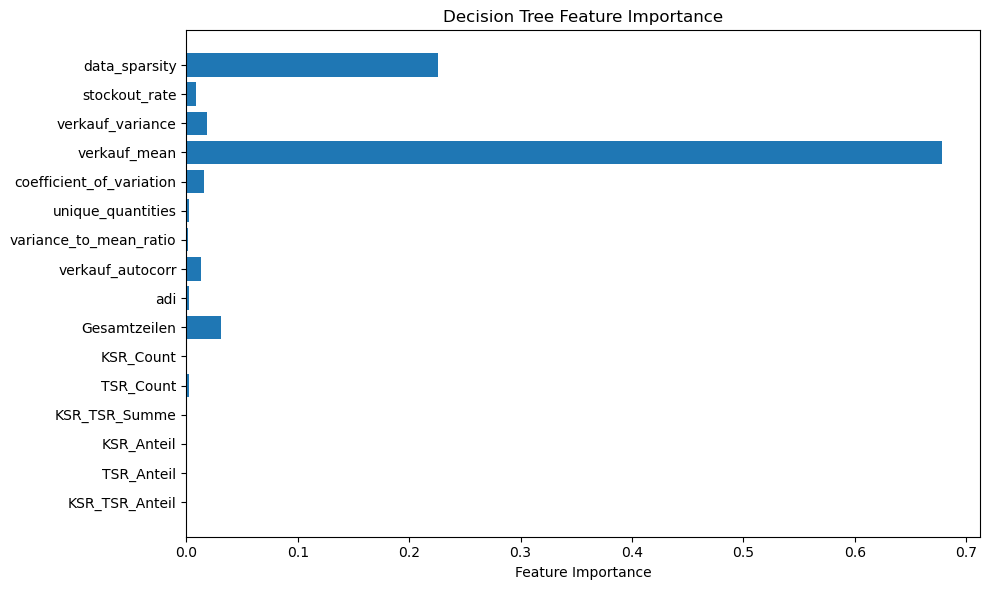


Calculating permutation importance...

Permutation Importance:
                     feature  importance_mean  importance_std
3               verkauf_mean           0.3124          0.0071
0              data_sparsity           0.1600          0.0076
4   coefficient_of_variation           0.0109          0.0041
5          unique_quantities           0.0054          0.0010
7           verkauf_autocorr           0.0043          0.0014
1              stockout_rate           0.0040          0.0031
11                 TSR_Count           0.0001          0.0003
8                        adi           0.0000          0.0000
10                 KSR_Count           0.0000          0.0000
12             KSR_TSR_Summe           0.0000          0.0000
14                TSR_Anteil           0.0000          0.0000
15            KSR_TSR_Anteil           0.0000          0.0000
2           verkauf_variance          -0.0001          0.0028
13                KSR_Anteil          -0.0003          0.0003
6     

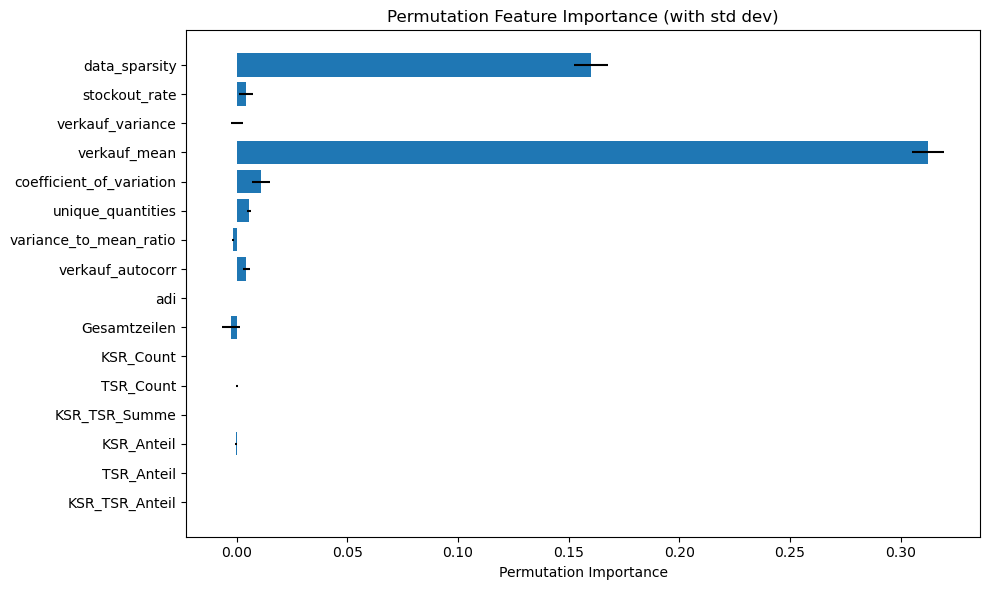

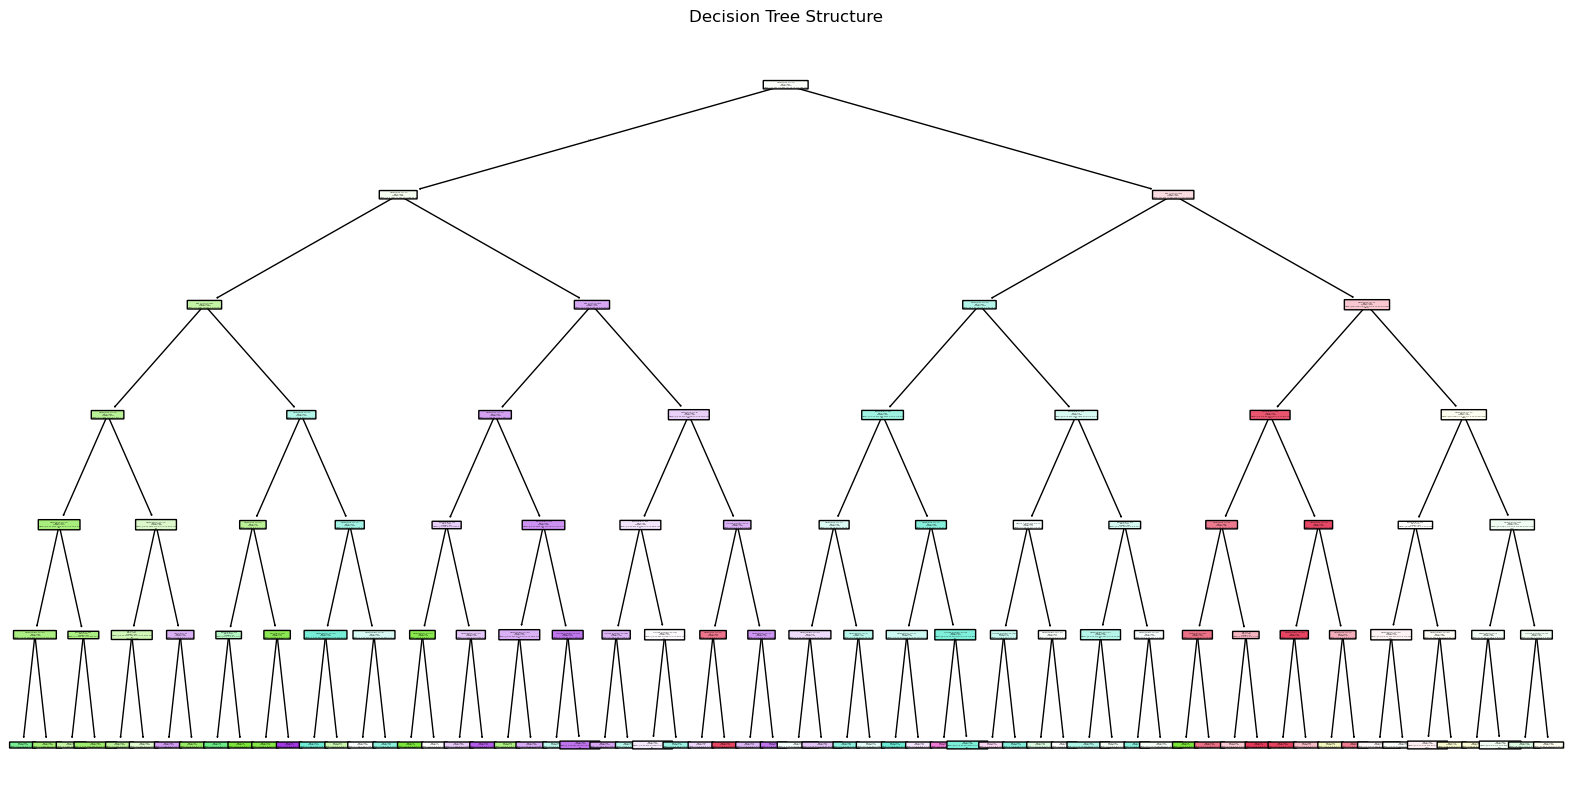


Decision Tree Rules:
|--- verkauf_mean <= 2.03
|   |--- verkauf_mean <= 1.31
|   |   |--- data_sparsity <= 1.00
|   |   |   |--- verkauf_mean <= 1.00
|   |   |   |   |--- verkauf_mean <= 0.70
|   |   |   |   |   |--- verkauf_variance <= 0.33
|   |   |   |   |   |   |--- class: Conrad
|   |   |   |   |   |--- verkauf_variance >  0.33
|   |   |   |   |   |   |--- class: Bayesian
|   |   |   |   |--- verkauf_mean >  0.70
|   |   |   |   |   |--- Gesamtzeilen <= 38.50
|   |   |   |   |   |   |--- class: Bayesian
|   |   |   |   |   |--- Gesamtzeilen >  38.50
|   |   |   |   |   |   |--- class: Bayesian
|   |   |   |--- verkauf_mean >  1.00
|   |   |   |   |--- verkauf_autocorr <= 0.26
|   |   |   |   |   |--- adi <= 1.30
|   |   |   |   |   |   |--- class: Bayesian
|   |   |   |   |   |--- adi >  1.30
|   |   |   |   |   |   |--- class: Bayesian
|   |   |   |   |--- verkauf_autocorr >  0.26
|   |   |   |   |   |--- TSR_Count <= 5.50
|   |   |   |   |   |   |--- class: N3
|   |   |   |   |

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree, export_text

def analyze_feature_importance(analysis_results, show_plots=True, figsize=(10, 6)):
    """
    Perform comprehensive feature importance analysis on a trained decision tree model.
    
    Parameters:
    -----------
    analysis_results : dict
        Results dictionary returned from analyze_uncensoring_methods()
    show_plots : bool, default=True
        Whether to display matplotlib plots
    figsize : tuple, default=(10, 6)
        Figure size for plots
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'feature_importance_df': DataFrame with feature importances
        - 'permutation_importance_df': DataFrame with permutation importances
        - 'tree_rules': Text representation of decision tree rules
    """
    
    # Extract components from analysis results
    clf = analysis_results['classifier']
    X_test = analysis_results['X_test']
    y_test = analysis_results['y_test']
    feature_names = X_test.columns
    
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # ============================================================================
    # Method 1: Standard Feature Importance from Decision Tree
    # ============================================================================
    
    feature_importance = clf.feature_importances_
    
    # Create a DataFrame for easier viewing
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance (Decision Tree):")
    print(importance_df.round(4))
    
    # Plot feature importance
    if show_plots:
        plt.figure(figsize=figsize)
        plt.barh(range(len(feature_importance)), feature_importance)
        plt.yticks(range(len(feature_importance)), feature_names)
        plt.xlabel('Feature Importance')
        plt.title('Decision Tree Feature Importance')
        plt.gca().invert_yaxis()  # Most important at top
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # Method 2: Permutation Importance (more reliable)
    # ============================================================================
    
    print(f"\nCalculating permutation importance...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(clf, X_test, y_test, 
                                           n_repeats=10, random_state=42)
    
    # Create DataFrame
    perm_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    print("\nPermutation Importance:")
    print(perm_df.round(4))
    
    # Plot permutation importance with error bars
    if show_plots:
        plt.figure(figsize=figsize)
        plt.barh(range(len(perm_importance.importances_mean)), 
                 perm_importance.importances_mean,
                 xerr=perm_importance.importances_std)
        plt.yticks(range(len(perm_importance.importances_mean)), feature_names)
        plt.xlabel('Permutation Importance')
        plt.title('Permutation Feature Importance (with std dev)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # Method 3: Visualize the Decision Tree Structure
    # ============================================================================
    
    if show_plots:
        plt.figure(figsize=(20, 10))
        plot_tree(clf, feature_names=feature_names, 
                  class_names=clf.classes_, filled=True, rounded=True)
        plt.title('Decision Tree Structure')
        plt.show()
    
    # ============================================================================
    # Method 4: Export tree rules (text format)
    # ============================================================================
    
    tree_rules = export_text(clf, feature_names=list(feature_names))
    print("\nDecision Tree Rules:")
    print(tree_rules)
    
    # ============================================================================
    # Summary Analysis
    # ============================================================================
    
    print(f"\nFEATURE IMPORTANCE SUMMARY")
    print("="*80)
    
    # Top 5 most important features (standard importance)
    top_5_standard = importance_df.head(5)
    print("Top 5 Features (Standard Importance):")
    for idx, row in top_5_standard.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    # Top 5 most important features (permutation importance)
    top_5_perm = perm_df.head(5)
    print("\nTop 5 Features (Permutation Importance):")
    for idx, row in top_5_perm.iterrows():
        print(f"  {row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")
    
    # Compare the two methods
    print(f"\nFeature Ranking Comparison:")
    print("="*50)
    print("Rank | Standard Method      | Permutation Method")
    print("-" * 50)
    
    for i in range(min(10, len(feature_names))):  # Show top 10 or all if fewer
        standard_feature = importance_df.iloc[i]['feature']
        perm_feature = perm_df.iloc[i]['feature']
        print(f"{i+1:2d}   | {standard_feature:<20} | {perm_feature}")
    
    return {
        'feature_importance_df': importance_df,
        'permutation_importance_df': perm_df,
        'tree_rules': tree_rules
    }


# Then analyze feature importance
features = analyze_feature_importance(analysis)

# Access specific results
top_features = features['feature_importance_df']
permutation_results = features['permutation_importance_df']
decision_rules = features['tree_rules']